In [1]:
%run '/home/gvolta/XENONnT/Initialization/Initialization_for_SPE.py'

0.0.8


In [2]:
runs = st.select_runs(run_mode='LED*')
runs[['name', 'comments']]

Checking data availability: 100%|██████████| 5/5 [00:21<00:00,  3.72s/it]


,name,comments
112,180219_0952,"[{'text': 'LED Calibration step 0 #gain_step0', 'date': 2018-02-19 09:52:13+00:00, 'user': 'moli..."
113,180219_1001,"[{'text': 'LED Calibration step 1 #gain_step1', 'date': 2018-02-19 10:01:41+00:00, 'user': 'moli..."
114,180219_1011,"[{'text': 'LED Calibration step 2 #gain_step2', 'date': 2018-02-19 10:11:06+00:00, 'user': 'moli..."
115,180219_1021,"[{'text': 'LED Calibration step 3 #gain_step3', 'date': 2018-02-19 10:21:18+00:00, 'user': 'moli..."
116,180219_1030,"[{'text': 'LED Calibration step 4 #gain_step4', 'date': 2018-02-19 10:31:02+00:00, 'user': 'moli..."
117,180219_1049,"[{'text': 'SPE acceptance top bulk #spe_topbulk', 'date': 2018-02-19 10:50:00+00:00, 'user': 'mo..."
118,180219_1059,"[{'text': 'SPE acceptance top ring #spe_topring', 'date': 2018-02-19 10:59:21+00:00, 'user': 'mo..."
119,180219_1110,"[{'text': '#Afterpulse mode 0', 'date': 2018-02-19 11:10:28+00:00, 'user': 'molinario'}]"
120,180219_1116,"[{'text': '#Afterpulse mode 1', 'date': 2018-02-19 11:16:48+00:00, 'user': 'molinario'}]"


In [3]:
run_id = '180219_1001'
data_rr = st.get_array(run_id, 'raw_records', max_workers = 5, seconds_range=(0,30))

In [4]:
len(data_rr)

3100832

In [5]:
data_rr['area']

array([  -45,    24,  -903, ...,  -214,  -447, -1023], dtype=int32)

In [7]:
def get_area(raw_records, LED_window = [125, 250]):
    '''
    Needed for the gain computation.
    Sum the data in the defined window to get the area.
    This is done in 6 integration window and it returns the average area.
    '''
    left = LED_window[0]
    end_pos = [LED_window[1]+2*i for i in range(6)]
    n_channel_s = np.arange(0, 249, 1) # TODO: to change during nT commissioning or add in configuration options
    Area = np.array(raw_records[['channel', 'area']],dtype=[('channel','int16'),('area','float32')])
    Area_2 = []

    for n_channel in tqdm(n_channel_s):
        wf_tmp = raw_records[raw_records['channel'] == n_channel]
        area = 0
        for right in end_pos:
            area += wf_tmp['data'][:,left:right].sum(axis=1)
            print('#####', n_channel, '#####')
            print('1) ', left, ' - ', right, ' : ', area)
        print('\n')    
        mask = np.where(Area['channel'] == n_channel)[0]
        Area['area'][mask] = area.astype(np.float)/6.
        
    channels = np.arange(248)
    Area_2 = []

    left = LED_window[0]
    end_pos = [LED_window[1]+2*i for i in range(6)]
    for ch in tqdm(channels): 
        arr_ch = data_rr[data_rr['channel'] == ch]
        Area_ch = []
        area = 0
        for right in end_pos:
            area += arr_ch['data'][:,left:right].sum(axis=1)
            print('#####', ch, '#####')
            print('2)', left, ' - ', right, ' : ', area)
        print('\n') 
        Area_ch.append(area)
        Area_ch[:] = [x/len(end_pos) for x in Area_ch]
        Area_2.append(Area_ch)
    
    return Area, Area_2

In [32]:
def get_area_2(raw_records, LED_window = [125, 250]):
    '''
    Needed for the gain computation.
    Sum the data in the defined window to get the area.
    This is done in 6 integration window and it returns the average area.
    '''
    n_channels = 10
    left = LED_window[0]
    end_pos = [LED_window[1]+2*i for i in range(6)]
    Area = np.zeros((len(data_rr)), dtype=[('channel','int16'),('area','float32')])
    for right in end_pos:
        Area['area'] += data_rr['data'][:n_channels, left:right].sum(axis=1)
        #print(Area)
    Area['channel'] = data_rr['channel']
    Area['area'] = Area['area']/6.

    return Area#, Area_2

In [10]:
Area, Area_2 = get_area(data_rr)

  1%|          | 2/249 [00:00<00:18, 13.24it/s]

##### 0 #####
1)  125  -  250  :  [ -30 -128  291 ...    3  -25   40]
##### 0 #####
1)  125  -  252  :  [ -58 -261  583 ...    4  -46   76]
##### 0 #####
1)  125  -  254  :  [ -85 -401  876 ...    4  -69  113]
##### 0 #####
1)  125  -  256  :  [-113 -550 1170 ...    2  -94  148]
##### 0 #####
1)  125  -  258  :  [-139 -707 1463 ...   -4 -119  181]
##### 0 #####
1)  125  -  260  :  [-167 -867 1758 ...  -11 -141  218]


##### 1 #####
1)  125  -  250  :  [ -44  -93 -101 ...  -75  -49  -53]
##### 1 #####
1)  125  -  252  :  [ -88 -177 -204 ... -153 -100 -113]
##### 1 #####
1)  125  -  254  :  [-133 -250 -309 ... -229 -152 -178]
##### 1 #####
1)  125  -  256  :  [-180 -306 -418 ... -308 -206 -247]
##### 1 #####
1)  125  -  258  :  [-229 -354 -526 ... -386 -264 -316]
##### 1 #####
1)  125  -  260  :  [-278 -402 -635 ... -465 -320 -384]


##### 2 #####
1)  125  -  250  :  [ -47 -116   32 ...  -57  -23  -17]
##### 2 #####
1)  125  -  252  :  [ -97 -243   66 ... -114  -49  -38]
##### 2 #####
1)

  2%|▏         | 4/249 [00:00<00:18, 13.46it/s]

##### 3 #####
1)  125  -  250  :  [ -45   40   47 ... -118 -142  -24]
##### 3 #####
1)  125  -  252  :  [ -89   78   91 ... -239 -288  -52]
##### 3 #####
1)  125  -  254  :  [-135  118  138 ... -363 -441  -85]
##### 3 #####
1)  125  -  256  :  [-180  156  187 ... -487 -600 -118]
##### 3 #####
1)  125  -  258  :  [-225  190  235 ... -614 -760 -150]
##### 3 #####
1)  125  -  260  :  [-270  222  284 ... -740 -924 -180]


##### 4 #####
1)  125  -  250  :  [  25 -196   53 ...  206 -107  121]
##### 4 #####
1)  125  -  252  :  [  51 -394  104 ...  410 -216  234]
##### 4 #####
1)  125  -  254  :  [  80 -595  160 ...  612 -332  336]
##### 4 #####
1)  125  -  256  :  [ 109 -798  217 ...  814 -456  432]
##### 4 #####
1)  125  -  258  :  [  136 -1005   277 ...  1017  -579   528]
##### 4 #####
1)  125  -  260  :  [  166 -1216   338 ...  1217  -704   630]


##### 5 #####
1)  125  -  250  :  [-105   13  -27 ...  -94  227  -90]
##### 5 #####
1)  125  -  252  :  [-212   18  -57 ... -191  453 -179]
####

  3%|▎         | 8/249 [00:00<00:18, 13.05it/s]

#####
1)  125  -  258  :  [-532    9 -146 ... -479 1137 -479]
##### 5 #####
1)  125  -  260  :  [-640    4 -177 ... -573 1367 -579]


##### 6 #####
1)  125  -  250  :  [ -90 -125   21 ...  328  312  -57]
##### 6 #####
1)  125  -  252  :  [-179 -258   44 ...  651  621 -112]
##### 6 #####
1)  125  -  254  :  [-270 -394   71 ...  972  928 -161]
##### 6 #####
1)  125  -  256  :  [-361 -528  100 ... 1293 1236 -207]
##### 6 #####
1)  125  -  258  :  [-453 -659  129 ... 1610 1540 -255]
##### 6 #####
1)  125  -  260  :  [-547 -786  159 ... 1929 1844 -305]


##### 7 #####
1)  125  -  250  :  [  -7   26 -117 ...  -26  -95  -44]
##### 7 #####
1)  125  -  252  :  [ -14   45 -233 ...  -51 -192  -90]
##### 7 #####
1)  125  -  254  :  [ -19   59 -350 ...  -78 -290 -136]
##### 7 #####
1)  125  -  256  :  [ -25   68 -467 ... -107 -394 -186]
##### 7 #####
1)  125  -  258  :  [ -32   73 -590 ... -140 -500 -239]
##### 7 #####
1)  125  -  260  :  [ -38   78 -714 ... -171 -607 -295]


##### 8 #####
1)  125 

  4%|▍         | 10/249 [00:00<00:17, 13.43it/s]

##### 8 #####
1)  125  -  256  :  [ -92   94  584 ... -441 -188 -471]
##### 8 #####
1)  125  -  258  :  [-109  101  726 ... -554 -239 -596]
##### 8 #####
1)  125  -  260  :  [-125  107  867 ... -668 -293 -721]


##### 9 #####
1)  125  -  250  :  [  35 -146  -33 ...  -43  -55  152]
##### 9 #####
1)  125  -  252  :  [  72 -293  -65 ...  -91 -106  298]
##### 9 #####
1)  125  -  254  :  [ 109 -447  -96 ... -143 -157  436]
##### 9 #####
1)  125  -  256  :  [ 148 -608 -126 ... -197 -209  566]
##### 9 #####
1)  125  -  258  :  [ 188 -773 -156 ... -256 -262  698]
##### 9 #####
1)  125  -  260  :  [ 228 -940 -189 ... -317 -313  830]


##### 10 #####
1)  125  -  250  :  [-193 -140  145 ...  -59   -6 -100]
##### 10 #####
1)  125  -  252  :  [-388 -280  291 ... -119  -16 -204]
##### 10 #####
1)  125  -  254  :  [-583 -420  434 ... -180  -29 -311]
##### 10 #####
1)  125  -  256  :  [-780 -560  575 ... -243  -48 -422]
##### 10 #####
1)  125  -  258  :  [-978 -703  718 ... -307  -70 -535]
##### 10 ##

  6%|▌         | 14/249 [00:01<00:16, 13.98it/s]

##### 11 #####
1)  125  -  256  :  [-216  394 -562 ...  378 -301  853]
##### 11 #####
1)  125  -  258  :  [-274  487 -710 ...  466 -381 1066]
##### 11 #####
1)  125  -  260  :  [-333  581 -863 ...  556 -459 1279]


##### 12 #####
1)  125  -  250  :  [-39 -68 -68 ...  21 -37 -30]
##### 12 #####
1)  125  -  252  :  [ -81 -140 -137 ...   39  -75  -58]
##### 12 #####
1)  125  -  254  :  [-123 -222 -204 ...   58 -113  -82]
##### 12 #####
1)  125  -  256  :  [-161 -309 -271 ...   76 -151 -106]
##### 12 #####
1)  125  -  258  :  [-197 -401 -340 ...   94 -188 -133]
##### 12 #####
1)  125  -  260  :  [-232 -494 -411 ...  114 -222 -164]


##### 13 #####
1)  125  -  250  :  [-127   19  -42 ...  131  238  -47]
##### 13 #####
1)  125  -  252  :  [-256   45  -83 ...  260  473  -98]
##### 13 #####
1)  125  -  254  :  [-387   78 -124 ...  388  709 -149]
##### 13 #####
1)  125  -  256  :  [-523  117 -166 ...  511  943 -201]
##### 13 #####
1)  125  -  258  :  [-662  154 -210 ...  632 1181 -253]
##### 13

  6%|▋         | 16/249 [00:01<00:16, 14.15it/s]

##### 14 #####
1)  125  -  254  :  [-512 -535  460 ...  824 -238  -82]
##### 14 #####
1)  125  -  256  :  [-686 -724  615 ... 1103 -325 -103]
##### 14 #####
1)  125  -  258  :  [-858 -912  775 ... 1385 -412 -122]
##### 14 #####
1)  125  -  260  :  [-1029 -1098   934 ...  1666  -497  -144]


##### 15 #####
1)  125  -  250  :  [  -6    7  -11 ... -109  264   80]
##### 15 #####
1)  125  -  252  :  [ -10   14  -22 ... -220  526  162]
##### 15 #####
1)  125  -  254  :  [ -12   16  -34 ... -334  790  245]
##### 15 #####
1)  125  -  256  :  [ -13   12  -47 ... -448 1050  330]
##### 15 #####
1)  125  -  258  :  [ -17    6  -57 ... -565 1308  417]
##### 15 #####
1)  125  -  260  :  [ -19   -2  -68 ... -683 1568  503]


##### 16 #####
1)  125  -  250  :  [-190  -83  -29 ...   78  -13  -81]
##### 16 #####
1)  125  -  252  :  [-383 -172  -62 ...  156  -25 -167]
##### 16 #####
1)  125  -  254  :  [-579 -264  -94 ...  234  -38 -259]
##### 16 #####
1)  125  -  256  :  [-778 -358 -129 ...  311  -55 -3

  8%|▊         | 20/249 [00:01<00:15, 14.40it/s]

##### 17 #####
1)  125  -  252  :  [ -75 -263  622 ...  240  316 -295]
##### 17 #####
1)  125  -  254  :  [-113 -394  936 ...  358  470 -447]
##### 17 #####
1)  125  -  256  :  [-154 -528 1248 ...  472  626 -600]
##### 17 #####
1)  125  -  258  :  [-197 -666 1555 ...  585  784 -754]
##### 17 #####
1)  125  -  260  :  [-241 -803 1861 ...  694  942 -910]


##### 18 #####
1)  125  -  250  :  [ 50  36 136 ... -19 302 183]
##### 18 #####
1)  125  -  252  :  [ 99  76 272 ... -37 603 361]
##### 18 #####
1)  125  -  254  :  [148 120 413 ... -52 902 536]
##### 18 #####
1)  125  -  256  :  [ 196  167  553 ...  -66 1200  708]
##### 18 #####
1)  125  -  258  :  [ 245  217  695 ...  -80 1498  879]
##### 18 #####
1)  125  -  260  :  [ 295  269  839 ...  -97 1796 1052]


##### 19 #####
1)  125  -  250  :  [-104  150  -14 ...  -54   32  -15]
##### 19 #####
1)  125  -  252  :  [-208  303  -31 ... -112   64  -28]
##### 19 #####
1)  125  -  254  :  [-313  460  -48 ... -172   93  -39]
##### 19 #####
1)  1

  9%|▉         | 22/249 [00:01<00:15, 14.48it/s]

##### 20 #####
1)  125  -  250  :  [-46 -89 -38 ...  76 -41 289]
##### 20 #####
1)  125  -  252  :  [ -94 -176  -76 ...  149  -88  572]
##### 20 #####
1)  125  -  254  :  [-143 -257 -113 ...  220 -139  856]
##### 20 #####
1)  125  -  256  :  [-193 -333 -149 ...  291 -187 1142]
##### 20 #####
1)  125  -  258  :  [-244 -409 -184 ...  360 -230 1430]
##### 20 #####
1)  125  -  260  :  [-298 -490 -217 ...  428 -268 1720]


##### 21 #####
1)  125  -  250  :  [-91   5  25 ...  56 167  40]
##### 21 #####
1)  125  -  252  :  [-185    7   54 ...  109  328   80]
##### 21 #####
1)  125  -  254  :  [-279    7   83 ...  160  488  120]
##### 21 #####
1)  125  -  256  :  [-371    6  115 ...  209  649  165]
##### 21 #####
1)  125  -  258  :  [-465   12  148 ...  254  809  211]
##### 21 #####
1)  125  -  260  :  [-562   23  186 ...  300  973  889]


##### 22 #####
1)  125  -  250  :  [ -7 -68 253 ... 251 -89 -14]
##### 22 #####
1)  125  -  252  :  [ -12 -135  509 ...  506 -182  -28]
##### 22 #####
1)  1

 10%|▉         | 24/249 [00:01<00:17, 13.13it/s]

##### 22 #####
1)  125  -  260  :  [ -24 -384 1537 ... 1541 -581  -71]


##### 23 #####
1)  125  -  250  :  [-231   15   29 ... -118   37  -59]
##### 23 #####
1)  125  -  252  :  [-472   30   61 ... -238   75 -120]
##### 23 #####
1)  125  -  254  :  [-717   45   93 ... -361  112 -184]
##### 23 #####
1)  125  -  256  :  [-963   63  124 ... -483  148 -246]
##### 23 #####
1)  125  -  258  :  [-1214    82   157 ...  -608   183  -309]
##### 23 #####
1)  125  -  260  :  [-1467   101   191 ...  -735   220  -370]


##### 24 #####
1)  125  -  250  :  [ -92  168  -21 ...  -17  263 -159]
##### 24 #####
1)  125  -  252  :  [-183  335  -41 ...  -38  524 -323]
##### 24 #####
1)  125  -  254  :  [-276  495  -59 ...  -63  782 -488]
##### 24 #####
1)  125  -  256  :  [-371  648  -74 ...  -89 1037 -655]
##### 24 #####
1)  125  -  258  :  [-467  798  -91 ... -118 1289 -826]
##### 24 #####
1)  125  -  260  :  [ -566   951  -107 ...  -145  1539 -1002]


##### 25 #####
1)  125  -  250  :  [-135 -124  224 ..

 11%|█         | 28/249 [00:02<00:15, 13.87it/s]

##### 25 #####
1)  125  -  260  :  [-863 -821 1295 ... -669 -286  238]


##### 26 #####
1)  125  -  250  :  [-108  -29 -159 ...  -85  -84  -55]
##### 26 #####
1)  125  -  252  :  [-217  -59 -317 ... -171 -166 -115]
##### 26 #####
1)  125  -  254  :  [-326  -89 -478 ... -262 -253 -179]
##### 26 #####
1)  125  -  256  :  [-436 -117 -645 ... -351 -344 -244]
##### 26 #####
1)  125  -  258  :  [-546 -144 -816 ... -441 -433 -308]
##### 26 #####
1)  125  -  260  :  [-660 -167 -988 ... -533 -527 -372]


##### 27 #####
1)  125  -  250  :  [  38  -36 -114 ...   26 -172   83]
##### 27 #####
1)  125  -  252  :  [  77  -69 -229 ...   53 -345  165]
##### 27 #####
1)  125  -  254  :  [ 118 -100 -346 ...   80 -520  246]
##### 27 #####
1)  125  -  256  :  [ 161 -130 -464 ...  109 -697  331]
##### 27 #####
1)  125  -  258  :  [ 206 -164 -581 ...  139 -874  415]
##### 27 #####
1)  125  -  260  :  [  249  -199  -699 ...   171 -1053   498]


##### 28 #####
1)  125  -  250  :  [ -70 -100  -42 ...  -15  -92 

 12%|█▏        | 30/249 [00:02<00:15, 14.06it/s]

##### 28 #####
1)  125  -  258  :  [-348 -479 -213 ...  -77 -489  579]
##### 28 #####
1)  125  -  260  :  [-411 -575 -255 ...  -87 -593  690]


##### 29 #####
1)  125  -  250  :  [ -73   -2  -87 ...  -37 -134  -40]
##### 29 #####
1)  125  -  252  :  [-148   -8 -175 ...  -76 -275  -78]
##### 29 #####
1)  125  -  254  :  [-222  -19 -261 ... -115 -420 -116]
##### 29 #####
1)  125  -  256  :  [-295  -31 -345 ... -152 -566 -154]
##### 29 #####
1)  125  -  258  :  [-366  -45 -431 ... -189 -715 -192]
##### 29 #####
1)  125  -  260  :  [-443  -58 -517 ... -228 -865 -234]


##### 30 #####
1)  125  -  250  :  [ 259 -156  -37 ...  244  -60  -50]
##### 30 #####
1)  125  -  252  :  [ 518 -321  -71 ...  484 -125 -103]
##### 30 #####
1)  125  -  254  :  [ 775 -492  -99 ...  719 -195 -158]
##### 30 #####
1)  125  -  256  :  [1034 -673 -123 ...  954 -263 -213]
##### 30 #####
1)  125  -  258  :  [1294 -857 -149 ... 1189 -331 -268]
##### 30 #####
1)  125  -  260  :  [ 1551 -1043  -175 ...  1419  -400  -3

 14%|█▎        | 34/249 [00:02<00:14, 14.41it/s]

##### 31 #####
1)  125  -  256  :  [  302  1313 -1050 ...   171  -282 -1273]
##### 31 #####
1)  125  -  258  :  [  380  1651 -1325 ...   221  -358 -1602]
##### 31 #####
1)  125  -  260  :  [  459  1993 -1605 ...   278  -398 -1939]


##### 32 #####
1)  125  -  250  :  [ 19 148 -86 ... -69  50  14]
##### 32 #####
1)  125  -  252  :  [  35  305 -171 ... -141   98   32]
##### 32 #####
1)  125  -  254  :  [  47  468 -261 ... -212  146   52]
##### 32 #####
1)  125  -  256  :  [  57  636 -354 ... -282  193   70]
##### 32 #####
1)  125  -  258  :  [  66  803 -450 ... -356  236   86]
##### 32 #####
1)  125  -  260  :  [  71  962 -549 ... -432  279  101]


##### 33 #####
1)  125  -  250  :  [ 119  -97 -229 ...   76   29  -53]
##### 33 #####
1)  125  -  252  :  [ 240 -193 -464 ...  156   61 -113]
##### 33 #####
1)  125  -  254  :  [ 364 -286 -704 ...  241   92 -177]
##### 33 #####
1)  125  -  256  :  [ 488 -379 -948 ...  329  125 -243]
##### 33 #####
1)  125  -  258  :  [  618  -471 -1198 ...   4

 14%|█▍        | 36/249 [00:02<00:14, 14.52it/s]

##### 34 #####
1)  125  -  254  :  [  46  120 -350 ...  -31  249 -169]
##### 34 #####
1)  125  -  256  :  [  60  159 -471 ...  -45  331 -225]
##### 34 #####
1)  125  -  258  :  [  72  203 -590 ...  -58  411 -280]
##### 34 #####
1)  125  -  260  :  [  81  247 -712 ...  -74  488 -334]


##### 35 #####
1)  125  -  250  :  [ 59 118 160 ... 286 196 -39]
##### 35 #####
1)  125  -  252  :  [116 237 321 ... 573 392 -86]
##### 35 #####
1)  125  -  254  :  [ 175  359  482 ...  857  586 -138]
##### 35 #####
1)  125  -  256  :  [ 234  485  644 ... 1138  775 -190]
##### 35 #####
1)  125  -  258  :  [ 295  612  807 ... 1417  960 -243]
##### 35 #####
1)  125  -  260  :  [ 357  738  971 ... 1694 1140 -293]


##### 36 #####
1)  125  -  250  :  [-18 -38 254 ...  96 168  63]
##### 36 #####
1)  125  -  252  :  [-38 -74 508 ... 189 340 120]
##### 36 #####
1)  125  -  254  :  [ -63 -113  764 ...  280  517  174]
##### 36 #####
1)  125  -  256  :  [ -93 -161 1020 ...  365  700  230]
##### 36 #####
1)  125  - 

 16%|█▌        | 40/249 [00:02<00:14, 14.62it/s]

##### 37 #####
1)  125  -  254  :  [-181  423  151 ...  534  161  757]
##### 37 #####
1)  125  -  256  :  [-238  566  208 ...  709  219 1004]
##### 37 #####
1)  125  -  258  :  [-298  707  263 ...  882  276 1248]
##### 37 #####
1)  125  -  260  :  [-363  845  312 ... 1053  335 1490]


##### 38 #####
1)  125  -  250  :  [-141   31 -112 ...  155  -72  663]
##### 38 #####
1)  125  -  252  :  [-286   63 -226 ...  308 -142 1323]
##### 38 #####
1)  125  -  254  :  [-433   88 -343 ...  459 -215 1981]
##### 38 #####
1)  125  -  256  :  [-578  110 -459 ...  609 -289 2642]
##### 38 #####
1)  125  -  258  :  [-726  129 -575 ...  758 -357 3304]
##### 38 #####
1)  125  -  260  :  [-873  145 -693 ...  904 -428 3964]


##### 39 #####
1)  125  -  250  :  [ -89 -208    9 ... -128  142  143]
##### 39 #####
1)  125  -  252  :  [-178 -415   16 ... -258  287  295]
##### 39 #####
1)  125  -  254  :  [-273 -624   27 ... -387  426  453]
##### 39 #####
1)  125  -  256  :  [-370 -842   38 ... -516  564  611]
##

 17%|█▋        | 42/249 [00:03<00:15, 13.20it/s]

##### 40 #####
1)  125  -  250  :  [-196  239  -81 ...  123  108  142]
##### 40 #####
1)  125  -  252  :  [-392  485 -165 ...  247  215  289]
##### 40 #####
1)  125  -  254  :  [-594  739 -253 ...  371  326  438]
##### 40 #####
1)  125  -  256  :  [-800 1001 -340 ...  498  431  588]
##### 40 #####
1)  125  -  258  :  [-1008  1272  -429 ...   624   534   738]
##### 40 #####
1)  125  -  260  :  [-1220  1544  -519 ...   745   633   878]


##### 41 #####
1)  125  -  250  :  [  16  -35   76 ... -157 -118  -32]
##### 41 #####
1)  125  -  252  :  [  35  -75  152 ... -314 -238  -67]
##### 41 #####
1)  125  -  254  :  [  54 -125  230 ... -471 -364 -100]
##### 41 #####
1)  125  -  256  :  [  77 -180  308 ... -631 -490 -128]
##### 41 #####
1)  125  -  258  :  [ 101 -235  387 ... -791 -615 -154]
##### 41 #####
1)  125  -  260  :  [ 126 -285  468 ... -951 -741 -178]


##### 42 #####
1)  125  -  250  :  [-27 -57 143 ... -46   0 188]
##### 42 #####
1)  125  -  252  :  [ -51 -114  283 ...  -92   -2  3

 18%|█▊        | 46/249 [00:03<00:14, 13.94it/s]

##### 43 #####
1)  125  -  250  :  [ -23  -51  180 ...  -92  120 -177]
##### 43 #####
1)  125  -  252  :  [ -47 -106  358 ... -186  239 -360]
##### 43 #####
1)  125  -  254  :  [ -69 -165  537 ... -285  353 -543]
##### 43 #####
1)  125  -  256  :  [ -88 -232  714 ... -387  467 -729]
##### 43 #####
1)  125  -  258  :  [-105 -298  885 ... -488  587 -918]
##### 43 #####
1)  125  -  260  :  [ -118  -362  1056 ...  -586   706 -1108]


##### 44 #####
1)  125  -  250  :  [  45  -17  440 ...  121  -81 -140]
##### 44 #####
1)  125  -  252  :  [  89  -37  883 ...  242 -160 -283]
##### 44 #####
1)  125  -  254  :  [ 132  -58 1326 ...  362 -240 -427]
##### 44 #####
1)  125  -  256  :  [ 177  -77 1768 ...  481 -321 -577]
##### 44 #####
1)  125  -  258  :  [ 224  -87 2214 ...  601 -401 -733]
##### 44 #####
1)  125  -  260  :  [ 272  -92 2663 ...  720 -483 -893]


##### 45 #####
1)  125  -  250  :  [  2 -39 109 ... 370  14 -95]
##### 45 #####
1)  125  -  252  :  [   2  -82  219 ...  741   23 -188]
##

 19%|█▉        | 48/249 [00:03<00:14, 14.14it/s]

##### 46 #####
1)  125  -  250  :  [-134  168  237 ...  -41  -44   -5]
##### 46 #####
1)  125  -  252  :  [-268  341  472 ...  -83  -89  -14]
##### 46 #####
1)  125  -  254  :  [-402  520  706 ... -126 -134  -25]
##### 46 #####
1)  125  -  256  :  [-538  704  937 ... -173 -179  -41]
##### 46 #####
1)  125  -  258  :  [-677  882 1169 ... -220 -218  -61]
##### 46 #####
1)  125  -  260  :  [-819 1059 1399 ... -267 -258  -79]


##### 47 #####
1)  125  -  250  :  [-110  -31  132 ...  126   69  -26]
##### 47 #####
1)  125  -  252  :  [-223  -63  264 ...  250  137  -57]
##### 47 #####
1)  125  -  254  :  [-339  -99  397 ...  374  201  -93]
##### 47 #####
1)  125  -  256  :  [-457 -138  527 ...  497  260 -133]
##### 47 #####
1)  125  -  258  :  [-575 -179  656 ...  620  316 -174]
##### 47 #####
1)  125  -  260  :  [-692 -221  786 ...  742  373 -209]


##### 48 #####
1)  125  -  250  :  [-183   17  -78 ...  -50  178    3]
##### 48 #####
1)  125  -  252  :  [-369   25 -156 ... -103  359    0]
##

 21%|██        | 52/249 [00:03<00:13, 14.41it/s]

##### 49 #####
1)  125  -  250  :  [-38 138 300 ...  63 355 -42]
##### 49 #####
1)  125  -  252  :  [-77 273 599 ... 123 708 -86]
##### 49 #####
1)  125  -  254  :  [-119  402  898 ...  184 1062 -128]
##### 49 #####
1)  125  -  256  :  [-163  522 1198 ...  247 1417 -168]
##### 49 #####
1)  125  -  258  :  [-207  640 1500 ...  310 1772 -210]
##### 49 #####
1)  125  -  260  :  [-250  758 1802 ...  373 2133 -254]


##### 50 #####
1)  125  -  250  :  [-151  -26  310 ...  -75    8  -14]
##### 50 #####
1)  125  -  252  :  [-304  -58  621 ... -149   13  -28]
##### 50 #####
1)  125  -  254  :  [-456  -92  928 ... -224   19  -40]
##### 50 #####
1)  125  -  256  :  [-608 -125 1232 ... -300   23  -51]
##### 50 #####
1)  125  -  258  :  [-762 -157 1534 ... -378   24  -62]
##### 50 #####
1)  125  -  260  :  [-915 -188 1839 ... -460   27  -73]


##### 51 #####
1)  125  -  250  :  [-87  46 -41 ... -10 272  16]
##### 51 #####
1)  125  -  252  :  [-177   92  -84 ...  -20  546   35]
##### 51 #####
1)  1

 22%|██▏       | 54/249 [00:03<00:13, 14.48it/s]

##### 52 #####
1)  125  -  250  :  [ -25 -139  167 ...  -19  144   73]
##### 52 #####
1)  125  -  252  :  [ -50 -278  334 ...  -39  285  146]
##### 52 #####
1)  125  -  254  :  [ -77 -426  503 ...  -62  420  219]
##### 52 #####
1)  125  -  256  :  [-102 -577  671 ...  -83  551  293]
##### 52 #####
1)  125  -  258  :  [-129 -729  842 ... -105  682  368]
##### 52 #####
1)  125  -  260  :  [-157 -885 1013 ... -128  815  447]


##### 53 #####
1)  125  -  250  :  [-161   42  111 ...  164   51  171]
##### 53 #####
1)  125  -  252  :  [-323   90  218 ...  328   98  342]
##### 53 #####
1)  125  -  254  :  [-486  137  325 ...  492  140  515]
##### 53 #####
1)  125  -  256  :  [-651  177  432 ...  658  182  686]
##### 53 #####
1)  125  -  258  :  [-815  213  537 ...  824  224  856]
##### 53 #####
1)  125  -  260  :  [-981  249  641 ...  989  266 1026]


##### 54 #####
1)  125  -  250  :  [ 175  114  692 ...  -20  -71 -127]
##### 54 #####
1)  125  -  252  :  [ 348  231 1384 ...  -40 -146 -260]
##

 22%|██▏       | 56/249 [00:03<00:13, 14.53it/s]

##### 55 #####
1)  125  -  250  :  [  83   16  -22 ... -106  295  175]
##### 55 #####
1)  125  -  252  :  [ 165   21  -45 ... -215  584  348]
##### 55 #####
1)  125  -  254  :  [ 246   24  -66 ... -328  870  523]
##### 55 #####
1)  125  -  256  :  [ 330   24  -86 ... -443 1150  702]
##### 55 #####
1)  125  -  258  :  [ 414   22 -107 ... -559 1431  883]
##### 55 #####
1)  125  -  260  :  [ 499   20 -126 ... -677 1716 1067]


##### 56 #####
1)  125  -  250  :  [-129  165  -31 ...   56 -124  215]
##### 56 #####
1)  125  -  252  :  [-262  331  -61 ...  109 -250  421]
##### 56 #####
1)  125  -  254  :  [-400  498  -89 ...  162 -379  620]
##### 56 #####
1)  125  -  256  :  [-539  668 -118 ...  214 -511  820]
##### 56 #####
1)  125  -  258  :  [-683  842 -150 ...  264 -648 1020]
##### 56 #####
1)  125  -  260  :  [-831 1015 -184 ...  312 -785 1224]


##### 57 #####
1)  125  -  250  :  [-116  -58 -201 ... -110 -100  171]
##### 57 #####
1)  125  -  252  :  [-234 -117 -406 ... -222 -203  342]
##

 24%|██▍       | 60/249 [00:04<00:13, 13.55it/s]

##### 57 #####
1)  125  -  260  :  [ -695  -389 -1274 ...  -685  -633  1035]


##### 58 #####
1)  125  -  250  :  [-43   5 316 ... 131 177  27]
##### 58 #####
1)  125  -  252  :  [-89  15 631 ... 262 353  53]
##### 58 #####
1)  125  -  254  :  [-138   28  945 ...  397  530   79]
##### 58 #####
1)  125  -  256  :  [-186   45 1255 ...  530  708  105]
##### 58 #####
1)  125  -  258  :  [-238   66 1564 ...  666  886  123]
##### 58 #####
1)  125  -  260  :  [-289   86 1872 ...  799 1065  135]


##### 59 #####
1)  125  -  250  :  [-126   33  133 ...  195  -69   19]
##### 59 #####
1)  125  -  252  :  [-252   67  266 ...  389 -141   35]
##### 59 #####
1)  125  -  254  :  [-378  102  400 ...  584 -217   49]
##### 59 #####
1)  125  -  256  :  [-506  133  536 ...  779 -296   59]
##### 59 #####
1)  125  -  258  :  [-635  164  671 ...  973 -378   70]
##### 59 #####
1)  125  -  260  :  [-767  196  809 ... 1167 -462   80]


##### 60 #####
1)  125  -  250  :  [ -22  -76  135 ...  -12 -147   90]
##### 

 25%|██▍       | 62/249 [00:04<00:13, 13.89it/s]

##### 60 #####
1)  125  -  258  :  [-114 -431  639 ...  -75 -747  432]
##### 60 #####
1)  125  -  260  :  [-137 -531  761 ...  -95 -900  511]


##### 61 #####
1)  125  -  250  :  [-97 185 -21 ...  46 116  33]
##### 61 #####
1)  125  -  252  :  [-194  365  -42 ...   92  230   66]
##### 61 #####
1)  125  -  254  :  [-291  538  -61 ...  138  344  101]
##### 61 #####
1)  125  -  256  :  [-386  710  -79 ...  183  462  136]
##### 61 #####
1)  125  -  258  :  [-479  880  -97 ...  228  586  168]
##### 61 #####
1)  125  -  260  :  [-572 1059 -113 ...  271  713  203]


##### 62 #####
1)  125  -  250  :  [ 129  -61  -90 ... -127  -92  -27]
##### 62 #####
1)  125  -  252  :  [ 263 -121 -179 ... -254 -190  -54]
##### 62 #####
1)  125  -  254  :  [ 401 -186 -269 ... -381 -291  -80]
##### 62 #####
1)  125  -  256  :  [ 542 -253 -361 ... -507 -400 -106]
##### 62 #####
1)  125  -  258  :  [ 686 -317 -454 ... -635 -514 -133]
##### 62 #####
1)  125  -  260  :  [ 831 -377 -548 ... -767 -630 -159]


##### 

 27%|██▋       | 66/249 [00:04<00:12, 14.33it/s]

##### 63 #####
1)  125  -  258  :  [-751 2785  294 ... 2587 1243 1128]
##### 63 #####
1)  125  -  260  :  [-911 3359  353 ... 3108 1483 1336]


##### 64 #####
1)  125  -  250  :  [-138  -30  -26 ...  335  201  206]
##### 64 #####
1)  125  -  252  :  [-277  -66  -54 ...  668  402  415]
##### 64 #####
1)  125  -  254  :  [-419 -101  -84 ... 1002  601  630]
##### 64 #####
1)  125  -  256  :  [-563 -129 -114 ... 1337  803  847]
##### 64 #####
1)  125  -  258  :  [-708 -150 -144 ... 1672 1004 1063]
##### 64 #####
1)  125  -  260  :  [-854 -169 -175 ... 2007 1204 1269]


##### 65 #####
1)  125  -  250  :  [  22  -63 -128 ...  -19 -132 -147]
##### 65 #####
1)  125  -  252  :  [  47 -136 -257 ...  -39 -271 -295]
##### 65 #####
1)  125  -  254  :  [  77 -216 -390 ...  -58 -411 -440]
##### 65 #####
1)  125  -  256  :  [ 107 -300 -527 ...  -73 -549 -586]
##### 65 #####
1)  125  -  258  :  [ 138 -381 -668 ...  -91 -688 -729]
##### 65 #####
1)  125  -  260  :  [ 172 -456 -809 ... -111 -829 -873]




 27%|██▋       | 68/249 [00:04<00:12, 14.50it/s]

##### 66 #####
1)  125  -  258  :  [   6  481 -887 ...  282 -494   -1]
##### 66 #####
1)  125  -  260  :  [    8   567 -1074 ...   345  -600     4]


##### 67 #####
1)  125  -  250  :  [-80 164  -6 ... 133   5 310]
##### 67 #####
1)  125  -  252  :  [-159  339  -13 ...  266    8  616]
##### 67 #####
1)  125  -  254  :  [-242  524  -23 ...  400   10  919]
##### 67 #####
1)  125  -  256  :  [-323  711  -32 ...  535   10 1222]
##### 67 #####
1)  125  -  258  :  [-409  902  -45 ...  668    8 1526]
##### 67 #####
1)  125  -  260  :  [-501 1091  -57 ...  800   -5 1833]


##### 68 #####
1)  125  -  250  :  [443 -28 331 ... -82 702 355]
##### 68 #####
1)  125  -  252  :  [ 885  -62  664 ... -166 1402  703]
##### 68 #####
1)  125  -  254  :  [1330 -100  996 ... -253 2103 1046]
##### 68 #####
1)  125  -  256  :  [1776 -133 1328 ... -342 2799 1387]
##### 68 #####
1)  125  -  258  :  [2220 -161 1660 ... -430 3495 1724]
##### 68 #####
1)  125  -  260  :  [2665 -186 1988 ... -516 4193 2062]


##### 

 29%|██▉       | 72/249 [00:05<00:12, 14.59it/s]

##### 69 #####
1)  125  -  258  :  [-164  964 -146 ...   20  986 1501]
##### 69 #####
1)  125  -  260  :  [-193 1155 -177 ...   29 1182 1795]


##### 70 #####
1)  125  -  250  :  [ 374  107  139 ...  225    8 -102]
##### 70 #####
1)  125  -  252  :  [ 749  208  281 ...  452   18 -204]
##### 70 #####
1)  125  -  254  :  [1128  306  420 ...  682   29 -311]
##### 70 #####
1)  125  -  256  :  [1511  408  556 ...  912   41 -421]
##### 70 #####
1)  125  -  258  :  [1901  519  694 ... 1140   60 -534]
##### 70 #####
1)  125  -  260  :  [2295  637  834 ... 1368   80 -649]


##### 71 #####
1)  125  -  250  :  [-105  -58  193 ...   85  -49  -97]
##### 71 #####
1)  125  -  252  :  [-212 -124  389 ...  170 -100 -192]
##### 71 #####
1)  125  -  254  :  [-319 -188  585 ...  255 -153 -280]
##### 71 #####
1)  125  -  256  :  [-427 -250  783 ...  340 -210 -365]
##### 71 #####
1)  125  -  258  :  [-535 -308  978 ...  426 -271 -450]
##### 71 #####
1)  125  -  260  :  [-641 -359 1173 ...  509 -333 -535]




 30%|██▉       | 74/249 [00:05<00:11, 14.66it/s]

##### 72 #####
1)  125  -  256  :  [-215  -91  173 ... -449  -52  115]
##### 72 #####
1)  125  -  258  :  [-270 -113  214 ... -571  -66  137]
##### 72 #####
1)  125  -  260  :  [-328 -146  257 ... -693  -81  160]


##### 73 #####
1)  125  -  250  :  [ -99  -63  -40 ...  -42 -146  -20]
##### 73 #####
1)  125  -  252  :  [-199 -129  -79 ...  -84 -297  -41]
##### 73 #####
1)  125  -  254  :  [-303 -197 -117 ... -125 -450  -65]
##### 73 #####
1)  125  -  256  :  [-410 -266 -157 ... -167 -604  -91]
##### 73 #####
1)  125  -  258  :  [-518 -333 -200 ... -212 -758 -117]
##### 73 #####
1)  125  -  260  :  [-629 -399 -240 ... -260 -914 -144]


##### 74 #####
1)  125  -  250  :  [ -15  -70  -23 ...  995   57 -180]
##### 74 #####
1)  125  -  252  :  [ -30 -135  -41 ... 1992  111 -361]
##### 74 #####
1)  125  -  254  :  [ -41 -195  -60 ... 2990  162 -543]
##### 74 #####
1)  125  -  256  :  [ -51 -253  -77 ... 3985  211 -726]
##### 74 #####
1)  125  -  258  :  [ -63 -309  -92 ... 4980  257 -912]
##

 31%|███▏      | 78/249 [00:05<00:12, 13.64it/s]

##### 75 #####
1)  125  -  250  :  [-114   17  -81 ...  -53  906  608]
##### 75 #####
1)  125  -  252  :  [-230   38 -159 ... -106 1810 1216]
##### 75 #####
1)  125  -  254  :  [-347   58 -239 ... -159 2709 1822]
##### 75 #####
1)  125  -  256  :  [-464   80 -320 ... -219 3600 2425]
##### 75 #####
1)  125  -  258  :  [-579  103 -403 ... -281 4490 3024]
##### 75 #####
1)  125  -  260  :  [-693  126 -492 ... -344 5374 3622]


##### 76 #####
1)  125  -  250  :  [ -45 -120  -14 ...  599   89   24]
##### 76 #####
1)  125  -  252  :  [ -90 -250  -29 ... 1194  178   49]
##### 76 #####
1)  125  -  254  :  [-139 -387  -45 ... 1786  264   77]
##### 76 #####
1)  125  -  256  :  [-195 -527  -62 ... 2376  349  107]
##### 76 #####
1)  125  -  258  :  [-252 -666  -78 ... 2968  433  138]
##### 76 #####
1)  125  -  260  :  [-306 -804  -98 ... 3560  515  167]


##### 77 #####
1)  125  -  250  :  [-78 211  72 ... 405 -68 -80]
##### 77 #####
1)  125  -  252  :  [-158  427  144 ...  809 -136 -168]
##### 77

 32%|███▏      | 80/249 [00:05<00:12, 13.98it/s]

##### 78 #####
1)  125  -  250  :  [ -69  -33   24 ...   37 -120   71]
##### 78 #####
1)  125  -  252  :  [-135  -72   43 ...   74 -243  140]
##### 78 #####
1)  125  -  254  :  [-204 -117   61 ...  113 -370  209]
##### 78 #####
1)  125  -  256  :  [-272 -165   80 ...  156 -499  280]
##### 78 #####
1)  125  -  258  :  [-337 -212   98 ...  202 -629  355]
##### 78 #####
1)  125  -  260  :  [-405 -256  117 ...  250 -763  431]


##### 79 #####
1)  125  -  250  :  [ -79 -158 -160 ... -152  -30  -23]
##### 79 #####
1)  125  -  252  :  [-161 -322 -324 ... -310  -61  -47]
##### 79 #####
1)  125  -  254  :  [-244 -488 -491 ... -473  -90  -71]
##### 79 #####
1)  125  -  256  :  [-328 -655 -657 ... -635 -121  -93]
##### 79 #####
1)  125  -  258  :  [-413 -819 -826 ... -803 -156 -115]
##### 79 #####
1)  125  -  260  :  [-497 -985 -997 ... -976 -193 -135]


##### 80 #####
1)  125  -  250  :  [ -4 166 164 ... -76 163 -16]
##### 80 #####
1)  125  -  252  :  [  -8  330  324 ... -153  321  -37]
##### 80

 34%|███▎      | 84/249 [00:05<00:11, 14.28it/s]

##### 81 #####
1)  125  -  250  :  [ -80  360  167 ...  380  194 -125]
##### 81 #####
1)  125  -  252  :  [-165  716  337 ...  763  386 -255]
##### 81 #####
1)  125  -  254  :  [-253 1068  509 ... 1144  575 -396]
##### 81 #####
1)  125  -  256  :  [-341 1418  679 ... 1525  759 -545]
##### 81 #####
1)  125  -  258  :  [-428 1770  847 ... 1906  942 -703]
##### 81 #####
1)  125  -  260  :  [-518 2118 1015 ... 2286 1123 -867]


##### 82 #####
1)  125  -  250  :  [ -82 -134  307 ...  -31  218  381]
##### 82 #####
1)  125  -  252  :  [-163 -272  612 ...  -64  432  756]
##### 82 #####
1)  125  -  254  :  [-245 -412  915 ...  -96  646 1129]
##### 82 #####
1)  125  -  256  :  [-327 -559 1221 ... -130  861 1502]
##### 82 #####
1)  125  -  258  :  [-414 -713 1528 ... -166 1076 1876]
##### 82 #####
1)  125  -  260  :  [-502 -871 1837 ... -200 1291 2255]


##### 83 #####
1)  125  -  250  :  [-128  179  473 ...    9   54  -24]
##### 83 #####
1)  125  -  252  :  [-256  358  942 ...   19  104  -48]
##

 35%|███▍      | 86/249 [00:06<00:11, 14.34it/s]

##### 84 #####
1)  125  -  250  :  [-145   -9  252 ...  -51  285   99]
##### 84 #####
1)  125  -  252  :  [-290  -13  504 ... -106  567  194]
##### 84 #####
1)  125  -  254  :  [-436  -13  759 ... -161  847  283]
##### 84 #####
1)  125  -  256  :  [-581  -15 1013 ... -214 1128  368]
##### 84 #####
1)  125  -  258  :  [-726  -23 1265 ... -271 1408  454]
##### 84 #####
1)  125  -  260  :  [-874  -37 1521 ... -327 1688  544]


##### 85 #####
1)  125  -  250  :  [ 84 -78  -1 ... 279 243 104]
##### 85 #####
1)  125  -  252  :  [ 169 -156   -1 ...  557  482  210]
##### 85 #####
1)  125  -  254  :  [ 254 -234   -3 ...  830  724  314]
##### 85 #####
1)  125  -  256  :  [ 341 -311   -2 ... 1097  966  418]
##### 85 #####
1)  125  -  258  :  [ 424 -390   -2 ... 1362 1203  523]
##### 85 #####
1)  125  -  260  :  [ 508 -474   -2 ... 1627 1436  630]


##### 86 #####
1)  125  -  250  :  [-136 -124   29 ... -105  -52   -2]
##### 86 #####
1)  125  -  252  :  [-272 -249   62 ... -209 -102    1]
##### 86

 36%|███▌      | 90/249 [00:06<00:10, 14.52it/s]

##### 87 #####
1)  125  -  250  :  [ 36 -12 -84 ... -16   9 -19]
##### 87 #####
1)  125  -  252  :  [  72  -22 -168 ...  -33   22  -38]
##### 87 #####
1)  125  -  254  :  [ 105  -29 -254 ...  -47   34  -60]
##### 87 #####
1)  125  -  256  :  [ 140  -37 -339 ...  -60   47  -86]
##### 87 #####
1)  125  -  258  :  [ 176  -43 -429 ...  -72   60 -113]
##### 87 #####
1)  125  -  260  :  [ 208  -48 -521 ...  -85   71 -142]


##### 88 #####
1)  125  -  250  :  [ 24 -11  34 ... -19  57  -1]
##### 88 #####
1)  125  -  252  :  [ 48 -20  70 ... -36 112 -11]
##### 88 #####
1)  125  -  254  :  [ 77 -28 104 ... -54 164 -24]
##### 88 #####
1)  125  -  256  :  [109 -34 139 ... -71 218 -38]
##### 88 #####
1)  125  -  258  :  [139 -46 173 ... -91 271 -53]
##### 88 #####
1)  125  -  260  :  [ 167  -58  204 ... -116  324  -67]


##### 89 #####
1)  125  -  250  :  [  44  172 -181 ...   86  244  -15]
##### 89 #####
1)  125  -  252  :  [  92  346 -365 ...  175  490  -37]
##### 89 #####
1)  125  -  254  :  [ 1

 37%|███▋      | 92/249 [00:06<00:10, 14.53it/s]

##### 90 #####
1)  125  -  250  :  [ -39  -98   15 ... -207   19  -14]
##### 90 #####
1)  125  -  252  :  [ -76 -195   31 ... -419   37  -28]
##### 90 #####
1)  125  -  254  :  [-115 -290   45 ... -636   59  -42]
##### 90 #####
1)  125  -  256  :  [-152 -380   59 ... -858   81  -56]
##### 90 #####
1)  125  -  258  :  [ -189  -464    74 ... -1082   100   -74]
##### 90 #####
1)  125  -  260  :  [ -226  -548    86 ... -1308   120   -95]


##### 91 #####
1)  125  -  250  :  [-13   7  36 ...  28 -90 -66]
##### 91 #####
1)  125  -  252  :  [ -25    4   69 ...   57 -182 -128]
##### 91 #####
1)  125  -  254  :  [ -35   -7  103 ...   84 -277 -194]
##### 91 #####
1)  125  -  256  :  [ -44  -20  138 ...  108 -376 -259]
##### 91 #####
1)  125  -  258  :  [ -50  -26  173 ...  133 -475 -325]
##### 91 #####
1)  125  -  260  :  [ -56  -27  210 ...  161 -577 -396]


##### 92 #####
1)  125  -  250  :  [  47  345 -103 ...  145  -57  333]
##### 92 #####
1)  125  -  252  :  [  93  696 -205 ...  291 -121  6

 38%|███▊      | 94/249 [00:06<00:11, 13.18it/s]

##### 92 #####
1)  125  -  260  :  [ 301 2162 -632 ...  870 -422 1900]


##### 93 #####
1)  125  -  250  :  [ -70 -114   28 ...   67   67  196]
##### 93 #####
1)  125  -  252  :  [-139 -231   56 ...  139  128  391]
##### 93 #####
1)  125  -  254  :  [-206 -348   82 ...  217  186  584]
##### 93 #####
1)  125  -  256  :  [-266 -465  104 ...  292  246  773]
##### 93 #####
1)  125  -  258  :  [-323 -580  126 ...  363  306  962]
##### 93 #####
1)  125  -  260  :  [-376 -699  147 ...  435  361 1154]


##### 94 #####
1)  125  -  250  :  [-62 -61 311 ...  73 275 151]
##### 94 #####
1)  125  -  252  :  [-125 -125  616 ...  147  547  302]
##### 94 #####
1)  125  -  254  :  [-191 -186  919 ...  215  823  454]
##### 94 #####
1)  125  -  256  :  [-256 -244 1219 ...  279 1101  608]
##### 94 #####
1)  125  -  258  :  [-318 -303 1517 ...  339 1381  759]
##### 94 #####
1)  125  -  260  :  [-377 -361 1812 ...  396 1659  910]


##### 95 #####
1)  125  -  250  :  [ -60  -19  153 ...  121  285 1064]
##### 

 39%|███▉      | 98/249 [00:07<00:12, 12.57it/s]

##### 95 #####
1)  125  -  260  :  [-382 -133  918 ...  698 1732 6353]


##### 96 #####
1)  125  -  250  :  [  -4  -17  234 ... -103  -56    0]
##### 96 #####
1)  125  -  252  :  [ -11  -36  465 ... -205 -113    7]
##### 96 #####
1)  125  -  254  :  [ -19  -56  694 ... -307 -174   20]
##### 96 #####
1)  125  -  256  :  [ -29  -71  920 ... -409 -239   38]
##### 96 #####
1)  125  -  258  :  [ -39  -80 1143 ... -511 -310   62]
##### 96 #####
1)  125  -  260  :  [ -48  -81 1363 ... -615 -381   83]


##### 97 #####
1)  125  -  250  :  [-38 153   3 ...  39  15 -13]
##### 97 #####
1)  125  -  252  :  [-76 305   5 ...  75  27 -33]
##### 97 #####
1)  125  -  254  :  [-113  457    1 ...  106   40  -59]
##### 97 #####
1)  125  -  256  :  [-146  613   -1 ...  132   56  -92]
##### 97 #####
1)  125  -  258  :  [-181  770   -2 ...  157   72 -127]
##### 97 #####
1)  125  -  260  :  [-216  925   -7 ...  178   86 -159]




 40%|████      | 100/249 [00:07<00:11, 13.10it/s]

##### 98 #####
1)  125  -  250  :  [ -53  294 -107 ...  -20  137   92]
##### 98 #####
1)  125  -  252  :  [-106  591 -210 ...  -40  272  182]
##### 98 #####
1)  125  -  254  :  [-156  882 -313 ...  -63  406  270]
##### 98 #####
1)  125  -  256  :  [-204 1170 -418 ...  -87  541  356]
##### 98 #####
1)  125  -  258  :  [-249 1455 -523 ... -114  677  442]
##### 98 #####
1)  125  -  260  :  [-293 1733 -630 ... -145  807  529]


##### 99 #####
1)  125  -  250  :  [-47   0 376 ... 194 403 307]
##### 99 #####
1)  125  -  252  :  [-93  -1 753 ... 386 804 613]
##### 99 #####
1)  125  -  254  :  [-140   -1 1132 ...  577 1205  916]
##### 99 #####
1)  125  -  256  :  [-186   -4 1509 ...  763 1612 1215]
##### 99 #####
1)  125  -  258  :  [-233  -15 1888 ...  947 2020 1512]
##### 99 #####
1)  125  -  260  :  [-277  -32 2268 ... 1128 2431 1807]


##### 100 #####
1)  125  -  250  :  [ 96 -35 -41 ...  20  38  49]
##### 100 #####
1)  125  -  252  :  [193 -72 -84 ...  42  78  99]
##### 100 #####
1)  125 

 42%|████▏     | 104/249 [00:07<00:10, 13.85it/s]

##### 101 #####
1)  125  -  250  :  [-98 -16 -41 ...  92 162  31]
##### 101 #####
1)  125  -  252  :  [-198  -39  -81 ...  178  319   56]
##### 101 #####
1)  125  -  254  :  [-300  -68 -120 ...  263  473   77]
##### 101 #####
1)  125  -  256  :  [-405  -95 -158 ...  348  625   99]
##### 101 #####
1)  125  -  258  :  [-512 -114 -194 ...  433  777  116]
##### 101 #####
1)  125  -  260  :  [-622 -119 -231 ...  519  935  127]


##### 102 #####
1)  125  -  250  :  [ -76 -111 -166 ... -113  -80  -23]
##### 102 #####
1)  125  -  252  :  [-152 -223 -331 ... -229 -159  -46]
##### 102 #####
1)  125  -  254  :  [-228 -333 -499 ... -347 -237  -67]
##### 102 #####
1)  125  -  256  :  [-309 -437 -667 ... -465 -318  -89]
##### 102 #####
1)  125  -  258  :  [-390 -538 -838 ... -582 -397 -113]
##### 102 #####
1)  125  -  260  :  [ -469  -634 -1012 ...  -703  -478  -138]


##### 103 #####
1)  125  -  250  :  [-97 158 246 ...  63 124 -21]
##### 103 #####
1)  125  -  252  :  [-195  314  492 ...  124  245 

 43%|████▎     | 106/249 [00:07<00:10, 14.15it/s]

##### 104 #####
1)  125  -  250  :  [-203  179  368 ...  104  254  -67]
##### 104 #####
1)  125  -  252  :  [-407  356  737 ...  205  507 -133]
##### 104 #####
1)  125  -  254  :  [-618  534 1106 ...  299  762 -201]
##### 104 #####
1)  125  -  256  :  [-832  709 1470 ...  389 1017 -268]
##### 104 #####
1)  125  -  258  :  [-1048   887  1836 ...   476  1273  -330]
##### 104 #####
1)  125  -  260  :  [-1265  1064  2203 ...   562  1525  -391]


##### 105 #####
1)  125  -  250  :  [ -33  141  -91 ...  -59 -101 1020]
##### 105 #####
1)  125  -  252  :  [ -62  278 -180 ... -118 -208 2034]
##### 105 #####
1)  125  -  254  :  [ -95  415 -274 ... -176 -313 3045]
##### 105 #####
1)  125  -  256  :  [-127  555 -372 ... -237 -422 4052]
##### 105 #####
1)  125  -  258  :  [-159  701 -466 ... -299 -532 5059]
##### 105 #####
1)  125  -  260  :  [-192  846 -559 ... -361 -641 6069]


##### 106 #####
1)  125  -  250  :  [ -81 -130  242 ...   74  -17   31]
##### 106 #####
1)  125  -  252  :  [-162 -261  

 44%|████▍     | 110/249 [00:07<00:09, 14.47it/s]

 250  :  [ 41 -37 408 ... -75  16 -90]
##### 107 #####
1)  125  -  252  :  [  84  -72  817 ... -152   28 -191]
##### 107 #####
1)  125  -  254  :  [ 125 -111 1226 ... -231   38 -299]
##### 107 #####
1)  125  -  256  :  [ 164 -154 1635 ... -312   47 -413]
##### 107 #####
1)  125  -  258  :  [ 202 -206 2046 ... -397   51 -527]
##### 107 #####
1)  125  -  260  :  [ 241 -266 2459 ... -488   54 -633]


##### 108 #####
1)  125  -  250  :  [  56 -112  -12 ...  672 -108   46]
##### 108 #####
1)  125  -  252  :  [ 114 -219  -28 ... 1343 -219   88]
##### 108 #####
1)  125  -  254  :  [ 170 -317  -49 ... 2013 -332  123]
##### 108 #####
1)  125  -  256  :  [ 228 -420  -73 ... 2684 -446  150]
##### 108 #####
1)  125  -  258  :  [ 285 -533  -98 ... 3351 -560  174]
##### 108 #####
1)  125  -  260  :  [ 342 -661 -126 ... 4015 -676  204]


##### 109 #####
1)  125  -  250  :  [-117  -47   72 ...  331   69  155]
##### 109 #####
1)  125  -  252  :  [-235  -98  147 ...  665  137  309]
##### 109 #####
1)  1

 45%|████▍     | 112/249 [00:08<00:09, 14.49it/s]

##### 110 #####
1)  125  -  250  :  [  17  -56   71 ... -167  176  176]
##### 110 #####
1)  125  -  252  :  [  34 -120  142 ... -334  350  356]
##### 110 #####
1)  125  -  254  :  [  50 -186  213 ... -502  524  539]
##### 110 #####
1)  125  -  256  :  [  67 -250  285 ... -673  699  728]
##### 110 #####
1)  125  -  258  :  [  87 -307  353 ... -844  868  916]
##### 110 #####
1)  125  -  260  :  [  109  -362   422 ... -1014  1036  1102]


##### 111 #####
1)  125  -  250  :  [-71  11 -54 ... -63 -34 269]
##### 111 #####
1)  125  -  252  :  [-142   22 -109 ... -129  -73  535]
##### 111 #####
1)  125  -  254  :  [-215   26 -166 ... -199 -109  800]
##### 111 #####
1)  125  -  256  :  [-288   17 -223 ... -266 -144 1070]
##### 111 #####
1)  125  -  258  :  [-361   -4 -281 ... -333 -181 1344]
##### 111 #####
1)  125  -  260  :  [-434  -27 -338 ... -399 -216 1621]


##### 112 #####
1)  125  -  250  :  [-100 -112  -28 ... -136  -13   62]
##### 112 #####
1)  125  -  252  :  [-200 -223  -54 ... -273

 47%|████▋     | 116/249 [00:08<00:09, 14.60it/s]

##### 113 #####
1)  125  -  250  :  [-112 -170 -148 ... -100 -119   58]
##### 113 #####
1)  125  -  252  :  [-226 -346 -300 ... -203 -244  114]
##### 113 #####
1)  125  -  254  :  [-343 -523 -453 ... -309 -369  166]
##### 113 #####
1)  125  -  256  :  [-459 -694 -607 ... -416 -492  219]
##### 113 #####
1)  125  -  258  :  [-579 -862 -764 ... -526 -616  273]
##### 113 #####
1)  125  -  260  :  [ -699 -1030  -924 ...  -640  -742   329]


##### 114 #####
1)  125  -  250  :  [-85 435 -86 ... -27 481 548]
##### 114 #####
1)  125  -  252  :  [-169  875 -172 ...  -51  960 1094]
##### 114 #####
1)  125  -  254  :  [-255 1322 -264 ...  -76 1439 1638]
##### 114 #####
1)  125  -  256  :  [-338 1776 -358 ... -102 1921 2178]
##### 114 #####
1)  125  -  258  :  [-425 2234 -454 ... -128 2402 2721]
##### 114 #####
1)  125  -  260  :  [-516 2686 -549 ... -154 2886 3268]


##### 115 #####
1)  125  -  250  :  [-23  19 167 ... 231  97 -10]
##### 115 #####
1)  125  -  252  :  [-49  33 335 ... 463 190 -20]


 47%|████▋     | 118/249 [00:08<00:08, 14.62it/s]

##### 116 #####
1)  125  -  250  :  [-139  100  582 ...  334 -107  -51]
##### 116 #####
1)  125  -  252  :  [-277  199 1165 ...  663 -213 -102]
##### 116 #####
1)  125  -  254  :  [-417  299 1748 ...  987 -320 -153]
##### 116 #####
1)  125  -  256  :  [-561  399 2329 ... 1312 -431 -203]
##### 116 #####
1)  125  -  258  :  [-707  501 2910 ... 1634 -544 -257]
##### 116 #####
1)  125  -  260  :  [-852  605 3496 ... 1956 -659 -315]


##### 117 #####
1)  125  -  250  :  [-110  -35   62 ...  -37  -55    8]
##### 117 #####
1)  125  -  252  :  [-220  -70  121 ...  -73 -111   16]
##### 117 #####
1)  125  -  254  :  [-330 -103  177 ... -108 -167   22]
##### 117 #####
1)  125  -  256  :  [-441 -134  231 ... -144 -226   29]
##### 117 #####
1)  125  -  258  :  [-554 -166  283 ... -181 -287   37]
##### 117 #####
1)  125  -  260  :  [-664 -200  334 ... -218 -348   49]


##### 118 #####
1)  125  -  250  :  [-33 -85  -6 ... -70 -89 -91]
##### 118 #####
1)  125  -  252  :  [ -66 -173  -15 ... -142 -180 

 49%|████▉     | 122/249 [00:08<00:08, 14.66it/s]

##### 119 #####
1)  125  -  250  :  [-14 -47 199 ... 240 139 -48]
##### 119 #####
1)  125  -  252  :  [-31 -99 400 ... 480 273 -97]
##### 119 #####
1)  125  -  254  :  [ -49 -148  601 ...  718  400 -148]
##### 119 #####
1)  125  -  256  :  [ -65 -196  803 ...  957  528 -206]
##### 119 #####
1)  125  -  258  :  [ -87 -247 1007 ... 1197  652 -270]
##### 119 #####
1)  125  -  260  :  [-108 -295 1205 ... 1437  770 -343]


##### 120 #####
1)  125  -  250  :  [ 12 -62  81 ...  24 143  13]
##### 120 #####
1)  125  -  252  :  [  27 -122  164 ...   49  282   26]
##### 120 #####
1)  125  -  254  :  [  44 -184  247 ...   74  421   41]
##### 120 #####
1)  125  -  256  :  [  60 -249  334 ...   97  566   55]
##### 120 #####
1)  125  -  258  :  [  76 -318  418 ...  121  704   67]
##### 120 #####
1)  125  -  260  :  [  93 -394  503 ...  145  841   76]


##### 121 #####
1)  125  -  250  :  [-90 225 140 ... 358 440 531]
##### 121 #####
1)  125  -  252  :  [-186  454  279 ...  716  878 1059]
##### 121 ##

 50%|████▉     | 124/249 [00:08<00:08, 14.72it/s]

##### 122 #####
1)  125  -  250  :  [-25 229 478 ... 287 108 244]
##### 122 #####
1)  125  -  252  :  [-51 454 954 ... 577 212 486]
##### 122 #####
1)  125  -  254  :  [ -74  675 1428 ...  867  317  724]
##### 122 #####
1)  125  -  256  :  [ -98  899 1901 ... 1156  421  962]
##### 122 #####
1)  125  -  258  :  [-116 1129 2374 ... 1444  523 1200]
##### 122 #####
1)  125  -  260  :  [-131 1365 2845 ... 1731  625 1437]


##### 123 #####
1)  125  -  250  :  [-21 -60 205 ... 386 307  63]
##### 123 #####
1)  125  -  252  :  [ -41 -116  410 ...  772  614  122]
##### 123 #####
1)  125  -  254  :  [ -58 -174  616 ... 1157  921  176]
##### 123 #####
1)  125  -  256  :  [ -75 -237  822 ... 1541 1223  231]
##### 123 #####
1)  125  -  258  :  [ -94 -309 1029 ... 1923 1523  291]
##### 123 #####
1)  125  -  260  :  [-112 -386 1240 ... 2304 1820  353]


##### 124 #####
1)  125  -  250  :  [-118   45   86 ...  221   25    4]
##### 124 #####
1)  125  -  252  :  [-236   86  176 ...  435   45    0]
##### 

 51%|█████▏    | 128/249 [00:09<00:08, 14.70it/s]

##### 125 #####
1)  125  -  250  :  [-64 -98 250 ... 288   2 192]
##### 125 #####
1)  125  -  252  :  [-133 -198  500 ...  575    1  382]
##### 125 #####
1)  125  -  254  :  [-204 -298  746 ...  859    4  568]
##### 125 #####
1)  125  -  256  :  [-273 -395  989 ... 1141   10  753]
##### 125 #####
1)  125  -  258  :  [-345 -491 1232 ... 1423   19  938]
##### 125 #####
1)  125  -  260  :  [-419 -587 1474 ... 1703   28 1123]


##### 126 #####
1)  125  -  250  :  [-101  605  253 ... -146  438  163]
##### 126 #####
1)  125  -  252  :  [-208 1202  504 ... -295  869  327]
##### 126 #####
1)  125  -  254  :  [-317 1792  753 ... -449 1300  494]
##### 126 #####
1)  125  -  256  :  [-426 2374 1004 ... -609 1730  663]
##### 126 #####
1)  125  -  258  :  [-535 2956 1253 ... -772 2165  832]
##### 126 #####
1)  125  -  260  :  [-649 3542 1499 ... -938 2603  997]


##### 127 #####
1)  125  -  250  :  [306 530 871 ... 923 252 365]
##### 127 #####
1)  125  -  252  :  [ 614 1053 1742 ... 1848  504  731]


 52%|█████▏    | 130/249 [00:09<00:08, 14.73it/s]

##### 128 #####
1)  125  -  250  :  [ 66 398 673 ... 524  24 328]
##### 128 #####
1)  125  -  252  :  [ 134  792 1343 ... 1050   51  653]
##### 128 #####
1)  125  -  254  :  [ 202 1183 2011 ... 1580   81  977]
##### 128 #####
1)  125  -  256  :  [ 272 1572 2677 ... 2110  113 1297]
##### 128 #####
1)  125  -  258  :  [ 344 1961 3344 ... 2638  146 1614]
##### 128 #####
1)  125  -  260  :  [ 420 2352 4012 ... 3165  181 1934]


##### 129 #####
1)  125  -  250  :  [-104  491  164 ...  373  410  342]
##### 129 #####
1)  125  -  252  :  [-212  987  326 ...  747  824  691]
##### 129 #####
1)  125  -  254  :  [-316 1482  489 ... 1122 1238 1044]
##### 129 #####
1)  125  -  256  :  [-421 1976  649 ... 1498 1647 1396]
##### 129 #####
1)  125  -  258  :  [-528 2464  806 ... 1877 2055 1746]
##### 129 #####
1)  125  -  260  :  [-634 2946  958 ... 2257 2460 2093]


##### 130 #####
1)  125  -  250  :  [ 25 -66 -93 ... -67 -97 -38]
##### 130 #####
1)  125  -  252  :  [  51 -133 -191 ... -138 -195  -73]


 54%|█████▍    | 134/249 [00:09<00:07, 14.72it/s]

##### 131 #####
1)  125  -  250  :  [359 174  75 ...  58 146 437]
##### 131 #####
1)  125  -  252  :  [718 341 149 ... 117 292 880]
##### 131 #####
1)  125  -  254  :  [1077  506  218 ...  174  437 1326]
##### 131 #####
1)  125  -  256  :  [1435  667  282 ...  229  584 1773]
##### 131 #####
1)  125  -  258  :  [1791  824  343 ...  285  730 2220]
##### 131 #####
1)  125  -  260  :  [2150  980  401 ...  341  874 2663]


##### 132 #####
1)  125  -  250  :  [ 137  737  322 ...  862 1153  834]
##### 132 #####
1)  125  -  252  :  [ 270 1473  645 ... 1725 2304 1669]
##### 132 #####
1)  125  -  254  :  [ 401 2213  967 ... 2587 3456 2510]
##### 132 #####
1)  125  -  256  :  [ 528 2955 1286 ... 3448 4611 3360]
##### 132 #####
1)  125  -  258  :  [ 656 3699 1601 ... 4306 5760 4214]
##### 132 #####
1)  125  -  260  :  [ 785 4439 1914 ... 5162 6908 5070]


##### 133 #####
1)  125  -  250  :  [-75 574 882 ... 383 -79 598]
##### 133 #####
1)  125  -  252  :  [-153 1142 1763 ...  763 -157 1202]
##### 

 55%|█████▍    | 136/249 [00:09<00:07, 14.70it/s]

##### 134 #####
1)  125  -  250  :  [ -12    4    4 ...   -6  -41 -105]
##### 134 #####
1)  125  -  252  :  [ -24    7   10 ...  -12  -84 -211]
##### 134 #####
1)  125  -  254  :  [ -36   13   13 ...  -20 -132 -319]
##### 134 #####
1)  125  -  256  :  [ -48   20   19 ...  -27 -180 -434]
##### 134 #####
1)  125  -  258  :  [ -61   22   24 ...  -34 -235 -553]
##### 134 #####
1)  125  -  260  :  [ -74   18   26 ...  -43 -293 -676]


##### 135 #####
1)  125  -  250  :  [-101 -161 -158 ...  -64    9  -55]
##### 135 #####
1)  125  -  252  :  [-204 -326 -320 ... -132   16 -109]
##### 135 #####
1)  125  -  254  :  [-305 -493 -485 ... -202   23 -166]
##### 135 #####
1)  125  -  256  :  [-406 -655 -653 ... -274   25 -223]
##### 135 #####
1)  125  -  258  :  [-511 -820 -822 ... -351   28 -283]
##### 135 #####
1)  125  -  260  :  [-616 -984 -994 ... -431   33 -345]


##### 136 #####
1)  125  -  250  :  [373 202 978 ... 380 520 -98]
##### 136 #####
1)  125  -  252  :  [ 743  401 1952 ...  758 1041 

 56%|█████▌    | 140/249 [00:09<00:07, 14.71it/s]

##### 137 #####
1)  125  -  250  :  [ 62 -65 -57 ... -45  33  -6]
##### 137 #####
1)  125  -  252  :  [ 126 -133 -118 ...  -93   64  -10]
##### 137 #####
1)  125  -  254  :  [ 189 -199 -180 ... -141   92   -9]
##### 137 #####
1)  125  -  256  :  [ 257 -265 -241 ... -189  118   -8]
##### 137 #####
1)  125  -  258  :  [ 329 -329 -306 ... -239  143   -8]
##### 137 #####
1)  125  -  260  :  [ 399 -386 -376 ... -289  173  -15]


##### 138 #####
1)  125  -  250  :  [-157   -6 1206 ...  484  291  645]
##### 138 #####
1)  125  -  252  :  [-314  -13 2410 ...  969  581 1294]
##### 138 #####
1)  125  -  254  :  [-474  -23 3613 ... 1453  870 1944]
##### 138 #####
1)  125  -  256  :  [-638  -33 4810 ... 1937 1155 2595]
##### 138 #####
1)  125  -  258  :  [-803  -39 6004 ... 2418 1439 3244]
##### 138 #####
1)  125  -  260  :  [-971  -43 7198 ... 2896 1728 3889]


##### 139 #####
1)  125  -  250  :  [  0 -51 -84 ...  -1 -34 -82]
##### 139 #####
1)  125  -  252  :  [   0 -102 -168 ...   -2  -71 -162]


 57%|█████▋    | 142/249 [00:10<00:07, 14.71it/s]

##### 140 #####
1)  125  -  250  :  [ 73 482   3 ... 140 912 910]
##### 140 #####
1)  125  -  252  :  [ 143  968    3 ...  278 1821 1825]
##### 140 #####
1)  125  -  254  :  [ 209 1459    0 ...  414 2730 2746]
##### 140 #####
1)  125  -  256  :  [ 273 1948   -9 ...  547 3640 3671]
##### 140 #####
1)  125  -  258  :  [ 334 2434  -23 ...  678 4553 4601]
##### 140 #####
1)  125  -  260  :  [ 395 2912  -39 ...  809 5469 5529]


##### 141 #####
1)  125  -  250  :  [328 637  87 ... 897 161 473]
##### 141 #####
1)  125  -  252  :  [ 653 1274  173 ... 1794  317  950]
##### 141 #####
1)  125  -  254  :  [ 976 1905  254 ... 2687  469 1433]
##### 141 #####
1)  125  -  256  :  [1293 2526  335 ... 3578  619 1921]
##### 141 #####
1)  125  -  258  :  [1608 3134  412 ... 4465  767 2412]
##### 141 #####
1)  125  -  260  :  [1923 3734  486 ... 5352  918 2905]


##### 142 #####
1)  125  -  250  :  [-111   61  199 ...   99  620  591]
##### 142 #####
1)  125  -  252  :  [-228  126  390 ...  198 1244 1185]


 59%|█████▊    | 146/249 [00:10<00:07, 14.68it/s]

##### 143 #####
1)  125  -  250  :  [ 127  -75 1552 ...  475  418  362]
##### 143 #####
1)  125  -  252  :  [ 257 -149 3101 ...  950  835  721]
##### 143 #####
1)  125  -  254  :  [ 387 -228 4647 ... 1426 1248 1080]
##### 143 #####
1)  125  -  256  :  [ 521 -315 6194 ... 1906 1656 1439]
##### 143 #####
1)  125  -  258  :  [ 655 -407 7741 ... 2385 2065 1798]
##### 143 #####
1)  125  -  260  :  [ 792 -501 9284 ... 2865 2473 2158]


##### 144 #####
1)  125  -  250  :  [ 40 538 251 ... 185 732 283]
##### 144 #####
1)  125  -  252  :  [  79 1071  507 ...  369 1461  565]
##### 144 #####
1)  125  -  254  :  [ 120 1608  762 ...  550 2187  851]
##### 144 #####
1)  125  -  256  :  [ 161 2153 1014 ...  725 2912 1139]
##### 144 #####
1)  125  -  258  :  [ 201 2704 1265 ...  900 3633 1424]
##### 144 #####
1)  125  -  260  :  [ 239 3257 1512 ... 1075 4351 1707]


##### 145 #####
1)  125  -  250  :  [-119  749  405 ...  -91 1294  412]
##### 145 #####
1)  125  -  252  :  [-238 1498  809 ... -183 2591 

 59%|█████▉    | 148/249 [00:10<00:06, 14.67it/s]

##### 146 #####
1)  125  -  250  :  [  29    7  695 ...  -46 2050  204]
##### 146 #####
1)  125  -  252  :  [  58   14 1389 ...  -97 4101  402]
##### 146 #####
1)  125  -  254  :  [  89   21 2078 ... -152 6154  598]
##### 146 #####
1)  125  -  256  :  [ 120   30 2764 ... -206 8204  789]
##### 146 #####
1)  125  -  258  :  [  151    36  3447 ...  -264 10255   976]
##### 146 #####
1)  125  -  260  :  [  180    41  4129 ...  -318 12306  1160]


##### 147 #####
1)  125  -  250  :  [ -46  912 1552 ...  762 1183  510]
##### 147 #####
1)  125  -  252  :  [ -89 1825 3102 ... 1522 2361 1021]
##### 147 #####
1)  125  -  254  :  [-134 2738 4652 ... 2276 3535 1529]
##### 147 #####
1)  125  -  256  :  [-180 3649 6202 ... 3028 4708 2035]
##### 147 #####
1)  125  -  258  :  [-226 4562 7754 ... 3775 5881 2538]
##### 147 #####
1)  125  -  260  :  [-274 5476 9306 ... 4523 7054 3037]


##### 148 #####
1)  125  -  250  :  [ 170   86    7 ...   76 -128   16]
##### 148 #####
1)  125  -  252  :  [ 341  190  

 61%|██████    | 152/249 [00:10<00:06, 14.68it/s]

##### 149 #####
1)  125  -  250  :  [ 26 140 671 ... 241 239 237]
##### 149 #####
1)  125  -  252  :  [  54  261 1339 ...  480  475  481]
##### 149 #####
1)  125  -  254  :  [  78  373 2005 ...  718  709  729]
##### 149 #####
1)  125  -  256  :  [ 100  484 2667 ...  957  946  979]
##### 149 #####
1)  125  -  258  :  [ 125  602 3322 ... 1196 1183 1231]
##### 149 #####
1)  125  -  260  :  [ 151  731 3976 ... 1436 1416 1483]


##### 150 #####
1)  125  -  250  :  [-40 -19 -45 ... -52 -83  40]
##### 150 #####
1)  125  -  252  :  [ -84  -40  -91 ... -104 -166   84]
##### 150 #####
1)  125  -  254  :  [-126  -64 -141 ... -154 -250  133]
##### 150 #####
1)  125  -  256  :  [-170  -88 -192 ... -210 -336  185]
##### 150 #####
1)  125  -  258  :  [-218 -113 -239 ... -265 -420  240]
##### 150 #####
1)  125  -  260  :  [-266 -137 -288 ... -320 -505  295]


##### 151 #####
1)  125  -  250  :  [  30   55  489 ...  239 1281  -63]
##### 151 #####
1)  125  -  252  :  [  60  107  976 ...  477 2561 -129]


 62%|██████▏   | 154/249 [00:10<00:06, 14.71it/s]

##### 152 #####
1)  125  -  250  :  [ -47 -112 -144 ... -175   80  -34]
##### 152 #####
1)  125  -  252  :  [ -89 -224 -294 ... -352  155  -69]
##### 152 #####
1)  125  -  254  :  [-134 -330 -441 ... -527  233 -106]
##### 152 #####
1)  125  -  256  :  [-180 -435 -586 ... -704  316 -144]
##### 152 #####
1)  125  -  258  :  [-223 -538 -732 ... -883  393 -177]
##### 152 #####
1)  125  -  260  :  [ -271  -637  -882 ... -1066   473  -207]


##### 153 #####
1)  125  -  250  :  [-101 1082  530 ...  746  156  332]
##### 153 #####
1)  125  -  252  :  [-200 2164 1058 ... 1490  311  666]
##### 153 #####
1)  125  -  254  :  [-299 3242 1583 ... 2233  467 1000]
##### 153 #####
1)  125  -  256  :  [-402 4319 2105 ... 2975  623 1332]
##### 153 #####
1)  125  -  258  :  [-508 5401 2627 ... 3715  776 1660]
##### 153 #####
1)  125  -  260  :  [-617 6487 3150 ... 4457  927 1983]


##### 154 #####
1)  125  -  250  :  [ 154 -105  246 ...  271  122  767]
##### 154 #####
1)  125  -  252  :  [ 307 -212  490 ..

 63%|██████▎   | 156/249 [00:10<00:06, 14.64it/s]

##### 155 #####
1)  125  -  250  :  [293 181 344 ...  81  23 534]
##### 155 #####
1)  125  -  252  :  [ 587  360  687 ...  155   48 1064]
##### 155 #####
1)  125  -  254  :  [ 877  538 1029 ...  221   71 1591]
##### 155 #####
1)  125  -  256  :  [1166  718 1366 ...  282   95 2117]
##### 155 #####
1)  125  -  258  :  [1455  899 1702 ...  337  122 2642]
##### 155 #####
1)  125  -  260  :  [1743 1078 2037 ...  386  150 3167]


##### 156 #####
1)  125  -  250  :  [ -91  296  429 ...  266  348 -139]
##### 156 #####
1)  125  -  252  :  [-180  584  859 ...  534  689 -279]
##### 156 #####
1)  125  -  254  :  [-271  866 1287 ...  803 1030 -421]
##### 156 #####
1)  125  -  256  :  [-362 1150 1714 ... 1070 1371 -567]
##### 156 #####
1)  125  -  258  :  [-456 1443 2138 ... 1337 1710 -710]
##### 156 #####
1)  125  -  260  :  [-551 1741 2565 ... 1605 2046 -857]


##### 157 #####
1)  125  -  250  :  [-27 243 316 ... 360 -41 258]
##### 157 #####
1)  125  -  252  :  [-51 491 635 ... 723 -80 517]
##### 

 64%|██████▍   | 160/249 [00:11<00:06, 13.31it/s]

##### 157 #####
1)  125  -  260  :  [-163 1521 1928 ... 2170 -247 1518]


##### 158 #####
1)  125  -  250  :  [  24 1141  -66 ...  279  894  368]
##### 158 #####
1)  125  -  252  :  [  48 2279 -132 ...  559 1787  736]
##### 158 #####
1)  125  -  254  :  [  73 3411 -197 ...  839 2674 1106]
##### 158 #####
1)  125  -  256  :  [  99 4542 -262 ... 1121 3561 1475]
##### 158 #####
1)  125  -  258  :  [ 126 5673 -327 ... 1408 4450 1839]
##### 158 #####
1)  125  -  260  :  [ 152 6805 -395 ... 1695 5338 2203]


##### 159 #####
1)  125  -  250  :  [114 106 562 ... 523 704 406]
##### 159 #####
1)  125  -  252  :  [ 223  204 1124 ... 1046 1411  819]
##### 159 #####
1)  125  -  254  :  [ 327  297 1686 ... 1567 2117 1243]
##### 159 #####
1)  125  -  256  :  [ 427  387 2247 ... 2086 2824 1673]
##### 159 #####
1)  125  -  258  :  [ 524  474 2804 ... 2605 3533 2103]
##### 159 #####
1)  125  -  260  :  [ 620  565 3356 ... 3123 4242 2532]




 65%|██████▌   | 162/249 [00:11<00:06, 13.64it/s]

##### 160 #####
1)  125  -  250  :  [ -64 -166  517 ...  479  569  915]
##### 160 #####
1)  125  -  252  :  [-130 -326 1033 ...  959 1140 1827]
##### 160 #####
1)  125  -  254  :  [-196 -487 1547 ... 1437 1708 2740]
##### 160 #####
1)  125  -  256  :  [-265 -654 2059 ... 1913 2272 3656]
##### 160 #####
1)  125  -  258  :  [-336 -831 2568 ... 2390 2835 4575]
##### 160 #####
1)  125  -  260  :  [ -406 -1017  3072 ...  2864  3400  5496]


##### 161 #####
1)  125  -  250  :  [-36 172 247 ... 179 986 -28]
##### 161 #####
1)  125  -  252  :  [ -73  344  484 ...  357 1975  -57]
##### 161 #####
1)  125  -  254  :  [-113  524  719 ...  533 2964  -84]
##### 161 #####
1)  125  -  256  :  [-158  706  951 ...  709 3951 -108]
##### 161 #####
1)  125  -  258  :  [-205  889 1175 ...  885 4936 -125]
##### 161 #####
1)  125  -  260  :  [-253 1074 1428 ... 1060 5917 -137]


##### 162 #####
1)  125  -  250  :  [ 11 -20 -86 ... -25  -3 -97]
##### 162 #####
1)  125  -  252  :  [  21  -41 -174 ...  -55   -3 

 67%|██████▋   | 166/249 [00:11<00:05, 14.16it/s]

##### 163 #####
1)  125  -  250  :  [-21 195 321 ... 412 340 147]
##### 163 #####
1)  125  -  252  :  [-47 393 638 ... 828 681 295]
##### 163 #####
1)  125  -  254  :  [ -74  582  948 ... 1242 1021  442]
##### 163 #####
1)  125  -  256  :  [-106  763 1252 ... 1649 1359  589]
##### 163 #####
1)  125  -  258  :  [-140  930 1557 ... 2061 1698  735]
##### 163 #####
1)  125  -  260  :  [-176 1090 1857 ... 2476 2034  881]


##### 164 #####
1)  125  -  250  :  [-83 338  49 ... 353 572 -79]
##### 164 #####
1)  125  -  252  :  [-166  679   96 ...  705 1145 -159]
##### 164 #####
1)  125  -  254  :  [-251 1022  141 ... 1055 1719 -244]
##### 164 #####
1)  125  -  256  :  [-338 1369  181 ... 1405 2294 -332]
##### 164 #####
1)  125  -  258  :  [-426 1713  221 ... 1751 2874 -420]
##### 164 #####
1)  125  -  260  :  [-514 2058  259 ... 2094 3453 -512]


##### 165 #####
1)  125  -  250  :  [-139  552  400 ...  268  174  484]
##### 165 #####
1)  125  -  252  :  [-280 1108  798 ...  537  351  966]
##### 

 67%|██████▋   | 168/249 [00:11<00:05, 14.41it/s]

##### 166 #####
1)  125  -  250  :  [105 204 434 ... 241 722 570]
##### 166 #####
1)  125  -  252  :  [ 208  402  867 ...  480 1446 1135]
##### 166 #####
1)  125  -  254  :  [ 310  596 1299 ...  718 2167 1699]
##### 166 #####
1)  125  -  256  :  [ 412  784 1726 ...  954 2890 2261]
##### 166 #####
1)  125  -  258  :  [ 512  968 2151 ... 1189 3612 2829]
##### 166 #####
1)  125  -  260  :  [ 611 1158 2574 ... 1424 4332 3399]


##### 167 #####
1)  125  -  250  :  [-32 -34  22 ... 210 138  44]
##### 167 #####
1)  125  -  252  :  [-60 -65  44 ... 420 276  87]
##### 167 #####
1)  125  -  254  :  [-83 -91  69 ... 629 415 132]
##### 167 #####
1)  125  -  256  :  [-103 -116   96 ...  838  552  175]
##### 167 #####
1)  125  -  258  :  [-120 -143  121 ... 1048  686  221]
##### 167 #####
1)  125  -  260  :  [-133 -172  142 ... 1258  818  271]


##### 168 #####
1)  125  -  250  :  [-25 -33 390 ... 246 378 246]
##### 168 #####
1)  125  -  252  :  [-51 -64 782 ... 488 757 496]
##### 168 #####
1)  125 

 69%|██████▉   | 172/249 [00:12<00:05, 14.61it/s]

##### 169 #####
1)  125  -  252  :  [-175 1654 1742 ...  861 3602  577]
##### 169 #####
1)  125  -  254  :  [-260 2493 2612 ... 1293 5402  865]
##### 169 #####
1)  125  -  256  :  [-342 3339 3486 ... 1722 7199 1153]
##### 169 #####
1)  125  -  258  :  [-422 4184 4358 ... 2150 8998 1439]
##### 169 #####
1)  125  -  260  :  [ -504  5029  5229 ...  2579 10795  1721]


##### 170 #####
1)  125  -  250  :  [ -40  178 1412 ...  890  324  163]
##### 170 #####
1)  125  -  252  :  [ -84  346 2821 ... 1777  646  325]
##### 170 #####
1)  125  -  254  :  [-130  502 4225 ... 2666  965  485]
##### 170 #####
1)  125  -  256  :  [-176  648 5626 ... 3551 1280  644]
##### 170 #####
1)  125  -  258  :  [-221  787 7025 ... 4438 1595  801]
##### 170 #####
1)  125  -  260  :  [-266  924 8424 ... 5324 1910  959]


##### 171 #####
1)  125  -  250  :  [498  97 101 ... 287 586 957]
##### 171 #####
1)  125  -  252  :  [ 995  192  204 ...  572 1167 1916]
##### 171 #####
1)  125  -  254  :  [1489  284  309 ...  855

 70%|██████▉   | 174/249 [00:12<00:05, 14.68it/s]

##### 172 #####
1)  125  -  252  :  [  39 1056  -43 ...  591  546  389]
##### 172 #####
1)  125  -  254  :  [  58 1591  -68 ...  882  816  595]
##### 172 #####
1)  125  -  256  :  [  77 2123  -95 ... 1171 1093  809]
##### 172 #####
1)  125  -  258  :  [  94 2650 -126 ... 1457 1370 1030]
##### 172 #####
1)  125  -  260  :  [ 107 3174 -156 ... 1739 1652 1257]


##### 173 #####
1)  125  -  250  :  [-65 187 458 ... 369 132 166]
##### 173 #####
1)  125  -  252  :  [-133  362  910 ...  737  263  340]
##### 173 #####
1)  125  -  254  :  [-199  526 1357 ... 1103  391  516]
##### 173 #####
1)  125  -  256  :  [-268  679 1800 ... 1470  521  697]
##### 173 #####
1)  125  -  258  :  [-336  824 2239 ... 1837  651  878]
##### 173 #####
1)  125  -  260  :  [-403  971 2675 ... 2204  784 1052]


##### 174 #####
1)  125  -  250  :  [ 23 -80  74 ... 218 489 187]
##### 174 #####
1)  125  -  252  :  [  49 -165  150 ...  438  978  373]
##### 174 #####
1)  125  -  254  :  [  78 -242  229 ...  659 1468  560]


 71%|███████▏  | 178/249 [00:12<00:04, 14.70it/s]

##### 175 #####
1)  125  -  250  :  [ 236   55  448 ...  454  409 1564]
##### 175 #####
1)  125  -  252  :  [ 472  116  899 ...  910  816 3117]
##### 175 #####
1)  125  -  254  :  [ 709  176 1347 ... 1366 1223 4663]
##### 175 #####
1)  125  -  256  :  [ 950  237 1791 ... 1822 1633 6208]
##### 175 #####
1)  125  -  258  :  [1184  292 2233 ... 2278 2041 7752]
##### 175 #####
1)  125  -  260  :  [1416  345 2673 ... 2729 2443 9298]


##### 176 #####
1)  125  -  250  :  [-18 -41 825 ... 766 794 219]
##### 176 #####
1)  125  -  252  :  [ -35  -85 1649 ... 1529 1590  439]
##### 176 #####
1)  125  -  254  :  [ -52 -126 2469 ... 2294 2387  665]
##### 176 #####
1)  125  -  256  :  [ -68 -165 3284 ... 3057 3180  893]
##### 176 #####
1)  125  -  258  :  [ -80 -199 4097 ... 3823 3969 1118]
##### 176 #####
1)  125  -  260  :  [ -92 -233 4908 ... 4588 4754 1341]


##### 177 #####
1)  125  -  250  :  [  23 1104  304 ...  370  974  556]
##### 177 #####
1)  125  -  252  :  [  46 2207  610 ...  736 1945 

 72%|███████▏  | 180/249 [00:12<00:04, 14.69it/s]

##### 178 #####
1)  125  -  250  :  [ -17 -158 -164 ...  -97  -51 -109]
##### 178 #####
1)  125  -  252  :  [ -31 -316 -330 ... -197 -104 -223]
##### 178 #####
1)  125  -  254  :  [ -44 -476 -499 ... -299 -160 -335]
##### 178 #####
1)  125  -  256  :  [ -57 -640 -668 ... -403 -213 -442]
##### 178 #####
1)  125  -  258  :  [ -71 -806 -835 ... -511 -265 -547]
##### 178 #####
1)  125  -  260  :  [  -85  -968 -1007 ...  -624  -320  -651]


##### 179 #####
1)  125  -  250  :  [-37 135 594 ... 160 -23 394]
##### 179 #####
1)  125  -  252  :  [ -73  270 1189 ...  319  -45  789]
##### 179 #####
1)  125  -  254  :  [-110  404 1781 ...  477  -69 1186]
##### 179 #####
1)  125  -  256  :  [-148  539 2372 ...  633  -99 1586]
##### 179 #####
1)  125  -  258  :  [-187  673 2964 ...  793 -130 1990]
##### 179 #####
1)  125  -  260  :  [-225  808 3554 ...  954 -163 2398]


##### 180 #####
1)  125  -  250  :  [ -50  543 1566 ...  937  609  737]
##### 180 #####
1)  125  -  252  :  [ -97 1094 3134 ... 1875

 74%|███████▍  | 184/249 [00:12<00:04, 14.72it/s]

##### 181 #####
1)  125  -  250  :  [-74  34 373 ... -42 568 788]
##### 181 #####
1)  125  -  252  :  [-148   77  749 ...  -84 1142 1570]
##### 181 #####
1)  125  -  254  :  [-219  127 1125 ... -127 1711 2349]
##### 181 #####
1)  125  -  256  :  [-290  193 1504 ... -174 2280 3126]
##### 181 #####
1)  125  -  258  :  [-361  267 1886 ... -225 2848 3898]
##### 181 #####
1)  125  -  260  :  [-432  344 2267 ... -279 3409 4665]


##### 182 #####
1)  125  -  250  :  [-89 180 590 ... -76 700 578]
##### 182 #####
1)  125  -  252  :  [-181  347 1175 ... -154 1396 1158]
##### 182 #####
1)  125  -  254  :  [-276  503 1757 ... -233 2085 1748]
##### 182 #####
1)  125  -  256  :  [-372  651 2334 ... -310 2774 2343]
##### 182 #####
1)  125  -  258  :  [-472  801 2909 ... -384 3461 2941]
##### 182 #####
1)  125  -  260  :  [-579  957 3475 ... -455 4151 3529]


##### 183 #####
1)  125  -  250  :  [-147 -137  -50 ...   42   -6  -93]
##### 183 #####
1)  125  -  252  :  [-297 -281 -100 ...   87   -9 -183]


 75%|███████▍  | 186/249 [00:13<00:04, 14.76it/s]

##### 184 #####
1)  125  -  250  :  [ 37 360 305 ... 478 308  35]
##### 184 #####
1)  125  -  252  :  [ 75 721 612 ... 957 613  70]
##### 184 #####
1)  125  -  254  :  [ 113 1083  919 ... 1435  916  103]
##### 184 #####
1)  125  -  256  :  [ 151 1442 1221 ... 1912 1218  136]
##### 184 #####
1)  125  -  258  :  [ 184 1798 1521 ... 2386 1517  172]
##### 184 #####
1)  125  -  260  :  [ 214 2152 1819 ... 2856 1821  209]


##### 185 #####
1)  125  -  250  :  [ 863 -120  261 ...  413  780 -101]
##### 185 #####
1)  125  -  252  :  [1729 -247  517 ...  821 1564 -200]
##### 185 #####
1)  125  -  254  :  [2592 -378  768 ... 1226 2347 -296]
##### 185 #####
1)  125  -  256  :  [3451 -515 1020 ... 1629 3132 -394]
##### 185 #####
1)  125  -  258  :  [4313 -660 1268 ... 2031 3922 -496]
##### 185 #####
1)  125  -  260  :  [5176 -816 1512 ... 2433 4711 -600]


##### 186 #####
1)  125  -  250  :  [-112   84  541 ...   62  541  782]
##### 186 #####
1)  125  -  252  :  [-227  160 1080 ...  126 1081 1568]


 76%|███████▋  | 190/249 [00:13<00:03, 14.76it/s]

##### 187 #####
1)  125  -  250  :  [ 505  543  229 ...  322 1204  301]
##### 187 #####
1)  125  -  252  :  [1008 1079  454 ...  641 2402  600]
##### 187 #####
1)  125  -  254  :  [1512 1612  676 ...  960 3595  901]
##### 187 #####
1)  125  -  256  :  [2016 2144  899 ... 1279 4786 1208]
##### 187 #####
1)  125  -  258  :  [2520 2674 1120 ... 1595 5969 1515]
##### 187 #####
1)  125  -  260  :  [3020 3204 1342 ... 1910 7146 1825]


##### 188 #####
1)  125  -  250  :  [ -98  335   40 ...   -6 -101  409]
##### 188 #####
1)  125  -  252  :  [-197  666   83 ...  -13 -208  819]
##### 188 #####
1)  125  -  254  :  [-298  986  124 ...  -18 -316 1228]
##### 188 #####
1)  125  -  256  :  [-399 1297  163 ...  -21 -425 1635]
##### 188 #####
1)  125  -  258  :  [-500 1605  203 ...  -23 -534 2041]
##### 188 #####
1)  125  -  260  :  [-606 1908  243 ...  -20 -646 2446]


##### 189 #####
1)  125  -  250  :  [  5 -36 -27 ... -49 111 152]
##### 189 #####
1)  125  -  252  :  [ 11 -71 -59 ... -99 223 303]


 77%|███████▋  | 192/249 [00:13<00:03, 14.74it/s]

##### 190 #####
1)  125  -  250  :  [-20 -52  56 ... -81  23 -83]
##### 190 #####
1)  125  -  252  :  [ -38 -105  117 ... -164   50 -171]
##### 190 #####
1)  125  -  254  :  [ -56 -160  181 ... -249   77 -262]
##### 190 #####
1)  125  -  256  :  [ -74 -222  242 ... -336  108 -350]
##### 190 #####
1)  125  -  258  :  [ -96 -288  304 ... -426  141 -438]
##### 190 #####
1)  125  -  260  :  [-121 -356  366 ... -520  177 -529]


##### 191 #####
1)  125  -  250  :  [-97  98 134 ... 607 352 254]
##### 191 #####
1)  125  -  252  :  [-194  196  269 ... 1210  702  505]
##### 191 #####
1)  125  -  254  :  [-293  287  403 ... 1810 1054  754]
##### 191 #####
1)  125  -  256  :  [-391  374  540 ... 2406 1406 1002]
##### 191 #####
1)  125  -  258  :  [-492  453  676 ... 2998 1754 1249]
##### 191 #####
1)  125  -  260  :  [-595  521  810 ... 3591 2104 1498]


##### 192 #####
1)  125  -  250  :  [ 53 209 198 ... 632 332 443]
##### 192 #####
1)  125  -  252  :  [ 104  412  392 ... 1264  660  889]
##### 

 79%|███████▊  | 196/249 [00:13<00:03, 14.74it/s]

##### 193 #####
1)  125  -  250  :  [ 281   -3  759 ...  555  272 1154]
##### 193 #####
1)  125  -  252  :  [ 560   -7 1509 ... 1109  548 2304]
##### 193 #####
1)  125  -  254  :  [ 839  -15 2252 ... 1663  822 3452]
##### 193 #####
1)  125  -  256  :  [1114  -33 2993 ... 2217 1094 4600]
##### 193 #####
1)  125  -  258  :  [1386  -65 3728 ... 2775 1364 5753]
##### 193 #####
1)  125  -  260  :  [1661 -103 4462 ... 3337 1634 6908]


##### 194 #####
1)  125  -  250  :  [  51  571  622 ...  915 1043  770]
##### 194 #####
1)  125  -  252  :  [ 104 1150 1242 ... 1833 2087 1534]
##### 194 #####
1)  125  -  254  :  [ 158 1735 1860 ... 2751 3130 2294]
##### 194 #####
1)  125  -  256  :  [ 210 2317 2474 ... 3666 4170 3051]
##### 194 #####
1)  125  -  258  :  [ 260 2891 3087 ... 4583 5209 3813]
##### 194 #####
1)  125  -  260  :  [ 307 3450 3699 ... 5499 6243 4579]


##### 195 #####
1)  125  -  250  :  [-68 540 161 ... 302 325 281]
##### 195 #####
1)  125  -  252  :  [-138 1079  323 ...  604  647 

 80%|███████▉  | 198/249 [00:13<00:03, 14.74it/s]

##### 196 #####
1)  125  -  250  :  [104 312 236 ... 280 555 197]
##### 196 #####
1)  125  -  252  :  [ 208  613  475 ...  558 1104  397]
##### 196 #####
1)  125  -  254  :  [ 310  907  710 ...  837 1648  603]
##### 196 #####
1)  125  -  256  :  [ 411 1204  942 ... 1119 2191  808]
##### 196 #####
1)  125  -  258  :  [ 507 1504 1172 ... 1401 2735 1011]
##### 196 #####
1)  125  -  260  :  [ 600 1809 1397 ... 1685 3283 1209]


##### 197 #####
1)  125  -  250  :  [ 12 900 638 ... 401 581 172]
##### 197 #####
1)  125  -  252  :  [  20 1801 1274 ...  802 1160  342]
##### 197 #####
1)  125  -  254  :  [  26 2696 1909 ... 1203 1740  513]
##### 197 #####
1)  125  -  256  :  [  29 3578 2536 ... 1604 2317  682]
##### 197 #####
1)  125  -  258  :  [  29 4447 3163 ... 2003 2891  843]
##### 197 #####
1)  125  -  260  :  [  31 5308 3790 ... 2404 3465  999]


##### 198 #####
1)  125  -  250  :  [-104   34  -32 ...  -76  -15  -91]
##### 198 #####
1)  125  -  252  :  [-207   61  -61 ... -154  -29 -186]


 81%|████████  | 202/249 [00:14<00:03, 14.72it/s]

##### 199 #####
1)  125  -  250  :  [ -39  181 1149 ...  736   86  309]
##### 199 #####
1)  125  -  252  :  [ -81  364 2298 ... 1470  172  614]
##### 199 #####
1)  125  -  254  :  [-125  542 3447 ... 2197  262  919]
##### 199 #####
1)  125  -  256  :  [-169  710 4596 ... 2922  350 1225]
##### 199 #####
1)  125  -  258  :  [-215  867 5748 ... 3645  436 1540]
##### 199 #####
1)  125  -  260  :  [-260 1019 6900 ... 4366  515 1864]


##### 200 #####
1)  125  -  250  :  [ 89  23 425 ... 859 265 248]
##### 200 #####
1)  125  -  252  :  [ 176   43  852 ... 1720  532  497]
##### 200 #####
1)  125  -  254  :  [ 262   66 1274 ... 2578  799  749]
##### 200 #####
1)  125  -  256  :  [ 343   90 1694 ... 3431 1065 1001]
##### 200 #####
1)  125  -  258  :  [ 421  106 2113 ... 4279 1326 1256]
##### 200 #####
1)  125  -  260  :  [ 499  114 2530 ... 5124 1583 1512]


##### 201 #####
1)  125  -  250  :  [-51  15 169 ... 565 102 652]
##### 201 #####
1)  125  -  252  :  [-104   24  340 ... 1126  201 1300]


 82%|████████▏ | 204/249 [00:14<00:03, 14.75it/s]

##### 202 #####
1)  125  -  250  :  [ 104 -108   79 ...  417  434  506]
##### 202 #####
1)  125  -  252  :  [ 205 -222  160 ...  834  865 1011]
##### 202 #####
1)  125  -  254  :  [ 305 -337  241 ... 1252 1299 1521]
##### 202 #####
1)  125  -  256  :  [ 406 -454  321 ... 1669 1730 2029]
##### 202 #####
1)  125  -  258  :  [ 505 -569  401 ... 2086 2163 2531]
##### 202 #####
1)  125  -  260  :  [ 606 -682  480 ... 2504 2596 3031]


##### 203 #####
1)  125  -  250  :  [-83  40 151 ...  90 147  -4]
##### 203 #####
1)  125  -  252  :  [-164   78  300 ...  179  296   -4]
##### 203 #####
1)  125  -  254  :  [-241  113  447 ...  267  448   -3]
##### 203 #####
1)  125  -  256  :  [-321  146  595 ...  352  600   -3]
##### 203 #####
1)  125  -  258  :  [-404  181  744 ...  436  751   -8]
##### 203 #####
1)  125  -  260  :  [-493  215  890 ...  522  902  -18]


##### 204 #####
1)  125  -  250  :  [ 54 949 436 ... 490 200 251]
##### 204 #####
1)  125  -  252  :  [ 105 1898  871 ...  975  403  505]


 84%|████████▎ | 208/249 [00:14<00:02, 14.73it/s]

##### 205 #####
1)  125  -  250  :  [-125  124    8 ...  140   45 -127]
##### 205 #####
1)  125  -  252  :  [-256  243   12 ...  281   94 -250]
##### 205 #####
1)  125  -  254  :  [-391  357   10 ...  420  145 -374]
##### 205 #####
1)  125  -  256  :  [-525  470    5 ...  560  197 -498]
##### 205 #####
1)  125  -  258  :  [-661  585    0 ...  704  250 -623]
##### 205 #####
1)  125  -  260  :  [-801  701   -6 ...  848  304 -746]


##### 206 #####
1)  125  -  250  :  [ -57  -25 -113 ...  -99    2  -75]
##### 206 #####
1)  125  -  252  :  [-115  -53 -228 ... -202    9 -153]
##### 206 #####
1)  125  -  254  :  [-175  -79 -347 ... -305   15 -233]
##### 206 #####
1)  125  -  256  :  [-235  -97 -468 ... -409   17 -312]
##### 206 #####
1)  125  -  258  :  [-298 -101 -595 ... -515   18 -388]
##### 206 #####
1)  125  -  260  :  [-363  -97 -727 ... -622   16 -458]


##### 207 #####
1)  125  -  250  :  [-73  -8 952 ... 999 729 533]
##### 207 #####
1)  125  -  252  :  [-148  -17 1900 ... 1995 1459 

 84%|████████▍ | 210/249 [00:14<00:02, 14.75it/s]

##### 208 #####
1)  125  -  250  :  [-39 662 109 ... 306 413 405]
##### 208 #####
1)  125  -  252  :  [ -79 1325  215 ...  612  824  811]
##### 208 #####
1)  125  -  254  :  [-122 1991  319 ...  918 1231 1216]
##### 208 #####
1)  125  -  256  :  [-164 2656  421 ... 1224 1636 1618]
##### 208 #####
1)  125  -  258  :  [-210 3314  519 ... 1527 2037 2017]
##### 208 #####
1)  125  -  260  :  [-258 3966  616 ... 1831 2436 2412]


##### 209 #####
1)  125  -  250  :  [301 289 399 ... 931  67 180]
##### 209 #####
1)  125  -  252  :  [ 606  583  794 ... 1862  135  359]
##### 209 #####
1)  125  -  254  :  [ 908  876 1182 ... 2794  199  536]
##### 209 #####
1)  125  -  256  :  [1208 1166 1567 ... 3725  260  710]
##### 209 #####
1)  125  -  258  :  [1505 1451 1949 ... 4654  319  880]
##### 209 #####
1)  125  -  260  :  [1802 1730 2325 ... 5586  381 1050]


##### 210 #####
1)  125  -  250  :  [ -79  264  370 ...  324  -92 1306]
##### 210 #####
1)  125  -  252  :  [-160  519  739 ...  649 -181 2613]


 86%|████████▌ | 214/249 [00:15<00:02, 14.39it/s]

##### 211 #####
1)  125  -  250  :  [ 141  488  644 ... 1015  413  370]
##### 211 #####
1)  125  -  252  :  [ 275  978 1285 ... 2028  826  739]
##### 211 #####
1)  125  -  254  :  [ 406 1468 1922 ... 3040 1236 1107]
##### 211 #####
1)  125  -  256  :  [ 533 1957 2557 ... 4054 1645 1474]
##### 211 #####
1)  125  -  258  :  [ 655 2445 3186 ... 5066 2051 1840]
##### 211 #####
1)  125  -  260  :  [ 774 2932 3810 ... 6082 2454 2204]


##### 212 #####
1)  125  -  250  :  [ -57  477 -103 ...  842  273  420]
##### 212 #####
1)  125  -  252  :  [-115  956 -210 ... 1682  544  836]
##### 212 #####
1)  125  -  254  :  [-175 1439 -320 ... 2516  814 1253]
##### 212 #####
1)  125  -  256  :  [-237 1927 -430 ... 3350 1085 1673]
##### 212 #####
1)  125  -  258  :  [-299 2418 -544 ... 4186 1352 2099]
##### 212 #####
1)  125  -  260  :  [-364 2916 -663 ... 5019 1621 2529]


##### 213 #####
1)  125  -  250  :  [  52  -29  130 ...  -15 -242  -16]
##### 213 #####
1)  125  -  252  :  [ 105  -65  261 ...  -32

 87%|████████▋ | 216/249 [00:15<00:02, 13.08it/s]

##### 214 #####
1)  125  -  250  :  [  18  -21   24 ... -150  -68 -198]
##### 214 #####
1)  125  -  252  :  [  41  -40   51 ... -303 -134 -400]
##### 214 #####
1)  125  -  254  :  [  61  -60   75 ... -458 -201 -605]
##### 214 #####
1)  125  -  256  :  [  83  -82   99 ... -613 -269 -811]
##### 214 #####
1)  125  -  258  :  [  106  -103   125 ...  -772  -338 -1020]
##### 214 #####
1)  125  -  260  :  [  127  -127   152 ...  -934  -409 -1232]


##### 215 #####
1)  125  -  250  :  [393 475 738 ...  43 784  70]
##### 215 #####
1)  125  -  252  :  [ 786  949 1470 ...   86 1570  137]
##### 215 #####
1)  125  -  254  :  [1179 1420 2202 ...  130 2355  201]
##### 215 #####
1)  125  -  256  :  [1570 1886 2935 ...  177 3141  263]
##### 215 #####
1)  125  -  258  :  [1960 2343 3666 ...  225 3925  322]
##### 215 #####
1)  125  -  260  :  [2354 2793 4395 ...  276 4707  381]


##### 216 #####
1)  125  -  250  :  [ 167 1513 1233 ...  103  120  512]
##### 216 #####
1)  125  -  252  :  [ 330 3029 2467 ..

 88%|████████▊ | 220/249 [00:15<00:02, 13.88it/s]

##### 217 #####
1)  125  -  250  :  [ -91   49 -156 ...   62  -96  345]
##### 217 #####
1)  125  -  252  :  [-188   97 -311 ...  122 -191  681]
##### 217 #####
1)  125  -  254  :  [-285  147 -472 ...  181 -288 1011]
##### 217 #####
1)  125  -  256  :  [-386  199 -636 ...  241 -386 1337]
##### 217 #####
1)  125  -  258  :  [-487  251 -802 ...  300 -490 1663]
##### 217 #####
1)  125  -  260  :  [-590  301 -970 ...  358 -597 1991]


##### 218 #####
1)  125  -  250  :  [-131  236  400 ...  611  -63   93]
##### 218 #####
1)  125  -  252  :  [-263  482  799 ... 1218 -125  186]
##### 218 #####
1)  125  -  254  :  [-395  731 1201 ... 1825 -187  278]
##### 218 #####
1)  125  -  256  :  [-528  978 1601 ... 2430 -252  366]
##### 218 #####
1)  125  -  258  :  [-663 1217 1997 ... 3034 -322  449]
##### 218 #####
1)  125  -  260  :  [-800 1447 2389 ... 3634 -392  530]


##### 219 #####
1)  125  -  250  :  [ 268  807  670 ...  966 1210 1126]
##### 219 #####
1)  125  -  252  :  [ 534 1616 1345 ... 1928

 89%|████████▉ | 222/249 [00:15<00:01, 14.16it/s]

##### 220 #####
1)  125  -  250  :  [-129   47  563 ...  556  287  352]
##### 220 #####
1)  125  -  252  :  [-258   93 1125 ... 1112  576  701]
##### 220 #####
1)  125  -  254  :  [-389  131 1688 ... 1668  864 1044]
##### 220 #####
1)  125  -  256  :  [-524  163 2253 ... 2222 1152 1380]
##### 220 #####
1)  125  -  258  :  [-663  187 2816 ... 2776 1443 1711]
##### 220 #####
1)  125  -  260  :  [-805  211 3384 ... 3329 1734 2043]


##### 221 #####
1)  125  -  250  :  [ -72 1198  748 ...  670  937 1259]
##### 221 #####
1)  125  -  252  :  [-142 2396 1499 ... 1335 1869 2514]
##### 221 #####
1)  125  -  254  :  [-212 3590 2253 ... 1995 2796 3767]
##### 221 #####
1)  125  -  256  :  [-286 4772 3005 ... 2651 3722 5021]
##### 221 #####
1)  125  -  258  :  [-362 5942 3754 ... 3304 4642 6275]
##### 221 #####
1)  125  -  260  :  [-439 7099 4504 ... 3958 5557 7527]


##### 222 #####
1)  125  -  250  :  [ 701  145 1415 ...  415  491  954]
##### 222 #####
1)  125  -  252  :  [1403  291 2825 ...  828

 91%|█████████ | 226/249 [00:15<00:01, 14.46it/s]

##### 223 #####
1)  125  -  250  :  [ 358 -103  890 ...  353  349 1743]
##### 223 #####
1)  125  -  252  :  [ 710 -210 1781 ...  705  695 3488]
##### 223 #####
1)  125  -  254  :  [1061 -319 2672 ... 1059 1042 5234]
##### 223 #####
1)  125  -  256  :  [1411 -426 3562 ... 1414 1389 6978]
##### 223 #####
1)  125  -  258  :  [1761 -535 4449 ... 1767 1735 8723]
##### 223 #####
1)  125  -  260  :  [ 2113  -646  5332 ...  2119  2080 10464]


##### 224 #####
1)  125  -  250  :  [ 250  626  524 ...  955   55 1386]
##### 224 #####
1)  125  -  252  :  [ 501 1253 1046 ... 1909  110 2775]
##### 224 #####
1)  125  -  254  :  [ 751 1889 1565 ... 2858  166 4163]
##### 224 #####
1)  125  -  256  :  [ 999 2529 2081 ... 3805  220 5550]
##### 224 #####
1)  125  -  258  :  [1246 3171 2588 ... 4751  270 6933]
##### 224 #####
1)  125  -  260  :  [1499 3811 3093 ... 5696  319 8310]


##### 225 #####
1)  125  -  250  :  [-170   81  475 ...  345  367  457]
##### 225 #####
1)  125  -  252  :  [-343  170  948 ..

 92%|█████████▏| 228/249 [00:16<00:01, 14.51it/s]

##### 226 #####
1)  125  -  250  :  [ 274 1178 1545 ...  559 1079  680]
##### 226 #####
1)  125  -  252  :  [ 546 2356 3091 ... 1119 2165 1358]
##### 226 #####
1)  125  -  254  :  [ 816 3537 4636 ... 1674 3252 2033]
##### 226 #####
1)  125  -  256  :  [1081 4723 6186 ... 2224 4341 2710]
##### 226 #####
1)  125  -  258  :  [1341 5906 7737 ... 2770 5431 3392]
##### 226 #####
1)  125  -  260  :  [1599 7089 9286 ... 3315 6519 4078]


##### 227 #####
1)  125  -  250  :  [-34 577 457 ... 296  39 203]
##### 227 #####
1)  125  -  252  :  [ -66 1153  909 ...  591   75  409]
##### 227 #####
1)  125  -  254  :  [-100 1719 1359 ...  886  109  620]
##### 227 #####
1)  125  -  256  :  [-137 2277 1810 ... 1182  141  834]
##### 227 #####
1)  125  -  258  :  [-178 2830 2262 ... 1478  174 1051]
##### 227 #####
1)  125  -  260  :  [-222 3382 2714 ... 1775  210 1269]


##### 228 #####
1)  125  -  250  :  [  85 -142  383 ...  309  257  552]
##### 228 #####
1)  125  -  252  :  [ 170 -291  764 ...  613  511 

 93%|█████████▎| 232/249 [00:16<00:01, 14.65it/s]

##### 229 #####
1)  125  -  250  :  [ -76   94  553 ...  815 1599  519]
##### 229 #####
1)  125  -  252  :  [-154  187 1107 ... 1631 3202 1027]
##### 229 #####
1)  125  -  254  :  [-233  277 1666 ... 2446 4804 1527]
##### 229 #####
1)  125  -  256  :  [-312  365 2225 ... 3261 6405 2023]
##### 229 #####
1)  125  -  258  :  [-394  449 2790 ... 4074 8006 2519]
##### 229 #####
1)  125  -  260  :  [-477  531 3357 ... 4882 9605 3017]


##### 230 #####
1)  125  -  250  :  [ 44 580 201 ... 342 394   7]
##### 230 #####
1)  125  -  252  :  [  87 1157  400 ...  684  787   11]
##### 230 #####
1)  125  -  254  :  [ 133 1727  602 ... 1030 1176   12]
##### 230 #####
1)  125  -  256  :  [ 181 2287  808 ... 1376 1568   10]
##### 230 #####
1)  125  -  258  :  [ 229 2842 1012 ... 1720 1960    6]
##### 230 #####
1)  125  -  260  :  [ 277 3391 1217 ... 2066 2355   -4]


##### 231 #####
1)  125  -  250  :  [ 167  943 1077 ...  172  400  449]
##### 231 #####
1)  125  -  252  :  [ 332 1881 2155 ...  342  794 

 94%|█████████▍| 234/249 [00:16<00:01, 14.62it/s]

##### 232 #####
1)  125  -  250  :  [ -27   27  740 ...  321   56 1206]
##### 232 #####
1)  125  -  252  :  [ -52   51 1477 ...  640  108 2410]
##### 232 #####
1)  125  -  254  :  [ -79   74 2210 ...  959  157 3616]
##### 232 #####
1)  125  -  256  :  [-108   95 2946 ... 1275  198 4823]
##### 232 #####
1)  125  -  258  :  [-132  116 3681 ... 1589  243 6032]
##### 232 #####
1)  125  -  260  :  [-151  138 4415 ... 1906  291 7237]


##### 233 #####
1)  125  -  250  :  [ -44  387  250 ... -102  185  325]
##### 233 #####
1)  125  -  252  :  [ -89  775  498 ... -208  368  650]
##### 233 #####
1)  125  -  254  :  [-132 1165  743 ... -313  551  977]
##### 233 #####
1)  125  -  256  :  [-176 1561  986 ... -421  730 1309]
##### 233 #####
1)  125  -  258  :  [-222 1962 1227 ... -535  912 1643]
##### 233 #####
1)  125  -  260  :  [-269 2370 1466 ... -653 1094 1974]


##### 234 #####
1)  125  -  250  :  [-146   -6    0 ... -175 -103  -56]
##### 234 #####
1)  125  -  252  :  [-293  -17   -2 ... -351

 96%|█████████▌| 238/249 [00:16<00:00, 14.67it/s]

##### 235 #####
1)  125  -  250  :  [ -66  224 1257 ...  257  435  757]
##### 235 #####
1)  125  -  252  :  [-136  433 2510 ...  513  867 1516]
##### 235 #####
1)  125  -  254  :  [-205  635 3760 ...  764 1302 2279]
##### 235 #####
1)  125  -  256  :  [-277  832 5010 ... 1013 1740 3047]
##### 235 #####
1)  125  -  258  :  [-354 1031 6256 ... 1266 2176 3815]
##### 235 #####
1)  125  -  260  :  [-432 1237 7497 ... 1520 2609 4585]


##### 236 #####
1)  125  -  250  :  [ 57 447 440 ... 982 127 190]
##### 236 #####
1)  125  -  252  :  [ 110  887  877 ... 1962  253  379]
##### 236 #####
1)  125  -  254  :  [ 160 1320 1313 ... 2944  385  563]
##### 236 #####
1)  125  -  256  :  [ 208 1749 1745 ... 3927  519  749]
##### 236 #####
1)  125  -  258  :  [ 251 2182 2177 ... 4913  649  939]
##### 236 #####
1)  125  -  260  :  [ 292 2618 2606 ... 5900  780 1129]


##### 237 #####
1)  125  -  250  :  [ 74 351 490 ... 392 540 469]
##### 237 #####
1)  125  -  252  :  [ 145  704  978 ...  785 1077  937]


 96%|█████████▋| 240/249 [00:16<00:00, 14.70it/s]

##### 238 #####
1)  125  -  250  :  [  42  215 1381 ...  519 2183  219]
##### 238 #####
1)  125  -  252  :  [  85  430 2761 ... 1034 4370  435]
##### 238 #####
1)  125  -  254  :  [ 131  638 4140 ... 1543 6553  648]
##### 238 #####
1)  125  -  256  :  [ 176  843 5517 ... 2043 8734  858]
##### 238 #####
1)  125  -  258  :  [  222  1041  6893 ...  2539 10914  1070]
##### 238 #####
1)  125  -  260  :  [  273  1234  8263 ...  3033 13085  1286]


##### 239 #####
1)  125  -  250  :  [ -38 -124 -159 ...  -72 -111   41]
##### 239 #####
1)  125  -  252  :  [ -78 -248 -318 ... -144 -230   81]
##### 239 #####
1)  125  -  254  :  [-123 -370 -486 ... -218 -355  125]
##### 239 #####
1)  125  -  256  :  [-170 -482 -655 ... -294 -481  173]
##### 239 #####
1)  125  -  258  :  [-218 -589 -827 ... -370 -607  229]
##### 239 #####
1)  125  -  260  :  [-268 -696 -996 ... -449 -737  295]


##### 240 #####
1)  125  -  250  :  [ 50 129 294 ... 184 604 254]
##### 240 #####
1)  125  -  252  :  [  99  256  583 ..

 98%|█████████▊| 244/249 [00:17<00:00, 14.73it/s]

##### 241 #####
1)  125  -  250  :  [1039  119 1173 ...  742  442  314]
##### 241 #####
1)  125  -  252  :  [2077  229 2344 ... 1483  886  627]
##### 241 #####
1)  125  -  254  :  [3112  336 3514 ... 2221 1330  934]
##### 241 #####
1)  125  -  256  :  [4144  446 4686 ... 2958 1773 1241]
##### 241 #####
1)  125  -  258  :  [5171  565 5858 ... 3693 2216 1548]
##### 241 #####
1)  125  -  260  :  [6198  697 7028 ... 4425 2656 1854]


##### 242 #####
1)  125  -  250  :  [ 214  600  212 ... 1628  688  188]
##### 242 #####
1)  125  -  252  :  [ 424 1192  422 ... 3259 1376  372]
##### 242 #####
1)  125  -  254  :  [ 632 1786  624 ... 4892 2057  549]
##### 242 #####
1)  125  -  256  :  [ 840 2389  827 ... 6524 2736  721]
##### 242 #####
1)  125  -  258  :  [1045 2997 1028 ... 8159 3415  891]
##### 242 #####
1)  125  -  260  :  [1252 3609 1221 ... 9789 4091 1063]


##### 243 #####
1)  125  -  250  :  [ 323   15  536 ... 1185  770  247]
##### 243 #####
1)  125  -  252  :  [ 641   32 1069 ... 2372

 99%|█████████▉| 246/249 [00:17<00:00, 14.74it/s]

##### 244 #####
1)  125  -  250  :  [ -23   11 -238 ... -109    0 -162]
##### 244 #####
1)  125  -  252  :  [ -48   29 -481 ... -218    2 -331]
##### 244 #####
1)  125  -  254  :  [ -74   50 -728 ... -329    3 -508]
##### 244 #####
1)  125  -  256  :  [-103   68 -981 ... -444   -1 -687]
##### 244 #####
1)  125  -  258  :  [ -131    86 -1239 ...  -560    -4  -865]
##### 244 #####
1)  125  -  260  :  [ -159    98 -1499 ...  -681    -7 -1038]


##### 245 #####
1)  125  -  250  :  [ 99 -47 924 ... 673 -27 289]
##### 245 #####
1)  125  -  252  :  [ 193  -96 1847 ... 1342  -57  571]
##### 245 #####
1)  125  -  254  :  [ 286 -154 2766 ... 2012  -88  850]
##### 245 #####
1)  125  -  256  :  [ 379 -216 3683 ... 2681 -115 1131]
##### 245 #####
1)  125  -  258  :  [ 469 -287 4596 ... 3351 -147 1413]
##### 245 #####
1)  125  -  260  :  [ 558 -364 5507 ... 4019 -176 1696]


##### 246 #####
1)  125  -  250  :  [-107    8  709 ...  435  139   -1]
##### 246 #####
1)  125  -  252  :  [-216   13 1420 ..

  0%|          | 0/248 [00:00<?, ?it/s]

##### 247 #####
1)  125  -  250  :  [252 541 139 ... 145 663 -28]
##### 247 #####
1)  125  -  252  :  [ 505 1080  272 ...  287 1326  -56]
##### 247 #####
1)  125  -  254  :  [ 754 1617  400 ...  427 1987  -87]
##### 247 #####
1)  125  -  256  :  [1002 2154  522 ...  565 2644 -119]
##### 247 #####
1)  125  -  258  :  [1256 2688  638 ...  704 3302 -148]
##### 247 #####
1)  125  -  260  :  [1506 3213  754 ...  842 3964 -176]


##### 248 #####
1)  125  -  250  :  [ -20  484 -117 ...   -4   55  230]
##### 248 #####
1)  125  -  252  :  [ -46  961 -236 ...   -6  107  464]
##### 248 #####
1)  125  -  254  :  [ -76 1434 -359 ...   -3  159  703]
##### 248 #####
1)  125  -  256  :  [-103 1906 -482 ...    9  212  942]
##### 248 #####
1)  125  -  258  :  [-125 2386 -606 ...   25  268 1182]
##### 248 #####
1)  125  -  260  :  [-143 2876 -736 ...   43  325 1426]


##### 0 #####
2) 125  -  250  :  [ -30 -128  291 ...    3  -25   40]
##### 0 #####
2) 125  -  252  :  [ -58 -261  583 ...    4  -46   76]


  2%|▏         | 4/248 [00:00<00:15, 15.29it/s]

##### 1 #####
2) 125  -  250  :  [ -44  -93 -101 ...  -75  -49  -53]
##### 1 #####
2) 125  -  252  :  [ -88 -177 -204 ... -153 -100 -113]
##### 1 #####
2) 125  -  254  :  [-133 -250 -309 ... -229 -152 -178]
##### 1 #####
2) 125  -  256  :  [-180 -306 -418 ... -308 -206 -247]
##### 1 #####
2) 125  -  258  :  [-229 -354 -526 ... -386 -264 -316]
##### 1 #####
2) 125  -  260  :  [-278 -402 -635 ... -465 -320 -384]


##### 2 #####
2) 125  -  250  :  [ -47 -116   32 ...  -57  -23  -17]
##### 2 #####
2) 125  -  252  :  [ -97 -243   66 ... -114  -49  -38]
##### 2 #####
2) 125  -  254  :  [-145 -381  102 ... -170  -77  -58]
##### 2 #####
2) 125  -  256  :  [-198 -531  144 ... -225 -104  -74]
##### 2 #####
2) 125  -  258  :  [-257 -690  189 ... -282 -135  -89]
##### 2 #####
2) 125  -  260  :  [-320 -847  236 ... -339 -167 -102]


##### 3 #####
2) 125  -  250  :  [ -45   40   47 ... -118 -142  -24]
##### 3 #####
2) 125  -  252  :  [ -89   78   91 ... -239 -288  -52]
##### 3 #####
2) 125  -  254  

  2%|▏         | 6/248 [00:00<00:15, 15.35it/s]

##### 4 #####
2) 125  -  250  :  [  25 -196   53 ...  206 -107  121]
##### 4 #####
2) 125  -  252  :  [  51 -394  104 ...  410 -216  234]
##### 4 #####
2) 125  -  254  :  [  80 -595  160 ...  612 -332  336]
##### 4 #####
2) 125  -  256  :  [ 109 -798  217 ...  814 -456  432]
##### 4 #####
2) 125  -  258  :  [  136 -1005   277 ...  1017  -579   528]
##### 4 #####
2) 125  -  260  :  [  166 -1216   338 ...  1217  -704   630]


##### 5 #####
2) 125  -  250  :  [-105   13  -27 ...  -94  227  -90]
##### 5 #####
2) 125  -  252  :  [-212   18  -57 ... -191  453 -179]
##### 5 #####
2) 125  -  254  :  [-318   16  -86 ... -288  680 -276]
##### 5 #####
2) 125  -  256  :  [-423   13 -116 ... -385  907 -377]
##### 5 #####
2) 125  -  258  :  [-532    9 -146 ... -479 1137 -479]
##### 5 #####
2) 125  -  260  :  [-640    4 -177 ... -573 1367 -579]


##### 6 #####
2) 125  -  250  :  [ -90 -125   21 ...  328  312  -57]
##### 6 #####
2) 125  -  252  :  [-179 -258   44 ...  651  621 -112]
##### 6 #####
2) 1

  4%|▍         | 10/248 [00:00<00:15, 15.40it/s]

##### 7 #####
2) 125  -  256  :  [ -25   68 -467 ... -107 -394 -186]
##### 7 #####
2) 125  -  258  :  [ -32   73 -590 ... -140 -500 -239]
##### 7 #####
2) 125  -  260  :  [ -38   78 -714 ... -171 -607 -295]


##### 8 #####
2) 125  -  250  :  [ -24   29  149 ... -108  -41 -112]
##### 8 #####
2) 125  -  252  :  [ -49   57  297 ... -217  -87 -226]
##### 8 #####
2) 125  -  254  :  [ -72   78  442 ... -328 -138 -347]
##### 8 #####
2) 125  -  256  :  [ -92   94  584 ... -441 -188 -471]
##### 8 #####
2) 125  -  258  :  [-109  101  726 ... -554 -239 -596]
##### 8 #####
2) 125  -  260  :  [-125  107  867 ... -668 -293 -721]


##### 9 #####
2) 125  -  250  :  [  35 -146  -33 ...  -43  -55  152]
##### 9 #####
2) 125  -  252  :  [  72 -293  -65 ...  -91 -106  298]
##### 9 #####
2) 125  -  254  :  [ 109 -447  -96 ... -143 -157  436]
##### 9 #####
2) 125  -  256  :  [ 148 -608 -126 ... -197 -209  566]
##### 9 #####
2) 125  -  258  :  [ 188 -773 -156 ... -256 -262  698]
##### 9 #####
2) 125  -  260  

  6%|▌         | 14/248 [00:00<00:15, 15.42it/s]

##### 10 #####
2) 125  -  260  :  [-1177  -847   863 ...  -372   -93  -653]


##### 11 #####
2) 125  -  250  :  [ -53  106 -136 ...   96  -70  208]
##### 11 #####
2) 125  -  252  :  [-106  205 -275 ...  191 -145  421]
##### 11 #####
2) 125  -  254  :  [-160  301 -417 ...  285 -223  637]
##### 11 #####
2) 125  -  256  :  [-216  394 -562 ...  378 -301  853]
##### 11 #####
2) 125  -  258  :  [-274  487 -710 ...  466 -381 1066]
##### 11 #####
2) 125  -  260  :  [-333  581 -863 ...  556 -459 1279]


##### 12 #####
2) 125  -  250  :  [-39 -68 -68 ...  21 -37 -30]
##### 12 #####
2) 125  -  252  :  [ -81 -140 -137 ...   39  -75  -58]
##### 12 #####
2) 125  -  254  :  [-123 -222 -204 ...   58 -113  -82]
##### 12 #####
2) 125  -  256  :  [-161 -309 -271 ...   76 -151 -106]
##### 12 #####
2) 125  -  258  :  [-197 -401 -340 ...   94 -188 -133]
##### 12 #####
2) 125  -  260  :  [-232 -494 -411 ...  114 -222 -164]


##### 13 #####
2) 125  -  250  :  [-127   19  -42 ...  131  238  -47]
##### 13 #####

  6%|▋         | 16/248 [00:01<00:15, 15.41it/s]

##### 14 #####
2) 125  -  250  :  [-169 -172  151 ...  273  -74  -31]
##### 14 #####
2) 125  -  252  :  [-339 -350  305 ...  547 -155  -58]
##### 14 #####
2) 125  -  254  :  [-512 -535  460 ...  824 -238  -82]
##### 14 #####
2) 125  -  256  :  [-686 -724  615 ... 1103 -325 -103]
##### 14 #####
2) 125  -  258  :  [-858 -912  775 ... 1385 -412 -122]
##### 14 #####
2) 125  -  260  :  [-1029 -1098   934 ...  1666  -497  -144]


##### 15 #####
2) 125  -  250  :  [  -6    7  -11 ... -109  264   80]
##### 15 #####
2) 125  -  252  :  [ -10   14  -22 ... -220  526  162]
##### 15 #####
2) 125  -  254  :  [ -12   16  -34 ... -334  790  245]
##### 15 #####
2) 125  -  256  :  [ -13   12  -47 ... -448 1050  330]
##### 15 #####
2) 125  -  258  :  [ -17    6  -57 ... -565 1308  417]
##### 15 #####
2) 125  -  260  :  [ -19   -2  -68 ... -683 1568  503]


##### 16 #####
2) 125  -  250  :  [-190  -83  -29 ...   78  -13  -81]
##### 16 #####
2) 125  -  252  :  [-383 -172  -62 ...  156  -25 -167]
##### 16 #

  8%|▊         | 20/248 [00:01<00:14, 15.47it/s]

 :  [-113 -394  936 ...  358  470 -447]
##### 17 #####
2) 125  -  256  :  [-154 -528 1248 ...  472  626 -600]
##### 17 #####
2) 125  -  258  :  [-197 -666 1555 ...  585  784 -754]
##### 17 #####
2) 125  -  260  :  [-241 -803 1861 ...  694  942 -910]


##### 18 #####
2) 125  -  250  :  [ 50  36 136 ... -19 302 183]
##### 18 #####
2) 125  -  252  :  [ 99  76 272 ... -37 603 361]
##### 18 #####
2) 125  -  254  :  [148 120 413 ... -52 902 536]
##### 18 #####
2) 125  -  256  :  [ 196  167  553 ...  -66 1200  708]
##### 18 #####
2) 125  -  258  :  [ 245  217  695 ...  -80 1498  879]
##### 18 #####
2) 125  -  260  :  [ 295  269  839 ...  -97 1796 1052]


##### 19 #####
2) 125  -  250  :  [-104  150  -14 ...  -54   32  -15]
##### 19 #####
2) 125  -  252  :  [-208  303  -31 ... -112   64  -28]
##### 19 #####
2) 125  -  254  :  [-313  460  -48 ... -172   93  -39]
##### 19 #####
2) 125  -  256  :  [-420  612  -61 ... -233  121  -43]
##### 19 #####
2) 125  -  258  :  [-527  761  -74 ... -294  152 

 10%|▉         | 24/248 [00:01<00:14, 15.43it/s]

##### 20 #####
2) 125  -  260  :  [-298 -490 -217 ...  428 -268 1720]


##### 21 #####
2) 125  -  250  :  [-91   5  25 ...  56 167  40]
##### 21 #####
2) 125  -  252  :  [-185    7   54 ...  109  328   80]
##### 21 #####
2) 125  -  254  :  [-279    7   83 ...  160  488  120]
##### 21 #####
2) 125  -  256  :  [-371    6  115 ...  209  649  165]
##### 21 #####
2) 125  -  258  :  [-465   12  148 ...  254  809  211]
##### 21 #####
2) 125  -  260  :  [-562   23  186 ...  300  973  889]


##### 22 #####
2) 125  -  250  :  [ -7 -68 253 ... 251 -89 -14]
##### 22 #####
2) 125  -  252  :  [ -12 -135  509 ...  506 -182  -28]
##### 22 #####
2) 125  -  254  :  [ -13 -201  766 ...  762 -278  -41]
##### 22 #####
2) 125  -  256  :  [ -16 -263 1024 ... 1021 -378  -52]
##### 22 #####
2) 125  -  258  :  [ -20 -325 1281 ... 1282 -479  -61]
##### 22 #####
2) 125  -  260  :  [ -24 -384 1537 ... 1541 -581  -71]


##### 23 #####
2) 125  -  250  :  [-231   15   29 ... -118   37  -59]
##### 23 #####
2) 125  -  

 10%|█         | 26/248 [00:01<00:16, 13.79it/s]

##### 24 #####
2) 125  -  250  :  [ -92  168  -21 ...  -17  263 -159]
##### 24 #####
2) 125  -  252  :  [-183  335  -41 ...  -38  524 -323]
##### 24 #####
2) 125  -  254  :  [-276  495  -59 ...  -63  782 -488]
##### 24 #####
2) 125  -  256  :  [-371  648  -74 ...  -89 1037 -655]
##### 24 #####
2) 125  -  258  :  [-467  798  -91 ... -118 1289 -826]
##### 24 #####
2) 125  -  260  :  [ -566   951  -107 ...  -145  1539 -1002]


##### 25 #####
2) 125  -  250  :  [-135 -124  224 ... -106  -40   37]
##### 25 #####
2) 125  -  252  :  [-273 -248  446 ... -215  -89   76]
##### 25 #####
2) 125  -  254  :  [-416 -377  663 ... -325 -137  115]
##### 25 #####
2) 125  -  256  :  [-562 -518  875 ... -437 -187  156]
##### 25 #####
2) 125  -  258  :  [-711 -667 1085 ... -552 -238  197]
##### 25 #####
2) 125  -  260  :  [-863 -821 1295 ... -669 -286  238]


##### 26 #####
2) 125  -  250  :  [-108  -29 -159 ...  -85  -84  -55]
##### 26 #####
2) 125  -  252  :  [-217  -59 -317 ... -171 -166 -115]
##### 26 #

 12%|█▏        | 30/248 [00:01<00:14, 14.58it/s]

##### 27 #####
2) 125  -  250  :  [  38  -36 -114 ...   26 -172   83]
##### 27 #####
2) 125  -  252  :  [  77  -69 -229 ...   53 -345  165]
##### 27 #####
2) 125  -  254  :  [ 118 -100 -346 ...   80 -520  246]
##### 27 #####
2) 125  -  256  :  [ 161 -130 -464 ...  109 -697  331]
##### 27 #####
2) 125  -  258  :  [ 206 -164 -581 ...  139 -874  415]
##### 27 #####
2) 125  -  260  :  [  249  -199  -699 ...   171 -1053   498]


##### 28 #####
2) 125  -  250  :  [ -70 -100  -42 ...  -15  -92  114]
##### 28 #####
2) 125  -  252  :  [-144 -196  -85 ...  -31 -185  229]
##### 28 #####
2) 125  -  254  :  [-216 -290 -129 ...  -48 -282  346]
##### 28 #####
2) 125  -  256  :  [-283 -385 -171 ...  -64 -385  465]
##### 28 #####
2) 125  -  258  :  [-348 -479 -213 ...  -77 -489  579]
##### 28 #####
2) 125  -  260  :  [-411 -575 -255 ...  -87 -593  690]


##### 29 #####
2) 125  -  250  :  [ -73   -2  -87 ...  -37 -134  -40]
##### 29 #####
2) 125  -  252  :  [-148   -8 -175 ...  -76 -275  -78]
##### 29 #

 13%|█▎        | 32/248 [00:02<00:14, 14.81it/s]

##### 30 #####
2) 125  -  254  :  [ 775 -492  -99 ...  719 -195 -158]
##### 30 #####
2) 125  -  256  :  [1034 -673 -123 ...  954 -263 -213]
##### 30 #####
2) 125  -  258  :  [1294 -857 -149 ... 1189 -331 -268]
##### 30 #####
2) 125  -  260  :  [ 1551 -1043  -175 ...  1419  -400  -325]


##### 31 #####
2) 125  -  250  :  [  77  323 -254 ...   42  -69 -313]
##### 31 #####
2) 125  -  252  :  [ 152  648 -513 ...   83 -136 -630]
##### 31 #####
2) 125  -  254  :  [ 226  979 -779 ...  125 -207 -951]
##### 31 #####
2) 125  -  256  :  [  302  1313 -1050 ...   171  -282 -1273]
##### 31 #####
2) 125  -  258  :  [  380  1651 -1325 ...   221  -358 -1602]
##### 31 #####
2) 125  -  260  :  [  459  1993 -1605 ...   278  -398 -1939]


##### 32 #####
2) 125  -  250  :  [ 19 148 -86 ... -69  50  14]
##### 32 #####
2) 125  -  252  :  [  35  305 -171 ... -141   98   32]
##### 32 #####
2) 125  -  254  :  [  47  468 -261 ... -212  146   52]
##### 32 #####
2) 125  -  256  :  [  57  636 -354 ... -282  193   70

 15%|█▍        | 36/248 [00:02<00:14, 15.14it/s]

 :  [  618  -471 -1198 ...   418   157  -310]
##### 33 #####
2) 125  -  260  :  [  748  -569 -1451 ...   508   188  -376]


##### 34 #####
2) 125  -  250  :  [  14   42 -111 ...   -8   83  -58]
##### 34 #####
2) 125  -  252  :  [  30   82 -229 ...  -18  167 -114]
##### 34 #####
2) 125  -  254  :  [  46  120 -350 ...  -31  249 -169]
##### 34 #####
2) 125  -  256  :  [  60  159 -471 ...  -45  331 -225]
##### 34 #####
2) 125  -  258  :  [  72  203 -590 ...  -58  411 -280]
##### 34 #####
2) 125  -  260  :  [  81  247 -712 ...  -74  488 -334]


##### 35 #####
2) 125  -  250  :  [ 59 118 160 ... 286 196 -39]
##### 35 #####
2) 125  -  252  :  [116 237 321 ... 573 392 -86]
##### 35 #####
2) 125  -  254  :  [ 175  359  482 ...  857  586 -138]
##### 35 #####
2) 125  -  256  :  [ 234  485  644 ... 1138  775 -190]
##### 35 #####
2) 125  -  258  :  [ 295  612  807 ... 1417  960 -243]
##### 35 #####
2) 125  -  260  :  [ 357  738  971 ... 1694 1140 -293]


##### 36 #####
2) 125  -  250  :  [-18 -38 2

 16%|█▌        | 40/248 [00:02<00:13, 15.26it/s]

##### 37 #####
2) 125  -  250  :  [-61 139  50 ... 178  55 255]
##### 37 #####
2) 125  -  252  :  [-123  282   99 ...  357  107  509]
##### 37 #####
2) 125  -  254  :  [-181  423  151 ...  534  161  757]
##### 37 #####
2) 125  -  256  :  [-238  566  208 ...  709  219 1004]
##### 37 #####
2) 125  -  258  :  [-298  707  263 ...  882  276 1248]
##### 37 #####
2) 125  -  260  :  [-363  845  312 ... 1053  335 1490]


##### 38 #####
2) 125  -  250  :  [-141   31 -112 ...  155  -72  663]
##### 38 #####
2) 125  -  252  :  [-286   63 -226 ...  308 -142 1323]
##### 38 #####
2) 125  -  254  :  [-433   88 -343 ...  459 -215 1981]
##### 38 #####
2) 125  -  256  :  [-578  110 -459 ...  609 -289 2642]
##### 38 #####
2) 125  -  258  :  [-726  129 -575 ...  758 -357 3304]
##### 38 #####
2) 125  -  260  :  [-873  145 -693 ...  904 -428 3964]


##### 39 #####
2) 125  -  250  :  [ -89 -208    9 ... -128  142  143]
##### 39 #####
2) 125  -  252  :  [-178 -415   16 ... -258  287  295]
##### 39 #####
2) 125 

 17%|█▋        | 42/248 [00:02<00:13, 15.31it/s]

##### 40 #####
2) 125  -  254  :  [-594  739 -253 ...  371  326  438]
##### 40 #####
2) 125  -  256  :  [-800 1001 -340 ...  498  431  588]
##### 40 #####
2) 125  -  258  :  [-1008  1272  -429 ...   624   534   738]
##### 40 #####
2) 125  -  260  :  [-1220  1544  -519 ...   745   633   878]


##### 41 #####
2) 125  -  250  :  [  16  -35   76 ... -157 -118  -32]
##### 41 #####
2) 125  -  252  :  [  35  -75  152 ... -314 -238  -67]
##### 41 #####
2) 125  -  254  :  [  54 -125  230 ... -471 -364 -100]
##### 41 #####
2) 125  -  256  :  [  77 -180  308 ... -631 -490 -128]
##### 41 #####
2) 125  -  258  :  [ 101 -235  387 ... -791 -615 -154]
##### 41 #####
2) 125  -  260  :  [ 126 -285  468 ... -951 -741 -178]


##### 42 #####
2) 125  -  250  :  [-27 -57 143 ... -46   0 188]
##### 42 #####
2) 125  -  252  :  [ -51 -114  283 ...  -92   -2  373]
##### 42 #####
2) 125  -  254  :  [ -73 -171  424 ... -137   -3  557]
##### 42 #####
2) 125  -  256  :  [ -95 -234  570 ... -184   -4  737]
##### 42 #

 19%|█▊        | 46/248 [00:03<00:13, 15.41it/s]

258  :  [-105 -298  885 ... -488  587 -918]
##### 43 #####
2) 125  -  260  :  [ -118  -362  1056 ...  -586   706 -1108]


##### 44 #####
2) 125  -  250  :  [  45  -17  440 ...  121  -81 -140]
##### 44 #####
2) 125  -  252  :  [  89  -37  883 ...  242 -160 -283]
##### 44 #####
2) 125  -  254  :  [ 132  -58 1326 ...  362 -240 -427]
##### 44 #####
2) 125  -  256  :  [ 177  -77 1768 ...  481 -321 -577]
##### 44 #####
2) 125  -  258  :  [ 224  -87 2214 ...  601 -401 -733]
##### 44 #####
2) 125  -  260  :  [ 272  -92 2663 ...  720 -483 -893]


##### 45 #####
2) 125  -  250  :  [  2 -39 109 ... 370  14 -95]
##### 45 #####
2) 125  -  252  :  [   2  -82  219 ...  741   23 -188]
##### 45 #####
2) 125  -  254  :  [  -1 -124  327 ... 1111   34 -282]
##### 45 #####
2) 125  -  256  :  [  -4 -166  436 ... 1484   45 -378]
##### 45 #####
2) 125  -  258  :  [ -12 -207  542 ... 1854   53 -480]
##### 45 #####
2) 125  -  260  :  [ -23 -245  647 ... 2224   58 -585]


##### 46 #####
2) 125  -  250  :  [-134 

 20%|██        | 50/248 [00:03<00:12, 15.40it/s]

##### 47 #####
2) 125  -  250  :  [-110  -31  132 ...  126   69  -26]
##### 47 #####
2) 125  -  252  :  [-223  -63  264 ...  250  137  -57]
##### 47 #####
2) 125  -  254  :  [-339  -99  397 ...  374  201  -93]
##### 47 #####
2) 125  -  256  :  [-457 -138  527 ...  497  260 -133]
##### 47 #####
2) 125  -  258  :  [-575 -179  656 ...  620  316 -174]
##### 47 #####
2) 125  -  260  :  [-692 -221  786 ...  742  373 -209]


##### 48 #####
2) 125  -  250  :  [-183   17  -78 ...  -50  178    3]
##### 48 #####
2) 125  -  252  :  [-369   25 -156 ... -103  359    0]
##### 48 #####
2) 125  -  254  :  [-559   27 -231 ... -156  541   -6]
##### 48 #####
2) 125  -  256  :  [-753   28 -307 ... -213  721  -13]
##### 48 #####
2) 125  -  258  :  [-953   28 -384 ... -270  901  -20]
##### 48 #####
2) 125  -  260  :  [-1158    36  -461 ...  -330  1079   -27]


##### 49 #####
2) 125  -  250  :  [-38 138 300 ...  63 355 -42]
##### 49 #####
2) 125  -  252  :  [-77 273 599 ... 123 708 -86]
##### 49 #####
2) 125 

 21%|██        | 52/248 [00:03<00:12, 15.40it/s]

##### 50 #####
2) 125  -  254  :  [-456  -92  928 ... -224   19  -40]
##### 50 #####
2) 125  -  256  :  [-608 -125 1232 ... -300   23  -51]
##### 50 #####
2) 125  -  258  :  [-762 -157 1534 ... -378   24  -62]
##### 50 #####
2) 125  -  260  :  [-915 -188 1839 ... -460   27  -73]


##### 51 #####
2) 125  -  250  :  [-87  46 -41 ... -10 272  16]
##### 51 #####
2) 125  -  252  :  [-177   92  -84 ...  -20  546   35]
##### 51 #####
2) 125  -  254  :  [-269  140 -128 ...  -28  820   52]
##### 51 #####
2) 125  -  256  :  [-362  186 -173 ...  -35 1089   71]
##### 51 #####
2) 125  -  258  :  [-456  227 -219 ...  -43 1357   91]
##### 51 #####
2) 125  -  260  :  [-549  267 -267 ...  -49 1626  113]


##### 52 #####
2) 125  -  250  :  [ -25 -139  167 ...  -19  144   73]
##### 52 #####
2) 125  -  252  :  [ -50 -278  334 ...  -39  285  146]
##### 52 #####
2) 125  -  254  :  [ -77 -426  503 ...  -62  420  219]
##### 52 #####
2) 125  -  256  :  [-102 -577  671 ...  -83  551  293]
##### 52 #####
2) 125 

 23%|██▎       | 56/248 [00:03<00:12, 15.40it/s]

 [-815  213  537 ...  824  224  856]
##### 53 #####
2) 125  -  260  :  [-981  249  641 ...  989  266 1026]


##### 54 #####
2) 125  -  250  :  [ 175  114  692 ...  -20  -71 -127]
##### 54 #####
2) 125  -  252  :  [ 348  231 1384 ...  -40 -146 -260]
##### 54 #####
2) 125  -  254  :  [ 522  347 2076 ...  -59 -220 -398]
##### 54 #####
2) 125  -  256  :  [ 695  460 2766 ...  -81 -293 -540]
##### 54 #####
2) 125  -  258  :  [ 864  567 3454 ... -106 -364 -681]
##### 54 #####
2) 125  -  260  :  [1032  676 4141 ... -133 -431 -821]


##### 55 #####
2) 125  -  250  :  [  83   16  -22 ... -106  295  175]
##### 55 #####
2) 125  -  252  :  [ 165   21  -45 ... -215  584  348]
##### 55 #####
2) 125  -  254  :  [ 246   24  -66 ... -328  870  523]
##### 55 #####
2) 125  -  256  :  [ 330   24  -86 ... -443 1150  702]
##### 55 #####
2) 125  -  258  :  [ 414   22 -107 ... -559 1431  883]
##### 55 #####
2) 125  -  260  :  [ 499   20 -126 ... -677 1716 1067]


##### 56 #####
2) 125  -  250  :  [-129  165  -

 24%|██▍       | 60/248 [00:03<00:12, 15.39it/s]

##### 57 #####
2) 125  -  250  :  [-116  -58 -201 ... -110 -100  171]
##### 57 #####
2) 125  -  252  :  [-234 -117 -406 ... -222 -203  342]
##### 57 #####
2) 125  -  254  :  [-349 -178 -617 ... -337 -308  514]
##### 57 #####
2) 125  -  256  :  [-463 -243 -833 ... -451 -414  689]
##### 57 #####
2) 125  -  258  :  [ -577  -315 -1052 ...  -567  -522   862]
##### 57 #####
2) 125  -  260  :  [ -695  -389 -1274 ...  -685  -633  1035]


##### 58 #####
2) 125  -  250  :  [-43   5 316 ... 131 177  27]
##### 58 #####
2) 125  -  252  :  [-89  15 631 ... 262 353  53]
##### 58 #####
2) 125  -  254  :  [-138   28  945 ...  397  530   79]
##### 58 #####
2) 125  -  256  :  [-186   45 1255 ...  530  708  105]
##### 58 #####
2) 125  -  258  :  [-238   66 1564 ...  666  886  123]
##### 58 #####
2) 125  -  260  :  [-289   86 1872 ...  799 1065  135]


##### 59 #####
2) 125  -  250  :  [-126   33  133 ...  195  -69   19]
##### 59 #####
2) 125  -  252  :  [-252   67  266 ...  389 -141   35]
##### 59 #####
2

 25%|██▌       | 62/248 [00:04<00:12, 15.42it/s]

##### 60 #####
2) 125  -  254  :  [ -68 -242  388 ...  -41 -446  269]
##### 60 #####
2) 125  -  256  :  [ -90 -334  513 ...  -58 -597  351]
##### 60 #####
2) 125  -  258  :  [-114 -431  639 ...  -75 -747  432]
##### 60 #####
2) 125  -  260  :  [-137 -531  761 ...  -95 -900  511]


##### 61 #####
2) 125  -  250  :  [-97 185 -21 ...  46 116  33]
##### 61 #####
2) 125  -  252  :  [-194  365  -42 ...   92  230   66]
##### 61 #####
2) 125  -  254  :  [-291  538  -61 ...  138  344  101]
##### 61 #####
2) 125  -  256  :  [-386  710  -79 ...  183  462  136]
##### 61 #####
2) 125  -  258  :  [-479  880  -97 ...  228  586  168]
##### 61 #####
2) 125  -  260  :  [-572 1059 -113 ...  271  713  203]


##### 62 #####
2) 125  -  250  :  [ 129  -61  -90 ... -127  -92  -27]
##### 62 #####
2) 125  -  252  :  [ 263 -121 -179 ... -254 -190  -54]
##### 62 #####
2) 125  -  254  :  [ 401 -186 -269 ... -381 -291  -80]
##### 62 #####
2) 125  -  256  :  [ 542 -253 -361 ... -507 -400 -106]
##### 62 #####
2) 125 

 27%|██▋       | 66/248 [00:04<00:11, 15.45it/s]

 258  :  [-751 2785  294 ... 2587 1243 1128]
##### 63 #####
2) 125  -  260  :  [-911 3359  353 ... 3108 1483 1336]


##### 64 #####
2) 125  -  250  :  [-138  -30  -26 ...  335  201  206]
##### 64 #####
2) 125  -  252  :  [-277  -66  -54 ...  668  402  415]
##### 64 #####
2) 125  -  254  :  [-419 -101  -84 ... 1002  601  630]
##### 64 #####
2) 125  -  256  :  [-563 -129 -114 ... 1337  803  847]
##### 64 #####
2) 125  -  258  :  [-708 -150 -144 ... 1672 1004 1063]
##### 64 #####
2) 125  -  260  :  [-854 -169 -175 ... 2007 1204 1269]


##### 65 #####
2) 125  -  250  :  [  22  -63 -128 ...  -19 -132 -147]
##### 65 #####
2) 125  -  252  :  [  47 -136 -257 ...  -39 -271 -295]
##### 65 #####
2) 125  -  254  :  [  77 -216 -390 ...  -58 -411 -440]
##### 65 #####
2) 125  -  256  :  [ 107 -300 -527 ...  -73 -549 -586]
##### 65 #####
2) 125  -  258  :  [ 138 -381 -668 ...  -91 -688 -729]
##### 65 #####
2) 125  -  260  :  [ 172 -456 -809 ... -111 -829 -873]


##### 66 #####
2) 125  -  250  :  [   6

 28%|██▊       | 70/248 [00:04<00:11, 15.43it/s]

##### 67 #####
2) 125  -  250  :  [-80 164  -6 ... 133   5 310]
##### 67 #####
2) 125  -  252  :  [-159  339  -13 ...  266    8  616]
##### 67 #####
2) 125  -  254  :  [-242  524  -23 ...  400   10  919]
##### 67 #####
2) 125  -  256  :  [-323  711  -32 ...  535   10 1222]
##### 67 #####
2) 125  -  258  :  [-409  902  -45 ...  668    8 1526]
##### 67 #####
2) 125  -  260  :  [-501 1091  -57 ...  800   -5 1833]


##### 68 #####
2) 125  -  250  :  [443 -28 331 ... -82 702 355]
##### 68 #####
2) 125  -  252  :  [ 885  -62  664 ... -166 1402  703]
##### 68 #####
2) 125  -  254  :  [1330 -100  996 ... -253 2103 1046]
##### 68 #####
2) 125  -  256  :  [1776 -133 1328 ... -342 2799 1387]
##### 68 #####
2) 125  -  258  :  [2220 -161 1660 ... -430 3495 1724]
##### 68 #####
2) 125  -  260  :  [2665 -186 1988 ... -516 4193 2062]


##### 69 #####
2) 125  -  250  :  [-34 185 -27 ...   1 198 313]
##### 69 #####
2) 125  -  252  :  [-68 374 -52 ...   5 399 617]
##### 69 #####
2) 125  -  254  :  [-101 

 29%|██▉       | 72/248 [00:04<00:11, 15.42it/s]

##### 70 #####
2) 125  -  254  :  [1128  306  420 ...  682   29 -311]
##### 70 #####
2) 125  -  256  :  [1511  408  556 ...  912   41 -421]
##### 70 #####
2) 125  -  258  :  [1901  519  694 ... 1140   60 -534]
##### 70 #####
2) 125  -  260  :  [2295  637  834 ... 1368   80 -649]


##### 71 #####
2) 125  -  250  :  [-105  -58  193 ...   85  -49  -97]
##### 71 #####
2) 125  -  252  :  [-212 -124  389 ...  170 -100 -192]
##### 71 #####
2) 125  -  254  :  [-319 -188  585 ...  255 -153 -280]
##### 71 #####
2) 125  -  256  :  [-427 -250  783 ...  340 -210 -365]
##### 71 #####
2) 125  -  258  :  [-535 -308  978 ...  426 -271 -450]
##### 71 #####
2) 125  -  260  :  [-641 -359 1173 ...  509 -333 -535]


##### 72 #####
2) 125  -  250  :  [ -52  -32   41 ... -108  -11   37]
##### 72 #####
2) 125  -  252  :  [-104  -53   84 ... -220  -24   66]
##### 72 #####
2) 125  -  254  :  [-158  -71  128 ... -333  -38   91]
##### 72 #####
2) 125  -  256  :  [-215  -91  173 ... -449  -52  115]
##### 72 #####
2

 31%|███       | 76/248 [00:04<00:11, 15.42it/s]

 :  [-518 -333 -200 ... -212 -758 -117]
##### 73 #####
2) 125  -  260  :  [-629 -399 -240 ... -260 -914 -144]


##### 74 #####
2) 125  -  250  :  [ -15  -70  -23 ...  995   57 -180]
##### 74 #####
2) 125  -  252  :  [ -30 -135  -41 ... 1992  111 -361]
##### 74 #####
2) 125  -  254  :  [ -41 -195  -60 ... 2990  162 -543]
##### 74 #####
2) 125  -  256  :  [ -51 -253  -77 ... 3985  211 -726]
##### 74 #####
2) 125  -  258  :  [ -63 -309  -92 ... 4980  257 -912]
##### 74 #####
2) 125  -  260  :  [  -76  -365  -109 ...  5977   303 -1103]


##### 75 #####
2) 125  -  250  :  [-114   17  -81 ...  -53  906  608]
##### 75 #####
2) 125  -  252  :  [-230   38 -159 ... -106 1810 1216]
##### 75 #####
2) 125  -  254  :  [-347   58 -239 ... -159 2709 1822]
##### 75 #####
2) 125  -  256  :  [-464   80 -320 ... -219 3600 2425]
##### 75 #####
2) 125  -  258  :  [-579  103 -403 ... -281 4490 3024]
##### 75 #####
2) 125  -  260  :  [-693  126 -492 ... -344 5374 3622]


##### 76 #####
2) 125  -  250  :  [ -4

 32%|███▏      | 80/248 [00:05<00:10, 15.42it/s]

##### 77 #####
2) 125  -  250  :  [-78 211  72 ... 405 -68 -80]
##### 77 #####
2) 125  -  252  :  [-158  427  144 ...  809 -136 -168]
##### 77 #####
2) 125  -  254  :  [-237  641  215 ... 1210 -210 -259]
##### 77 #####
2) 125  -  256  :  [-313  849  285 ... 1608 -284 -350]
##### 77 #####
2) 125  -  258  :  [-391 1050  352 ... 2002 -357 -440]
##### 77 #####
2) 125  -  260  :  [-468 1241  417 ... 2394 -431 -526]


##### 78 #####
2) 125  -  250  :  [ -69  -33   24 ...   37 -120   71]
##### 78 #####
2) 125  -  252  :  [-135  -72   43 ...   74 -243  140]
##### 78 #####
2) 125  -  254  :  [-204 -117   61 ...  113 -370  209]
##### 78 #####
2) 125  -  256  :  [-272 -165   80 ...  156 -499  280]
##### 78 #####
2) 125  -  258  :  [-337 -212   98 ...  202 -629  355]
##### 78 #####
2) 125  -  260  :  [-405 -256  117 ...  250 -763  431]


##### 79 #####
2) 125  -  250  :  [ -79 -158 -160 ... -152  -30  -23]
##### 79 #####
2) 125  -  252  :  [-161 -322 -324 ... -310  -61  -47]
##### 79 #####
2) 125 

 33%|███▎      | 82/248 [00:05<00:10, 15.40it/s]

##### 80 #####
2) 125  -  254  :  [ -13  494  479 ... -227  479  -58]
##### 80 #####
2) 125  -  256  :  [ -20  661  632 ... -301  634  -76]
##### 80 #####
2) 125  -  258  :  [ -27  824  784 ... -376  788  -93]
##### 80 #####
2) 125  -  260  :  [ -38  986  937 ... -454  946 -106]


##### 81 #####
2) 125  -  250  :  [ -80  360  167 ...  380  194 -125]
##### 81 #####
2) 125  -  252  :  [-165  716  337 ...  763  386 -255]
##### 81 #####
2) 125  -  254  :  [-253 1068  509 ... 1144  575 -396]
##### 81 #####
2) 125  -  256  :  [-341 1418  679 ... 1525  759 -545]
##### 81 #####
2) 125  -  258  :  [-428 1770  847 ... 1906  942 -703]
##### 81 #####
2) 125  -  260  :  [-518 2118 1015 ... 2286 1123 -867]


##### 82 #####
2) 125  -  250  :  [ -82 -134  307 ...  -31  218  381]
##### 82 #####
2) 125  -  252  :  [-163 -272  612 ...  -64  432  756]
##### 82 #####
2) 125  -  254  :  [-245 -412  915 ...  -96  646 1129]
##### 82 #####
2) 125  -  256  :  [-327 -559 1221 ... -130  861 1502]
##### 82 #####
2

 35%|███▍      | 86/248 [00:05<00:11, 13.82it/s]

##### 83 #####
2) 125  -  260  :  [-787 1096 2804 ...   55  297 -132]


##### 84 #####
2) 125  -  250  :  [-145   -9  252 ...  -51  285   99]
##### 84 #####
2) 125  -  252  :  [-290  -13  504 ... -106  567  194]
##### 84 #####
2) 125  -  254  :  [-436  -13  759 ... -161  847  283]
##### 84 #####
2) 125  -  256  :  [-581  -15 1013 ... -214 1128  368]
##### 84 #####
2) 125  -  258  :  [-726  -23 1265 ... -271 1408  454]
##### 84 #####
2) 125  -  260  :  [-874  -37 1521 ... -327 1688  544]


##### 85 #####
2) 125  -  250  :  [ 84 -78  -1 ... 279 243 104]
##### 85 #####
2) 125  -  252  :  [ 169 -156   -1 ...  557  482  210]
##### 85 #####
2) 125  -  254  :  [ 254 -234   -3 ...  830  724  314]
##### 85 #####
2) 125  -  256  :  [ 341 -311   -2 ... 1097  966  418]
##### 85 #####
2) 125  -  258  :  [ 424 -390   -2 ... 1362 1203  523]
##### 85 #####
2) 125  -  260  :  [ 508 -474   -2 ... 1627 1436  630]




 35%|███▌      | 88/248 [00:05<00:12, 13.21it/s]

##### 86 #####
2) 125  -  250  :  [-136 -124   29 ... -105  -52   -2]
##### 86 #####
2) 125  -  252  :  [-272 -249   62 ... -209 -102    1]
##### 86 #####
2) 125  -  254  :  [-413 -371   97 ... -314 -152    7]
##### 86 #####
2) 125  -  256  :  [-556 -485  133 ... -421 -203   14]
##### 86 #####
2) 125  -  258  :  [-701 -596  170 ... -527 -253   16]
##### 86 #####
2) 125  -  260  :  [-846 -710  207 ... -633 -304   14]


##### 87 #####
2) 125  -  250  :  [ 36 -12 -84 ... -16   9 -19]
##### 87 #####
2) 125  -  252  :  [  72  -22 -168 ...  -33   22  -38]
##### 87 #####
2) 125  -  254  :  [ 105  -29 -254 ...  -47   34  -60]
##### 87 #####
2) 125  -  256  :  [ 140  -37 -339 ...  -60   47  -86]
##### 87 #####
2) 125  -  258  :  [ 176  -43 -429 ...  -72   60 -113]
##### 87 #####
2) 125  -  260  :  [ 208  -48 -521 ...  -85   71 -142]


##### 88 #####
2) 125  -  250  :  [ 24 -11  34 ... -19  57  -1]
##### 88 #####
2) 125  -  252  :  [ 48 -20  70 ... -36 112 -11]
##### 88 #####
2) 125  -  254  :  

 37%|███▋      | 92/248 [00:06<00:10, 14.25it/s]

##### 89 #####
2) 125  -  250  :  [  44  172 -181 ...   86  244  -15]
##### 89 #####
2) 125  -  252  :  [  92  346 -365 ...  175  490  -37]
##### 89 #####
2) 125  -  254  :  [ 141  518 -552 ...  263  737  -67]
##### 89 #####
2) 125  -  256  :  [ 192  689 -746 ...  352  980  -99]
##### 89 #####
2) 125  -  258  :  [ 243  859 -941 ...  443 1224 -134]
##### 89 #####
2) 125  -  260  :  [  294  1035 -1141 ...   536  1472  -171]


##### 90 #####
2) 125  -  250  :  [ -39  -98   15 ... -207   19  -14]
##### 90 #####
2) 125  -  252  :  [ -76 -195   31 ... -419   37  -28]
##### 90 #####
2) 125  -  254  :  [-115 -290   45 ... -636   59  -42]
##### 90 #####
2) 125  -  256  :  [-152 -380   59 ... -858   81  -56]
##### 90 #####
2) 125  -  258  :  [ -189  -464    74 ... -1082   100   -74]
##### 90 #####
2) 125  -  260  :  [ -226  -548    86 ... -1308   120   -95]


##### 91 #####
2) 125  -  250  :  [-13   7  36 ...  28 -90 -66]
##### 91 #####
2) 125  -  252  :  [ -25    4   69 ...   57 -182 -128]
####

 38%|███▊      | 94/248 [00:06<00:10, 14.60it/s]

##### 92 #####
2) 125  -  254  :  [ 145 1054 -310 ...  437 -193  980]
##### 92 #####
2) 125  -  256  :  [ 196 1422 -417 ...  580 -269 1293]
##### 92 #####
2) 125  -  258  :  [ 248 1794 -523 ...  726 -344 1598]
##### 92 #####
2) 125  -  260  :  [ 301 2162 -632 ...  870 -422 1900]


##### 93 #####
2) 125  -  250  :  [ -70 -114   28 ...   67   67  196]
##### 93 #####
2) 125  -  252  :  [-139 -231   56 ...  139  128  391]
##### 93 #####
2) 125  -  254  :  [-206 -348   82 ...  217  186  584]
##### 93 #####
2) 125  -  256  :  [-266 -465  104 ...  292  246  773]
##### 93 #####
2) 125  -  258  :  [-323 -580  126 ...  363  306  962]
##### 93 #####
2) 125  -  260  :  [-376 -699  147 ...  435  361 1154]


##### 94 #####
2) 125  -  250  :  [-62 -61 311 ...  73 275 151]
##### 94 #####
2) 125  -  252  :  [-125 -125  616 ...  147  547  302]
##### 94 #####
2) 125  -  254  :  [-191 -186  919 ...  215  823  454]
##### 94 #####
2) 125  -  256  :  [-256 -244 1219 ...  279 1101  608]
##### 94 #####
2) 125 

 40%|███▉      | 98/248 [00:06<00:09, 15.04it/s]

##### 95 #####
2) 125  -  260  :  [-382 -133  918 ...  698 1732 6353]


##### 96 #####
2) 125  -  250  :  [  -4  -17  234 ... -103  -56    0]
##### 96 #####
2) 125  -  252  :  [ -11  -36  465 ... -205 -113    7]
##### 96 #####
2) 125  -  254  :  [ -19  -56  694 ... -307 -174   20]
##### 96 #####
2) 125  -  256  :  [ -29  -71  920 ... -409 -239   38]
##### 96 #####
2) 125  -  258  :  [ -39  -80 1143 ... -511 -310   62]
##### 96 #####
2) 125  -  260  :  [ -48  -81 1363 ... -615 -381   83]


##### 97 #####
2) 125  -  250  :  [-38 153   3 ...  39  15 -13]
##### 97 #####
2) 125  -  252  :  [-76 305   5 ...  75  27 -33]
##### 97 #####
2) 125  -  254  :  [-113  457    1 ...  106   40  -59]
##### 97 #####
2) 125  -  256  :  [-146  613   -1 ...  132   56  -92]
##### 97 #####
2) 125  -  258  :  [-181  770   -2 ...  157   72 -127]
##### 97 #####
2) 125  -  260  :  [-216  925   -7 ...  178   86 -159]


##### 98 #####
2) 125  -  250  :  [ -53  294 -107 ...  -20  137   92]
##### 98 #####
2) 125  -  

 41%|████      | 102/248 [00:06<00:09, 15.21it/s]

##### 99 #####
2) 125  -  250  :  [-47   0 376 ... 194 403 307]
##### 99 #####
2) 125  -  252  :  [-93  -1 753 ... 386 804 613]
##### 99 #####
2) 125  -  254  :  [-140   -1 1132 ...  577 1205  916]
##### 99 #####
2) 125  -  256  :  [-186   -4 1509 ...  763 1612 1215]
##### 99 #####
2) 125  -  258  :  [-233  -15 1888 ...  947 2020 1512]
##### 99 #####
2) 125  -  260  :  [-277  -32 2268 ... 1128 2431 1807]


##### 100 #####
2) 125  -  250  :  [ 96 -35 -41 ...  20  38  49]
##### 100 #####
2) 125  -  252  :  [193 -72 -84 ...  42  78  99]
##### 100 #####
2) 125  -  254  :  [ 296 -104 -126 ...   66  118  146]
##### 100 #####
2) 125  -  256  :  [ 402 -131 -169 ...   89  157  191]
##### 100 #####
2) 125  -  258  :  [ 514 -155 -210 ...  115  196  232]
##### 100 #####
2) 125  -  260  :  [ 629 -175 -251 ...  140  235  270]


##### 101 #####
2) 125  -  250  :  [-98 -16 -41 ...  92 162  31]
##### 101 #####
2) 125  -  252  :  [-198  -39  -81 ...  178  319   56]
##### 101 #####
2) 125  -  254  :  [-3

 42%|████▏     | 104/248 [00:06<00:09, 15.28it/s]

##### 102 #####
2) 125  -  254  :  [-228 -333 -499 ... -347 -237  -67]
##### 102 #####
2) 125  -  256  :  [-309 -437 -667 ... -465 -318  -89]
##### 102 #####
2) 125  -  258  :  [-390 -538 -838 ... -582 -397 -113]
##### 102 #####
2) 125  -  260  :  [ -469  -634 -1012 ...  -703  -478  -138]


##### 103 #####
2) 125  -  250  :  [-97 158 246 ...  63 124 -21]
##### 103 #####
2) 125  -  252  :  [-195  314  492 ...  124  245  -47]
##### 103 #####
2) 125  -  254  :  [-294  465  734 ...  185  367  -79]
##### 103 #####
2) 125  -  256  :  [-394  615  978 ...  249  488 -109]
##### 103 #####
2) 125  -  258  :  [-499  762 1223 ...  314  609 -136]
##### 103 #####
2) 125  -  260  :  [-606  904 1465 ...  381  729 -160]


##### 104 #####
2) 125  -  250  :  [-203  179  368 ...  104  254  -67]
##### 104 #####
2) 125  -  252  :  [-407  356  737 ...  205  507 -133]
##### 104 #####
2) 125  -  254  :  [-618  534 1106 ...  299  762 -201]
##### 104 #####
2) 125  -  256  :  [-832  709 1470 ...  389 1017 -268]
##

 44%|████▎     | 108/248 [00:07<00:09, 15.40it/s]

##### 105 #####
2) 125  -  260  :  [-192  846 -559 ... -361 -641 6069]


##### 106 #####
2) 125  -  250  :  [ -81 -130  242 ...   74  -17   31]
##### 106 #####
2) 125  -  252  :  [-162 -261  480 ...  144  -34   69]
##### 106 #####
2) 125  -  254  :  [-246 -395  717 ...  214  -56  113]
##### 106 #####
2) 125  -  256  :  [-332 -529  951 ...  284  -80  157]
##### 106 #####
2) 125  -  258  :  [-420 -659 1183 ...  350 -108  201]
##### 106 #####
2) 125  -  260  :  [-513 -788 1414 ...  415 -137  242]


##### 107 #####
2) 125  -  250  :  [ 41 -37 408 ... -75  16 -90]
##### 107 #####
2) 125  -  252  :  [  84  -72  817 ... -152   28 -191]
##### 107 #####
2) 125  -  254  :  [ 125 -111 1226 ... -231   38 -299]
##### 107 #####
2) 125  -  256  :  [ 164 -154 1635 ... -312   47 -413]
##### 107 #####
2) 125  -  258  :  [ 202 -206 2046 ... -397   51 -527]
##### 107 #####
2) 125  -  260  :  [ 241 -266 2459 ... -488   54 -633]


##### 108 #####
2) 125  -  250  :  [  56 -112  -12 ...  672 -108   46]
##### 

 45%|████▌     | 112/248 [00:07<00:08, 15.42it/s]

##### 109 #####
2) 125  -  250  :  [-117  -47   72 ...  331   69  155]
##### 109 #####
2) 125  -  252  :  [-235  -98  147 ...  665  137  309]
##### 109 #####
2) 125  -  254  :  [-352 -148  218 ... 1001  199  463]
##### 109 #####
2) 125  -  256  :  [-477 -195  288 ... 1335  261  623]
##### 109 #####
2) 125  -  258  :  [-606 -244  359 ... 1670  324  787]
##### 109 #####
2) 125  -  260  :  [-737 -291  429 ... 2007  387  946]


##### 110 #####
2) 125  -  250  :  [  17  -56   71 ... -167  176  176]
##### 110 #####
2) 125  -  252  :  [  34 -120  142 ... -334  350  356]
##### 110 #####
2) 125  -  254  :  [  50 -186  213 ... -502  524  539]
##### 110 #####
2) 125  -  256  :  [  67 -250  285 ... -673  699  728]
##### 110 #####
2) 125  -  258  :  [  87 -307  353 ... -844  868  916]
##### 110 #####
2) 125  -  260  :  [  109  -362   422 ... -1014  1036  1102]


##### 111 #####
2) 125  -  250  :  [-71  11 -54 ... -63 -34 269]
##### 111 #####
2) 125  -  252  :  [-142   22 -109 ... -129  -73  535]
##

 46%|████▌     | 114/248 [00:07<00:08, 15.38it/s]

##### 112 #####
2) 125  -  254  :  [-300 -334  -80 ... -410  -50  184]
##### 112 #####
2) 125  -  256  :  [-405 -446 -108 ... -551  -68  240]
##### 112 #####
2) 125  -  258  :  [-511 -560 -135 ... -692  -91  296]
##### 112 #####
2) 125  -  260  :  [-616 -675 -163 ... -835 -113  356]


##### 113 #####
2) 125  -  250  :  [-112 -170 -148 ... -100 -119   58]
##### 113 #####
2) 125  -  252  :  [-226 -346 -300 ... -203 -244  114]
##### 113 #####
2) 125  -  254  :  [-343 -523 -453 ... -309 -369  166]
##### 113 #####
2) 125  -  256  :  [-459 -694 -607 ... -416 -492  219]
##### 113 #####
2) 125  -  258  :  [-579 -862 -764 ... -526 -616  273]
##### 113 #####
2) 125  -  260  :  [ -699 -1030  -924 ...  -640  -742   329]


##### 114 #####
2) 125  -  250  :  [-85 435 -86 ... -27 481 548]
##### 114 #####
2) 125  -  252  :  [-169  875 -172 ...  -51  960 1094]
##### 114 #####
2) 125  -  254  :  [-255 1322 -264 ...  -76 1439 1638]
##### 114 #####
2) 125  -  256  :  [-338 1776 -358 ... -102 1921 2178]
##

 48%|████▊     | 118/248 [00:07<00:08, 15.38it/s]

##### 115 #####
2) 125  -  258  :  [-115   38  838 ... 1170  454  -71]
##### 115 #####
2) 125  -  260  :  [-133   28 1005 ... 1410  548  -87]


##### 116 #####
2) 125  -  250  :  [-139  100  582 ...  334 -107  -51]
##### 116 #####
2) 125  -  252  :  [-277  199 1165 ...  663 -213 -102]
##### 116 #####
2) 125  -  254  :  [-417  299 1748 ...  987 -320 -153]
##### 116 #####
2) 125  -  256  :  [-561  399 2329 ... 1312 -431 -203]
##### 116 #####
2) 125  -  258  :  [-707  501 2910 ... 1634 -544 -257]
##### 116 #####
2) 125  -  260  :  [-852  605 3496 ... 1956 -659 -315]


##### 117 #####
2) 125  -  250  :  [-110  -35   62 ...  -37  -55    8]
##### 117 #####
2) 125  -  252  :  [-220  -70  121 ...  -73 -111   16]
##### 117 #####
2) 125  -  254  :  [-330 -103  177 ... -108 -167   22]
##### 117 #####
2) 125  -  256  :  [-441 -134  231 ... -144 -226   29]
##### 117 #####
2) 125  -  258  :  [-554 -166  283 ... -181 -287   37]
##### 117 #####
2) 125  -  260  :  [-664 -200  334 ... -218 -348   49]




 49%|████▉     | 122/248 [00:08<00:08, 15.38it/s]

##### 119 #####
2) 125  -  250  :  [-14 -47 199 ... 240 139 -48]
##### 119 #####
2) 125  -  252  :  [-31 -99 400 ... 480 273 -97]
##### 119 #####
2) 125  -  254  :  [ -49 -148  601 ...  718  400 -148]
##### 119 #####
2) 125  -  256  :  [ -65 -196  803 ...  957  528 -206]
##### 119 #####
2) 125  -  258  :  [ -87 -247 1007 ... 1197  652 -270]
##### 119 #####
2) 125  -  260  :  [-108 -295 1205 ... 1437  770 -343]


##### 120 #####
2) 125  -  250  :  [ 12 -62  81 ...  24 143  13]
##### 120 #####
2) 125  -  252  :  [  27 -122  164 ...   49  282   26]
##### 120 #####
2) 125  -  254  :  [  44 -184  247 ...   74  421   41]
##### 120 #####
2) 125  -  256  :  [  60 -249  334 ...   97  566   55]
##### 120 #####
2) 125  -  258  :  [  76 -318  418 ...  121  704   67]
##### 120 #####
2) 125  -  260  :  [  93 -394  503 ...  145  841   76]


##### 121 #####
2) 125  -  250  :  [-90 225 140 ... 358 440 531]
##### 121 #####
2) 125  -  252  :  [-186  454  279 ...  716  878 1059]
##### 121 #####
2) 125  - 

 50%|█████     | 124/248 [00:08<00:08, 15.36it/s]

##### 122 #####
2) 125  -  254  :  [ -74  675 1428 ...  867  317  724]
##### 122 #####
2) 125  -  256  :  [ -98  899 1901 ... 1156  421  962]
##### 122 #####
2) 125  -  258  :  [-116 1129 2374 ... 1444  523 1200]
##### 122 #####
2) 125  -  260  :  [-131 1365 2845 ... 1731  625 1437]


##### 123 #####
2) 125  -  250  :  [-21 -60 205 ... 386 307  63]
##### 123 #####
2) 125  -  252  :  [ -41 -116  410 ...  772  614  122]
##### 123 #####
2) 125  -  254  :  [ -58 -174  616 ... 1157  921  176]
##### 123 #####
2) 125  -  256  :  [ -75 -237  822 ... 1541 1223  231]
##### 123 #####
2) 125  -  258  :  [ -94 -309 1029 ... 1923 1523  291]
##### 123 #####
2) 125  -  260  :  [-112 -386 1240 ... 2304 1820  353]


##### 124 #####
2) 125  -  250  :  [-118   45   86 ...  221   25    4]
##### 124 #####
2) 125  -  252  :  [-236   86  176 ...  435   45    0]
##### 124 #####
2) 125  -  254  :  [-354  123  269 ...  649   63   -8]
##### 124 #####
2) 125  -  256  :  [-470  152  363 ...  861   83  -17]
##### 12

 52%|█████▏    | 128/248 [00:08<00:07, 15.37it/s]

##### 125 #####
2) 125  -  258  :  [-345 -491 1232 ... 1423   19  938]
##### 125 #####
2) 125  -  260  :  [-419 -587 1474 ... 1703   28 1123]


##### 126 #####
2) 125  -  250  :  [-101  605  253 ... -146  438  163]
##### 126 #####
2) 125  -  252  :  [-208 1202  504 ... -295  869  327]
##### 126 #####
2) 125  -  254  :  [-317 1792  753 ... -449 1300  494]
##### 126 #####
2) 125  -  256  :  [-426 2374 1004 ... -609 1730  663]
##### 126 #####
2) 125  -  258  :  [-535 2956 1253 ... -772 2165  832]
##### 126 #####
2) 125  -  260  :  [-649 3542 1499 ... -938 2603  997]


##### 127 #####
2) 125  -  250  :  [306 530 871 ... 923 252 365]
##### 127 #####
2) 125  -  252  :  [ 614 1053 1742 ... 1848  504  731]
##### 127 #####
2) 125  -  254  :  [ 921 1573 2609 ... 2775  757 1100]
##### 127 #####
2) 125  -  256  :  [1228 2092 3475 ... 3702 1005 1470]
##### 127 #####
2) 125  -  258  :  [1535 2612 4338 ... 4631 1253 1839]
##### 127 #####
2) 125  -  260  :  [1844 3136 5200 ... 5563 1500 2211]


##### 

 53%|█████▎    | 132/248 [00:08<00:07, 15.38it/s]

##### 129 #####
2) 125  -  250  :  [-104  491  164 ...  373  410  342]
##### 129 #####
2) 125  -  252  :  [-212  987  326 ...  747  824  691]
##### 129 #####
2) 125  -  254  :  [-316 1482  489 ... 1122 1238 1044]
##### 129 #####
2) 125  -  256  :  [-421 1976  649 ... 1498 1647 1396]
##### 129 #####
2) 125  -  258  :  [-528 2464  806 ... 1877 2055 1746]
##### 129 #####
2) 125  -  260  :  [-634 2946  958 ... 2257 2460 2093]


##### 130 #####
2) 125  -  250  :  [ 25 -66 -93 ... -67 -97 -38]
##### 130 #####
2) 125  -  252  :  [  51 -133 -191 ... -138 -195  -73]
##### 130 #####
2) 125  -  254  :  [  73 -196 -286 ... -209 -298 -111]
##### 130 #####
2) 125  -  256  :  [  96 -259 -381 ... -281 -405 -155]
##### 130 #####
2) 125  -  258  :  [ 121 -323 -480 ... -356 -512 -206]
##### 130 #####
2) 125  -  260  :  [ 146 -385 -580 ... -430 -624 -263]


##### 131 #####
2) 125  -  250  :  [359 174  75 ...  58 146 437]
##### 131 #####
2) 125  -  252  :  [718 341 149 ... 117 292 880]
##### 131 #####
2) 1

 54%|█████▍    | 134/248 [00:08<00:07, 15.37it/s]

##### 132 #####
2) 125  -  254  :  [ 401 2213  967 ... 2587 3456 2510]
##### 132 #####
2) 125  -  256  :  [ 528 2955 1286 ... 3448 4611 3360]
##### 132 #####
2) 125  -  258  :  [ 656 3699 1601 ... 4306 5760 4214]
##### 132 #####
2) 125  -  260  :  [ 785 4439 1914 ... 5162 6908 5070]


##### 133 #####
2) 125  -  250  :  [-75 574 882 ... 383 -79 598]
##### 133 #####
2) 125  -  252  :  [-153 1142 1763 ...  763 -157 1202]
##### 133 #####
2) 125  -  254  :  [-229 1716 2643 ... 1143 -237 1810]
##### 133 #####
2) 125  -  256  :  [-309 2304 3523 ... 1521 -313 2418]
##### 133 #####
2) 125  -  258  :  [-392 2900 4402 ... 1899 -392 3021]
##### 133 #####
2) 125  -  260  :  [-474 3503 5279 ... 2276 -477 3618]


##### 134 #####
2) 125  -  250  :  [ -12    4    4 ...   -6  -41 -105]
##### 134 #####
2) 125  -  252  :  [ -24    7   10 ...  -12  -84 -211]
##### 134 #####
2) 125  -  254  :  [ -36   13   13 ...  -20 -132 -319]
##### 134 #####
2) 125  -  256  :  [ -48   20   19 ...  -27 -180 -434]
##### 13

 56%|█████▌    | 138/248 [00:09<00:07, 15.37it/s]

##### 135 #####
2) 125  -  258  :  [-511 -820 -822 ... -351   28 -283]
##### 135 #####
2) 125  -  260  :  [-616 -984 -994 ... -431   33 -345]


##### 136 #####
2) 125  -  250  :  [373 202 978 ... 380 520 -98]
##### 136 #####
2) 125  -  252  :  [ 743  401 1952 ...  758 1041 -197]
##### 136 #####
2) 125  -  254  :  [1112  596 2924 ... 1134 1558 -295]
##### 136 #####
2) 125  -  256  :  [1478  789 3899 ... 1511 2073 -397]
##### 136 #####
2) 125  -  258  :  [1841  978 4875 ... 1892 2585 -501]
##### 136 #####
2) 125  -  260  :  [2204 1165 5850 ... 2273 3096 -607]


##### 137 #####
2) 125  -  250  :  [ 62 -65 -57 ... -45  33  -6]
##### 137 #####
2) 125  -  252  :  [ 126 -133 -118 ...  -93   64  -10]
##### 137 #####
2) 125  -  254  :  [ 189 -199 -180 ... -141   92   -9]
##### 137 #####
2) 125  -  256  :  [ 257 -265 -241 ... -189  118   -8]
##### 137 #####
2) 125  -  258  :  [ 329 -329 -306 ... -239  143   -8]
##### 137 #####
2) 125  -  260  :  [ 399 -386 -376 ... -289  173  -15]


##### 138 ##

 57%|█████▋    | 142/248 [00:09<00:06, 15.41it/s]

##### 139 #####
2) 125  -  250  :  [  0 -51 -84 ...  -1 -34 -82]
##### 139 #####
2) 125  -  252  :  [   0 -102 -168 ...   -2  -71 -162]
##### 139 #####
2) 125  -  254  :  [   0 -157 -255 ...   -3 -109 -240]
##### 139 #####
2) 125  -  256  :  [   2 -214 -344 ...   -5 -152 -319]
##### 139 #####
2) 125  -  258  :  [   1 -270 -434 ...  -11 -196 -399]
##### 139 #####
2) 125  -  260  :  [  -2 -327 -529 ...  -16 -240 -480]


##### 140 #####
2) 125  -  250  :  [ 73 482   3 ... 140 912 910]
##### 140 #####
2) 125  -  252  :  [ 143  968    3 ...  278 1821 1825]
##### 140 #####
2) 125  -  254  :  [ 209 1459    0 ...  414 2730 2746]
##### 140 #####
2) 125  -  256  :  [ 273 1948   -9 ...  547 3640 3671]
##### 140 #####
2) 125  -  258  :  [ 334 2434  -23 ...  678 4553 4601]
##### 140 #####
2) 125  -  260  :  [ 395 2912  -39 ...  809 5469 5529]


##### 141 #####
2) 125  -  250  :  [328 637  87 ... 897 161 473]
##### 141 #####
2) 125  -  252  :  [ 653 1274  173 ... 1794  317  950]
##### 141 #####
2) 1

 58%|█████▊    | 144/248 [00:09<00:06, 15.43it/s]

##### 142 #####
2) 125  -  256  :  [-475  247  749 ...  404 2477 2373]
##### 142 #####
2) 125  -  258  :  [-605  297  921 ...  513 3096 2966]
##### 142 #####
2) 125  -  260  :  [-734  340 1088 ...  623 3709 3558]


##### 143 #####
2) 125  -  250  :  [ 127  -75 1552 ...  475  418  362]
##### 143 #####
2) 125  -  252  :  [ 257 -149 3101 ...  950  835  721]
##### 143 #####
2) 125  -  254  :  [ 387 -228 4647 ... 1426 1248 1080]
##### 143 #####
2) 125  -  256  :  [ 521 -315 6194 ... 1906 1656 1439]
##### 143 #####
2) 125  -  258  :  [ 655 -407 7741 ... 2385 2065 1798]
##### 143 #####
2) 125  -  260  :  [ 792 -501 9284 ... 2865 2473 2158]


##### 144 #####
2) 125  -  250  :  [ 40 538 251 ... 185 732 283]
##### 144 #####
2) 125  -  252  :  [  79 1071  507 ...  369 1461  565]
##### 144 #####
2) 125  -  254  :  [ 120 1608  762 ...  550 2187  851]
##### 144 #####
2) 125  -  256  :  [ 161 2153 1014 ...  725 2912 1139]
##### 144 #####
2) 125  -  258  :  [ 201 2704 1265 ...  900 3633 1424]
##### 14

 60%|█████▉    | 148/248 [00:09<00:06, 15.38it/s]

##### 145 #####
2) 125  -  260  :  [-758 4532 2388 ... -577 7804 2454]


##### 146 #####
2) 125  -  250  :  [  29    7  695 ...  -46 2050  204]
##### 146 #####
2) 125  -  252  :  [  58   14 1389 ...  -97 4101  402]
##### 146 #####
2) 125  -  254  :  [  89   21 2078 ... -152 6154  598]
##### 146 #####
2) 125  -  256  :  [ 120   30 2764 ... -206 8204  789]
##### 146 #####
2) 125  -  258  :  [  151    36  3447 ...  -264 10255   976]
##### 146 #####
2) 125  -  260  :  [  180    41  4129 ...  -318 12306  1160]


##### 147 #####
2) 125  -  250  :  [ -46  912 1552 ...  762 1183  510]
##### 147 #####
2) 125  -  252  :  [ -89 1825 3102 ... 1522 2361 1021]
##### 147 #####
2) 125  -  254  :  [-134 2738 4652 ... 2276 3535 1529]
##### 147 #####
2) 125  -  256  :  [-180 3649 6202 ... 3028 4708 2035]
##### 147 #####
2) 125  -  258  :  [-226 4562 7754 ... 3775 5881 2538]
##### 147 #####
2) 125  -  260  :  [-274 5476 9306 ... 4523 7054 3037]


##### 148 #####
2) 125  -  250  :  [ 170   86    7 ...   76

 61%|██████▏   | 152/248 [00:10<00:06, 15.33it/s]

##### 149 #####
2) 125  -  250  :  [ 26 140 671 ... 241 239 237]
##### 149 #####
2) 125  -  252  :  [  54  261 1339 ...  480  475  481]
##### 149 #####
2) 125  -  254  :  [  78  373 2005 ...  718  709  729]
##### 149 #####
2) 125  -  256  :  [ 100  484 2667 ...  957  946  979]
##### 149 #####
2) 125  -  258  :  [ 125  602 3322 ... 1196 1183 1231]
##### 149 #####
2) 125  -  260  :  [ 151  731 3976 ... 1436 1416 1483]


##### 150 #####
2) 125  -  250  :  [-40 -19 -45 ... -52 -83  40]
##### 150 #####
2) 125  -  252  :  [ -84  -40  -91 ... -104 -166   84]
##### 150 #####
2) 125  -  254  :  [-126  -64 -141 ... -154 -250  133]
##### 150 #####
2) 125  -  256  :  [-170  -88 -192 ... -210 -336  185]
##### 150 #####
2) 125  -  258  :  [-218 -113 -239 ... -265 -420  240]
##### 150 #####
2) 125  -  260  :  [-266 -137 -288 ... -320 -505  295]


##### 151 #####
2) 125  -  250  :  [  30   55  489 ...  239 1281  -63]
##### 151 #####
2) 125  -  252  :  [  60  107  976 ...  477 2561 -129]
##### 151 ####

 62%|██████▏   | 154/248 [00:10<00:06, 15.33it/s]

##### 152 #####
2) 125  -  254  :  [-134 -330 -441 ... -527  233 -106]
##### 152 #####
2) 125  -  256  :  [-180 -435 -586 ... -704  316 -144]
##### 152 #####
2) 125  -  258  :  [-223 -538 -732 ... -883  393 -177]
##### 152 #####
2) 125  -  260  :  [ -271  -637  -882 ... -1066   473  -207]


##### 153 #####
2) 125  -  250  :  [-101 1082  530 ...  746  156  332]
##### 153 #####
2) 125  -  252  :  [-200 2164 1058 ... 1490  311  666]
##### 153 #####
2) 125  -  254  :  [-299 3242 1583 ... 2233  467 1000]
##### 153 #####
2) 125  -  256  :  [-402 4319 2105 ... 2975  623 1332]
##### 153 #####
2) 125  -  258  :  [-508 5401 2627 ... 3715  776 1660]
##### 153 #####
2) 125  -  260  :  [-617 6487 3150 ... 4457  927 1983]


##### 154 #####
2) 125  -  250  :  [ 154 -105  246 ...  271  122  767]
##### 154 #####
2) 125  -  252  :  [ 307 -212  490 ...  542  241 1530]
##### 154 #####
2) 125  -  254  :  [ 458 -324  726 ...  813  356 2294]
##### 154 #####
2) 125  -  256  :  [ 606 -442  960 ... 1084  468 30

 64%|██████▎   | 158/248 [00:10<00:05, 15.33it/s]

##### 155 #####
2) 125  -  258  :  [1455  899 1702 ...  337  122 2642]
##### 155 #####
2) 125  -  260  :  [1743 1078 2037 ...  386  150 3167]


##### 156 #####
2) 125  -  250  :  [ -91  296  429 ...  266  348 -139]
##### 156 #####
2) 125  -  252  :  [-180  584  859 ...  534  689 -279]
##### 156 #####
2) 125  -  254  :  [-271  866 1287 ...  803 1030 -421]
##### 156 #####
2) 125  -  256  :  [-362 1150 1714 ... 1070 1371 -567]
##### 156 #####
2) 125  -  258  :  [-456 1443 2138 ... 1337 1710 -710]
##### 156 #####
2) 125  -  260  :  [-551 1741 2565 ... 1605 2046 -857]


##### 157 #####
2) 125  -  250  :  [-27 243 316 ... 360 -41 258]
##### 157 #####
2) 125  -  252  :  [-51 491 635 ... 723 -80 517]
##### 157 #####
2) 125  -  254  :  [ -77  746  954 ... 1087 -121  772]
##### 157 #####
2) 125  -  256  :  [-103 1006 1276 ... 1448 -162 1024]
##### 157 #####
2) 125  -  258  :  [-132 1265 1601 ... 1810 -203 1272]
##### 157 #####
2) 125  -  260  :  [-163 1521 1928 ... 2170 -247 1518]


##### 158 ##

 65%|██████▌   | 162/248 [00:10<00:05, 15.31it/s]

##### 159 #####
2) 125  -  250  :  [114 106 562 ... 523 704 406]
##### 159 #####
2) 125  -  252  :  [ 223  204 1124 ... 1046 1411  819]
##### 159 #####
2) 125  -  254  :  [ 327  297 1686 ... 1567 2117 1243]
##### 159 #####
2) 125  -  256  :  [ 427  387 2247 ... 2086 2824 1673]
##### 159 #####
2) 125  -  258  :  [ 524  474 2804 ... 2605 3533 2103]
##### 159 #####
2) 125  -  260  :  [ 620  565 3356 ... 3123 4242 2532]


##### 160 #####
2) 125  -  250  :  [ -64 -166  517 ...  479  569  915]
##### 160 #####
2) 125  -  252  :  [-130 -326 1033 ...  959 1140 1827]
##### 160 #####
2) 125  -  254  :  [-196 -487 1547 ... 1437 1708 2740]
##### 160 #####
2) 125  -  256  :  [-265 -654 2059 ... 1913 2272 3656]
##### 160 #####
2) 125  -  258  :  [-336 -831 2568 ... 2390 2835 4575]
##### 160 #####
2) 125  -  260  :  [ -406 -1017  3072 ...  2864  3400  5496]


##### 161 #####
2) 125  -  250  :  [-36 172 247 ... 179 986 -28]
##### 161 #####
2) 125  -  252  :  [ -73  344  484 ...  357 1975  -57]
##### 16

 66%|██████▌   | 164/248 [00:10<00:05, 15.35it/s]

252  :  [  21  -41 -174 ...  -55   -3 -189]
##### 162 #####
2) 125  -  254  :  [  30  -64 -262 ...  -85   -5 -278]
##### 162 #####
2) 125  -  256  :  [  45  -87 -349 ... -114   -5 -366]
##### 162 #####
2) 125  -  258  :  [  58 -109 -439 ... -145   -1 -454]
##### 162 #####
2) 125  -  260  :  [  71 -133 -529 ... -179    4 -541]


##### 163 #####
2) 125  -  250  :  [-21 195 321 ... 412 340 147]
##### 163 #####
2) 125  -  252  :  [-47 393 638 ... 828 681 295]
##### 163 #####
2) 125  -  254  :  [ -74  582  948 ... 1242 1021  442]
##### 163 #####
2) 125  -  256  :  [-106  763 1252 ... 1649 1359  589]
##### 163 #####
2) 125  -  258  :  [-140  930 1557 ... 2061 1698  735]
##### 163 #####
2) 125  -  260  :  [-176 1090 1857 ... 2476 2034  881]


##### 164 #####
2) 125  -  250  :  [-83 338  49 ... 353 572 -79]
##### 164 #####
2) 125  -  252  :  [-166  679   96 ...  705 1145 -159]
##### 164 #####
2) 125  -  254  :  [-251 1022  141 ... 1055 1719 -244]
##### 164 #####
2) 125  -  256  :  [-338 1369  

 68%|██████▊   | 168/248 [00:11<00:05, 15.34it/s]

##### 165 #####
2) 125  -  258  :  [-733 2797 1979 ... 1343  853 2387]
##### 165 #####
2) 125  -  260  :  [-889 3360 2370 ... 1611 1011 2857]


##### 166 #####
2) 125  -  250  :  [105 204 434 ... 241 722 570]
##### 166 #####
2) 125  -  252  :  [ 208  402  867 ...  480 1446 1135]
##### 166 #####
2) 125  -  254  :  [ 310  596 1299 ...  718 2167 1699]
##### 166 #####
2) 125  -  256  :  [ 412  784 1726 ...  954 2890 2261]
##### 166 #####
2) 125  -  258  :  [ 512  968 2151 ... 1189 3612 2829]
##### 166 #####
2) 125  -  260  :  [ 611 1158 2574 ... 1424 4332 3399]


##### 167 #####
2) 125  -  250  :  [-32 -34  22 ... 210 138  44]
##### 167 #####
2) 125  -  252  :  [-60 -65  44 ... 420 276  87]
##### 167 #####
2) 125  -  254  :  [-83 -91  69 ... 629 415 132]
##### 167 #####
2) 125  -  256  :  [-103 -116   96 ...  838  552  175]
##### 167 #####
2) 125  -  258  :  [-120 -143  121 ... 1048  686  221]
##### 167 #####
2) 125  -  260  :  [-133 -172  142 ... 1258  818  271]


##### 168 #####
2) 125  

 69%|██████▉   | 172/248 [00:11<00:04, 15.35it/s]

##### 169 #####
2) 125  -  250  :  [ -88  824  871 ...  430 1802  289]
##### 169 #####
2) 125  -  252  :  [-175 1654 1742 ...  861 3602  577]
##### 169 #####
2) 125  -  254  :  [-260 2493 2612 ... 1293 5402  865]
##### 169 #####
2) 125  -  256  :  [-342 3339 3486 ... 1722 7199 1153]
##### 169 #####
2) 125  -  258  :  [-422 4184 4358 ... 2150 8998 1439]
##### 169 #####
2) 125  -  260  :  [ -504  5029  5229 ...  2579 10795  1721]


##### 170 #####
2) 125  -  250  :  [ -40  178 1412 ...  890  324  163]
##### 170 #####
2) 125  -  252  :  [ -84  346 2821 ... 1777  646  325]
##### 170 #####
2) 125  -  254  :  [-130  502 4225 ... 2666  965  485]
##### 170 #####
2) 125  -  256  :  [-176  648 5626 ... 3551 1280  644]
##### 170 #####
2) 125  -  258  :  [-221  787 7025 ... 4438 1595  801]
##### 170 #####
2) 125  -  260  :  [-266  924 8424 ... 5324 1910  959]


##### 171 #####
2) 125  -  250  :  [498  97 101 ... 287 586 957]
##### 171 #####
2) 125  -  252  :  [ 995  192  204 ...  572 1167 1916]
##

 70%|███████   | 174/248 [00:11<00:04, 15.34it/s]

##### 172 #####
2) 125  -  254  :  [  58 1591  -68 ...  882  816  595]
##### 172 #####
2) 125  -  256  :  [  77 2123  -95 ... 1171 1093  809]
##### 172 #####
2) 125  -  258  :  [  94 2650 -126 ... 1457 1370 1030]
##### 172 #####
2) 125  -  260  :  [ 107 3174 -156 ... 1739 1652 1257]


##### 173 #####
2) 125  -  250  :  [-65 187 458 ... 369 132 166]
##### 173 #####
2) 125  -  252  :  [-133  362  910 ...  737  263  340]
##### 173 #####
2) 125  -  254  :  [-199  526 1357 ... 1103  391  516]
##### 173 #####
2) 125  -  256  :  [-268  679 1800 ... 1470  521  697]
##### 173 #####
2) 125  -  258  :  [-336  824 2239 ... 1837  651  878]
##### 173 #####
2) 125  -  260  :  [-403  971 2675 ... 2204  784 1052]


##### 174 #####
2) 125  -  250  :  [ 23 -80  74 ... 218 489 187]
##### 174 #####
2) 125  -  252  :  [  49 -165  150 ...  438  978  373]
##### 174 #####
2) 125  -  254  :  [  78 -242  229 ...  659 1468  560]
##### 174 #####
2) 125  -  256  :  [ 107 -313  303 ...  877 1960  752]
##### 174 ####

 72%|███████▏  | 178/248 [00:11<00:04, 15.32it/s]

##### 175 #####
2) 125  -  258  :  [1184  292 2233 ... 2278 2041 7752]
##### 175 #####
2) 125  -  260  :  [1416  345 2673 ... 2729 2443 9298]


##### 176 #####
2) 125  -  250  :  [-18 -41 825 ... 766 794 219]
##### 176 #####
2) 125  -  252  :  [ -35  -85 1649 ... 1529 1590  439]
##### 176 #####
2) 125  -  254  :  [ -52 -126 2469 ... 2294 2387  665]
##### 176 #####
2) 125  -  256  :  [ -68 -165 3284 ... 3057 3180  893]
##### 176 #####
2) 125  -  258  :  [ -80 -199 4097 ... 3823 3969 1118]
##### 176 #####
2) 125  -  260  :  [ -92 -233 4908 ... 4588 4754 1341]


##### 177 #####
2) 125  -  250  :  [  23 1104  304 ...  370  974  556]
##### 177 #####
2) 125  -  252  :  [  46 2207  610 ...  736 1945 1113]
##### 177 #####
2) 125  -  254  :  [  68 3308  917 ... 1103 2916 1670]
##### 177 #####
2) 125  -  256  :  [  90 4412 1226 ... 1470 3884 2224]
##### 177 #####
2) 125  -  258  :  [ 113 5521 1531 ... 1838 4850 2776]
##### 177 #####
2) 125  -  260  :  [ 139 6635 1836 ... 2205 5817 3320]


##### 

 73%|███████▎  | 182/248 [00:11<00:04, 15.32it/s]

##### 179 #####
2) 125  -  250  :  [-37 135 594 ... 160 -23 394]
##### 179 #####
2) 125  -  252  :  [ -73  270 1189 ...  319  -45  789]
##### 179 #####
2) 125  -  254  :  [-110  404 1781 ...  477  -69 1186]
##### 179 #####
2) 125  -  256  :  [-148  539 2372 ...  633  -99 1586]
##### 179 #####
2) 125  -  258  :  [-187  673 2964 ...  793 -130 1990]
##### 179 #####
2) 125  -  260  :  [-225  808 3554 ...  954 -163 2398]


##### 180 #####
2) 125  -  250  :  [ -50  543 1566 ...  937  609  737]
##### 180 #####
2) 125  -  252  :  [ -97 1094 3134 ... 1875 1219 1478]
##### 180 #####
2) 125  -  254  :  [-142 1657 4700 ... 2810 1830 2218]
##### 180 #####
2) 125  -  256  :  [-188 2226 6265 ... 3745 2442 2953]
##### 180 #####
2) 125  -  258  :  [-235 2794 7828 ... 4680 3053 3686]
##### 180 #####
2) 125  -  260  :  [-283 3354 9392 ... 5614 3668 4420]


##### 181 #####
2) 125  -  250  :  [-74  34 373 ... -42 568 788]
##### 181 #####
2) 125  -  252  :  [-148   77  749 ...  -84 1142 1570]
##### 181 ####

 74%|███████▍  | 184/248 [00:12<00:04, 15.32it/s]

  :  [-181  347 1175 ... -154 1396 1158]
##### 182 #####
2) 125  -  254  :  [-276  503 1757 ... -233 2085 1748]
##### 182 #####
2) 125  -  256  :  [-372  651 2334 ... -310 2774 2343]
##### 182 #####
2) 125  -  258  :  [-472  801 2909 ... -384 3461 2941]
##### 182 #####
2) 125  -  260  :  [-579  957 3475 ... -455 4151 3529]


##### 183 #####
2) 125  -  250  :  [-147 -137  -50 ...   42   -6  -93]
##### 183 #####
2) 125  -  252  :  [-297 -281 -100 ...   87   -9 -183]
##### 183 #####
2) 125  -  254  :  [-445 -429 -154 ...  132   -7 -269]
##### 183 #####
2) 125  -  256  :  [-592 -586 -212 ...  177    0 -354]
##### 183 #####
2) 125  -  258  :  [-742 -746 -269 ...  227   11 -441]
##### 183 #####
2) 125  -  260  :  [-894 -905 -331 ...  277   22 -532]


##### 184 #####
2) 125  -  250  :  [ 37 360 305 ... 478 308  35]
##### 184 #####
2) 125  -  252  :  [ 75 721 612 ... 957 613  70]
##### 184 #####
2) 125  -  254  :  [ 113 1083  919 ... 1435  916  103]
##### 184 #####
2) 125  -  256  :  [ 151 144

 76%|███████▌  | 188/248 [00:12<00:03, 15.31it/s]

##### 185 #####
2) 125  -  256  :  [3451 -515 1020 ... 1629 3132 -394]
##### 185 #####
2) 125  -  258  :  [4313 -660 1268 ... 2031 3922 -496]
##### 185 #####
2) 125  -  260  :  [5176 -816 1512 ... 2433 4711 -600]


##### 186 #####
2) 125  -  250  :  [-112   84  541 ...   62  541  782]
##### 186 #####
2) 125  -  252  :  [-227  160 1080 ...  126 1081 1568]
##### 186 #####
2) 125  -  254  :  [-346  226 1618 ...  190 1627 2361]
##### 186 #####
2) 125  -  256  :  [-471  287 2152 ...  248 2169 3158]
##### 186 #####
2) 125  -  258  :  [-598  354 2684 ...  309 2705 3954]
##### 186 #####
2) 125  -  260  :  [-728  425 3216 ...  372 3242 4743]


##### 187 #####
2) 125  -  250  :  [ 505  543  229 ...  322 1204  301]
##### 187 #####
2) 125  -  252  :  [1008 1079  454 ...  641 2402  600]
##### 187 #####
2) 125  -  254  :  [1512 1612  676 ...  960 3595  901]
##### 187 #####
2) 125  -  256  :  [2016 2144  899 ... 1279 4786 1208]
##### 187 #####
2) 125  -  258  :  [2520 2674 1120 ... 1595 5969 1515]
##

 77%|███████▋  | 192/248 [00:12<00:03, 15.28it/s]

##### 188 #####
2) 125  -  260  :  [-606 1908  243 ...  -20 -646 2446]


##### 189 #####
2) 125  -  250  :  [  5 -36 -27 ... -49 111 152]
##### 189 #####
2) 125  -  252  :  [ 11 -71 -59 ... -99 223 303]
##### 189 #####
2) 125  -  254  :  [  17 -114  -92 ... -148  337  458]
##### 189 #####
2) 125  -  256  :  [  23 -169 -124 ... -197  452  621]
##### 189 #####
2) 125  -  258  :  [  27 -230 -158 ... -246  567  788]
##### 189 #####
2) 125  -  260  :  [  29 -297 -197 ... -294  681  958]


##### 190 #####
2) 125  -  250  :  [-20 -52  56 ... -81  23 -83]
##### 190 #####
2) 125  -  252  :  [ -38 -105  117 ... -164   50 -171]
##### 190 #####
2) 125  -  254  :  [ -56 -160  181 ... -249   77 -262]
##### 190 #####
2) 125  -  256  :  [ -74 -222  242 ... -336  108 -350]
##### 190 #####
2) 125  -  258  :  [ -96 -288  304 ... -426  141 -438]
##### 190 #####
2) 125  -  260  :  [-121 -356  366 ... -520  177 -529]


##### 191 #####
2) 125  -  250  :  [-97  98 134 ... 607 352 254]
##### 191 #####
2) 125  

 78%|███████▊  | 194/248 [00:12<00:03, 15.30it/s]

##### 192 #####
2) 125  -  250  :  [ 53 209 198 ... 632 332 443]
##### 192 #####
2) 125  -  252  :  [ 104  412  392 ... 1264  660  889]
##### 192 #####
2) 125  -  254  :  [ 155  604  587 ... 1893  989 1336]
##### 192 #####
2) 125  -  256  :  [ 208  793  781 ... 2523 1316 1781]
##### 192 #####
2) 125  -  258  :  [ 263  980  973 ... 3153 1641 2220]
##### 192 #####
2) 125  -  260  :  [ 316 1166 1165 ... 3786 1961 2652]


##### 193 #####
2) 125  -  250  :  [ 281   -3  759 ...  555  272 1154]
##### 193 #####
2) 125  -  252  :  [ 560   -7 1509 ... 1109  548 2304]
##### 193 #####
2) 125  -  254  :  [ 839  -15 2252 ... 1663  822 3452]
##### 193 #####
2) 125  -  256  :  [1114  -33 2993 ... 2217 1094 4600]
##### 193 #####
2) 125  -  258  :  [1386  -65 3728 ... 2775 1364 5753]
##### 193 #####
2) 125  -  260  :  [1661 -103 4462 ... 3337 1634 6908]


##### 194 #####
2) 125  -  250  :  [  51  571  622 ...  915 1043  770]
##### 194 #####
2) 125  -  252  :  [ 104 1150 1242 ... 1833 2087 1534]
##### 19

 80%|███████▉  | 198/248 [00:13<00:03, 15.32it/s]

##### 195 #####
2) 125  -  254  :  [-212 1615  484 ...  902  968  853]
##### 195 #####
2) 125  -  256  :  [-286 2152  640 ... 1198 1281 1141]
##### 195 #####
2) 125  -  258  :  [-360 2684  797 ... 1494 1596 1432]
##### 195 #####
2) 125  -  260  :  [-436 3214  950 ... 1790 1912 1721]


##### 196 #####
2) 125  -  250  :  [104 312 236 ... 280 555 197]
##### 196 #####
2) 125  -  252  :  [ 208  613  475 ...  558 1104  397]
##### 196 #####
2) 125  -  254  :  [ 310  907  710 ...  837 1648  603]
##### 196 #####
2) 125  -  256  :  [ 411 1204  942 ... 1119 2191  808]
##### 196 #####
2) 125  -  258  :  [ 507 1504 1172 ... 1401 2735 1011]
##### 196 #####
2) 125  -  260  :  [ 600 1809 1397 ... 1685 3283 1209]


##### 197 #####
2) 125  -  250  :  [ 12 900 638 ... 401 581 172]
##### 197 #####
2) 125  -  252  :  [  20 1801 1274 ...  802 1160  342]
##### 197 #####
2) 125  -  254  :  [  26 2696 1909 ... 1203 1740  513]
##### 197 #####
2) 125  -  256  :  [  29 3578 2536 ... 1604 2317  682]
##### 197 ####

 81%|████████▏ | 202/248 [00:13<00:02, 15.35it/s]

##### 198 #####
2) 125  -  258  :  [-531   61 -160 ... -383  -63 -454]
##### 198 #####
2) 125  -  260  :  [-644   49 -191 ... -461  -70 -540]


##### 199 #####
2) 125  -  250  :  [ -39  181 1149 ...  736   86  309]
##### 199 #####
2) 125  -  252  :  [ -81  364 2298 ... 1470  172  614]
##### 199 #####
2) 125  -  254  :  [-125  542 3447 ... 2197  262  919]
##### 199 #####
2) 125  -  256  :  [-169  710 4596 ... 2922  350 1225]
##### 199 #####
2) 125  -  258  :  [-215  867 5748 ... 3645  436 1540]
##### 199 #####
2) 125  -  260  :  [-260 1019 6900 ... 4366  515 1864]


##### 200 #####
2) 125  -  250  :  [ 89  23 425 ... 859 265 248]
##### 200 #####
2) 125  -  252  :  [ 176   43  852 ... 1720  532  497]
##### 200 #####
2) 125  -  254  :  [ 262   66 1274 ... 2578  799  749]
##### 200 #####
2) 125  -  256  :  [ 343   90 1694 ... 3431 1065 1001]
##### 200 #####
2) 125  -  258  :  [ 421  106 2113 ... 4279 1326 1256]
##### 200 #####
2) 125  -  260  :  [ 499  114 2530 ... 5124 1583 1512]


##### 

 82%|████████▏ | 204/248 [00:13<00:02, 15.34it/s]

##### 202 #####
2) 125  -  250  :  [ 104 -108   79 ...  417  434  506]
##### 202 #####
2) 125  -  252  :  [ 205 -222  160 ...  834  865 1011]
##### 202 #####
2) 125  -  254  :  [ 305 -337  241 ... 1252 1299 1521]
##### 202 #####
2) 125  -  256  :  [ 406 -454  321 ... 1669 1730 2029]
##### 202 #####
2) 125  -  258  :  [ 505 -569  401 ... 2086 2163 2531]
##### 202 #####
2) 125  -  260  :  [ 606 -682  480 ... 2504 2596 3031]


##### 203 #####
2) 125  -  250  :  [-83  40 151 ...  90 147  -4]
##### 203 #####
2) 125  -  252  :  [-164   78  300 ...  179  296   -4]
##### 203 #####
2) 125  -  254  :  [-241  113  447 ...  267  448   -3]
##### 203 #####
2) 125  -  256  :  [-321  146  595 ...  352  600   -3]
##### 203 #####
2) 125  -  258  :  [-404  181  744 ...  436  751   -8]
##### 203 #####
2) 125  -  260  :  [-493  215  890 ...  522  902  -18]


##### 204 #####
2) 125  -  250  :  [ 54 949 436 ... 490 200 251]
##### 204 #####
2) 125  -  252  :  [ 105 1898  871 ...  975  403  505]
##### 204 ####

 84%|████████▍ | 208/248 [00:13<00:02, 15.27it/s]

 :  [-256  243   12 ...  281   94 -250]
##### 205 #####
2) 125  -  254  :  [-391  357   10 ...  420  145 -374]
##### 205 #####
2) 125  -  256  :  [-525  470    5 ...  560  197 -498]
##### 205 #####
2) 125  -  258  :  [-661  585    0 ...  704  250 -623]
##### 205 #####
2) 125  -  260  :  [-801  701   -6 ...  848  304 -746]


##### 206 #####
2) 125  -  250  :  [ -57  -25 -113 ...  -99    2  -75]
##### 206 #####
2) 125  -  252  :  [-115  -53 -228 ... -202    9 -153]
##### 206 #####
2) 125  -  254  :  [-175  -79 -347 ... -305   15 -233]
##### 206 #####
2) 125  -  256  :  [-235  -97 -468 ... -409   17 -312]
##### 206 #####
2) 125  -  258  :  [-298 -101 -595 ... -515   18 -388]
##### 206 #####
2) 125  -  260  :  [-363  -97 -727 ... -622   16 -458]


##### 207 #####
2) 125  -  250  :  [-73  -8 952 ... 999 729 533]
##### 207 #####
2) 125  -  252  :  [-148  -17 1900 ... 1995 1459 1062]
##### 207 #####
2) 125  -  254  :  [-223  -26 2844 ... 2992 2187 1587]
##### 207 #####
2) 125  -  256  :  [-29

 85%|████████▍ | 210/248 [00:13<00:02, 15.31it/s]

##### 208 #####
2) 125  -  256  :  [-164 2656  421 ... 1224 1636 1618]
##### 208 #####
2) 125  -  258  :  [-210 3314  519 ... 1527 2037 2017]
##### 208 #####
2) 125  -  260  :  [-258 3966  616 ... 1831 2436 2412]


##### 209 #####
2) 125  -  250  :  [301 289 399 ... 931  67 180]
##### 209 #####
2) 125  -  252  :  [ 606  583  794 ... 1862  135  359]
##### 209 #####
2) 125  -  254  :  [ 908  876 1182 ... 2794  199  536]
##### 209 #####
2) 125  -  256  :  [1208 1166 1567 ... 3725  260  710]
##### 209 #####
2) 125  -  258  :  [1505 1451 1949 ... 4654  319  880]
##### 209 #####
2) 125  -  260  :  [1802 1730 2325 ... 5586  381 1050]


##### 210 #####
2) 125  -  250  :  [ -79  264  370 ...  324  -92 1306]
##### 210 #####
2) 125  -  252  :  [-160  519  739 ...  649 -181 2613]
##### 210 #####
2) 125  -  254  :  [-245  767 1110 ...  974 -266 3918]
##### 210 #####
2) 125  -  256  :  [-331 1022 1481 ... 1297 -355 5221]
##### 210 #####
2) 125  -  258  :  [-415 1289 1853 ... 1620 -450 6526]
##### 21

 86%|████████▋ | 214/248 [00:14<00:02, 15.25it/s]

##### 211 #####
2) 125  -  260  :  [ 774 2932 3810 ... 6082 2454 2204]


##### 212 #####
2) 125  -  250  :  [ -57  477 -103 ...  842  273  420]
##### 212 #####
2) 125  -  252  :  [-115  956 -210 ... 1682  544  836]
##### 212 #####
2) 125  -  254  :  [-175 1439 -320 ... 2516  814 1253]
##### 212 #####
2) 125  -  256  :  [-237 1927 -430 ... 3350 1085 1673]
##### 212 #####
2) 125  -  258  :  [-299 2418 -544 ... 4186 1352 2099]
##### 212 #####
2) 125  -  260  :  [-364 2916 -663 ... 5019 1621 2529]


##### 213 #####
2) 125  -  250  :  [  52  -29  130 ...  -15 -242  -16]
##### 213 #####
2) 125  -  252  :  [ 105  -65  261 ...  -32 -485  -31]
##### 213 #####
2) 125  -  254  :  [ 158 -110  393 ...  -50 -729  -45]
##### 213 #####
2) 125  -  256  :  [ 214 -162  530 ...  -66 -973  -60]
##### 213 #####
2) 125  -  258  :  [  271  -217   666 ...   -80 -1219   -81]
##### 213 #####
2) 125  -  260  :  [  334  -273   800 ...   -93 -1474  -110]


##### 214 #####
2) 125  -  250  :  [  18  -21   24 ... -150

 88%|████████▊ | 218/248 [00:14<00:01, 15.26it/s]

##### 215 #####
2) 125  -  250  :  [393 475 738 ...  43 784  70]
##### 215 #####
2) 125  -  252  :  [ 786  949 1470 ...   86 1570  137]
##### 215 #####
2) 125  -  254  :  [1179 1420 2202 ...  130 2355  201]
##### 215 #####
2) 125  -  256  :  [1570 1886 2935 ...  177 3141  263]
##### 215 #####
2) 125  -  258  :  [1960 2343 3666 ...  225 3925  322]
##### 215 #####
2) 125  -  260  :  [2354 2793 4395 ...  276 4707  381]


##### 216 #####
2) 125  -  250  :  [ 167 1513 1233 ...  103  120  512]
##### 216 #####
2) 125  -  252  :  [ 330 3029 2467 ...  211  247 1032]
##### 216 #####
2) 125  -  254  :  [ 493 4552 3702 ...  323  377 1561]
##### 216 #####
2) 125  -  256  :  [ 650 6089 4938 ...  437  510 2096]
##### 216 #####
2) 125  -  258  :  [ 805 7633 6170 ...  556  642 2635]
##### 216 #####
2) 125  -  260  :  [ 954 9180 7405 ...  679  769 3172]


##### 217 #####
2) 125  -  250  :  [ -91   49 -156 ...   62  -96  345]
##### 217 #####
2) 125  -  252  :  [-188   97 -311 ...  122 -191  681]
##### 21

 89%|████████▊ | 220/248 [00:14<00:01, 15.28it/s]

  :  [-263  482  799 ... 1218 -125  186]
##### 218 #####
2) 125  -  254  :  [-395  731 1201 ... 1825 -187  278]
##### 218 #####
2) 125  -  256  :  [-528  978 1601 ... 2430 -252  366]
##### 218 #####
2) 125  -  258  :  [-663 1217 1997 ... 3034 -322  449]
##### 218 #####
2) 125  -  260  :  [-800 1447 2389 ... 3634 -392  530]


##### 219 #####
2) 125  -  250  :  [ 268  807  670 ...  966 1210 1126]
##### 219 #####
2) 125  -  252  :  [ 534 1616 1345 ... 1928 2414 2258]
##### 219 #####
2) 125  -  254  :  [ 797 2421 2017 ... 2891 3610 3394]
##### 219 #####
2) 125  -  256  :  [1054 3222 2689 ... 3855 4802 4533]
##### 219 #####
2) 125  -  258  :  [1307 4013 3360 ... 4818 5991 5675]
##### 219 #####
2) 125  -  260  :  [1557 4796 4032 ... 5782 7182 6814]


##### 220 #####
2) 125  -  250  :  [-129   47  563 ...  556  287  352]
##### 220 #####
2) 125  -  252  :  [-258   93 1125 ... 1112  576  701]
##### 220 #####
2) 125  -  254  :  [-389  131 1688 ... 1668  864 1044]
##### 220 #####
2) 125  -  256  

 90%|█████████ | 224/248 [00:14<00:01, 15.30it/s]

##### 221 #####
2) 125  -  256  :  [-286 4772 3005 ... 2651 3722 5021]
##### 221 #####
2) 125  -  258  :  [-362 5942 3754 ... 3304 4642 6275]
##### 221 #####
2) 125  -  260  :  [-439 7099 4504 ... 3958 5557 7527]


##### 222 #####
2) 125  -  250  :  [ 701  145 1415 ...  415  491  954]
##### 222 #####
2) 125  -  252  :  [1403  291 2825 ...  828  981 1901]
##### 222 #####
2) 125  -  254  :  [2104  434 4234 ... 1238 1472 2847]
##### 222 #####
2) 125  -  256  :  [2811  568 5640 ... 1649 1960 3797]
##### 222 #####
2) 125  -  258  :  [3521  701 7045 ... 2059 2449 4752]
##### 222 #####
2) 125  -  260  :  [4230  834 8449 ... 2467 2944 5712]


##### 223 #####
2) 125  -  250  :  [ 358 -103  890 ...  353  349 1743]
##### 223 #####
2) 125  -  252  :  [ 710 -210 1781 ...  705  695 3488]
##### 223 #####
2) 125  -  254  :  [1061 -319 2672 ... 1059 1042 5234]
##### 223 #####
2) 125  -  256  :  [1411 -426 3562 ... 1414 1389 6978]
##### 223 #####
2) 125  -  258  :  [1761 -535 4449 ... 1767 1735 8723]
##

 92%|█████████▏| 228/248 [00:14<00:01, 15.36it/s]

##### 224 #####
2) 125  -  260  :  [1499 3811 3093 ... 5696  319 8310]


##### 225 #####
2) 125  -  250  :  [-170   81  475 ...  345  367  457]
##### 225 #####
2) 125  -  252  :  [-343  170  948 ...  692  735  912]
##### 225 #####
2) 125  -  254  :  [-519  256 1419 ... 1042 1107 1363]
##### 225 #####
2) 125  -  256  :  [-701  337 1889 ... 1398 1483 1812]
##### 225 #####
2) 125  -  258  :  [-884  408 2358 ... 1761 1861 2260]
##### 225 #####
2) 125  -  260  :  [-1070   473  2825 ...  2127  2239  2709]


##### 226 #####
2) 125  -  250  :  [ 274 1178 1545 ...  559 1079  680]
##### 226 #####
2) 125  -  252  :  [ 546 2356 3091 ... 1119 2165 1358]
##### 226 #####
2) 125  -  254  :  [ 816 3537 4636 ... 1674 3252 2033]
##### 226 #####
2) 125  -  256  :  [1081 4723 6186 ... 2224 4341 2710]
##### 226 #####
2) 125  -  258  :  [1341 5906 7737 ... 2770 5431 3392]
##### 226 #####
2) 125  -  260  :  [1599 7089 9286 ... 3315 6519 4078]


##### 227 #####
2) 125  -  250  :  [-34 577 457 ... 296  39 203]


 93%|█████████▎| 230/248 [00:15<00:01, 15.33it/s]

##### 228 #####
2) 125  -  250  :  [  85 -142  383 ...  309  257  552]
##### 228 #####
2) 125  -  252  :  [ 170 -291  764 ...  613  511 1108]
##### 228 #####
2) 125  -  254  :  [ 254 -452 1146 ...  917  763 1665]
##### 228 #####
2) 125  -  256  :  [ 335 -624 1529 ... 1219 1015 2223]
##### 228 #####
2) 125  -  258  :  [ 419 -804 1909 ... 1521 1265 2777]
##### 228 #####
2) 125  -  260  :  [ 505 -983 2290 ... 1823 1513 3327]


##### 229 #####
2) 125  -  250  :  [ -76   94  553 ...  815 1599  519]
##### 229 #####
2) 125  -  252  :  [-154  187 1107 ... 1631 3202 1027]
##### 229 #####
2) 125  -  254  :  [-233  277 1666 ... 2446 4804 1527]
##### 229 #####
2) 125  -  256  :  [-312  365 2225 ... 3261 6405 2023]
##### 229 #####
2) 125  -  258  :  [-394  449 2790 ... 4074 8006 2519]
##### 229 #####
2) 125  -  260  :  [-477  531 3357 ... 4882 9605 3017]


##### 230 #####
2) 125  -  250  :  [ 44 580 201 ... 342 394   7]
##### 230 #####
2) 125  -  252  :  [  87 1157  400 ...  684  787   11]
##### 23

 94%|█████████▍| 234/248 [00:15<00:00, 15.37it/s]

##### 231 #####
2) 125  -  254  :  [ 498 2816 3232 ...  513 1185 1344]
##### 231 #####
2) 125  -  256  :  [ 665 3744 4311 ...  684 1575 1787]
##### 231 #####
2) 125  -  258  :  [ 835 4666 5388 ...  852 1965 2232]
##### 231 #####
2) 125  -  260  :  [1004 5589 6464 ... 1022 2357 2683]


##### 232 #####
2) 125  -  250  :  [ -27   27  740 ...  321   56 1206]
##### 232 #####
2) 125  -  252  :  [ -52   51 1477 ...  640  108 2410]
##### 232 #####
2) 125  -  254  :  [ -79   74 2210 ...  959  157 3616]
##### 232 #####
2) 125  -  256  :  [-108   95 2946 ... 1275  198 4823]
##### 232 #####
2) 125  -  258  :  [-132  116 3681 ... 1589  243 6032]
##### 232 #####
2) 125  -  260  :  [-151  138 4415 ... 1906  291 7237]


##### 233 #####
2) 125  -  250  :  [ -44  387  250 ... -102  185  325]
##### 233 #####
2) 125  -  252  :  [ -89  775  498 ... -208  368  650]
##### 233 #####
2) 125  -  254  :  [-132 1165  743 ... -313  551  977]
##### 233 #####
2) 125  -  256  :  [-176 1561  986 ... -421  730 1309]
##

 95%|█████████▌| 236/248 [00:15<00:00, 15.37it/s]

##### 234 #####
2) 125  -  258  :  [-757  -49  -13 ... -899 -506 -306]
##### 234 #####
2) 125  -  260  :  [ -919   -58   -18 ... -1090  -600  -362]


##### 235 #####
2) 125  -  250  :  [ -66  224 1257 ...  257  435  757]
##### 235 #####
2) 125  -  252  :  [-136  433 2510 ...  513  867 1516]
##### 235 #####
2) 125  -  254  :  [-205  635 3760 ...  764 1302 2279]
##### 235 #####
2) 125  -  256  :  [-277  832 5010 ... 1013 1740 3047]
##### 235 #####
2) 125  -  258  :  [-354 1031 6256 ... 1266 2176 3815]
##### 235 #####
2) 125  -  260  :  [-432 1237 7497 ... 1520 2609 4585]


##### 236 #####
2) 125  -  250  :  [ 57 447 440 ... 982 127 190]
##### 236 #####
2) 125  -  252  :  [ 110  887  877 ... 1962  253  379]
##### 236 #####
2) 125  -  254  :  [ 160 1320 1313 ... 2944  385  563]
##### 236 #####
2) 125  -  256  :  [ 208 1749 1745 ... 3927  519  749]
##### 236 #####
2) 125  -  258  :  [ 251 2182 2177 ... 4913  649  939]
##### 236 #####
2) 125  -  260  :  [ 292 2618 2606 ... 5900  780 1129]




 97%|█████████▋| 240/248 [00:15<00:00, 15.31it/s]

##### 238 #####
2) 125  -  250  :  [  42  215 1381 ...  519 2183  219]
##### 238 #####
2) 125  -  252  :  [  85  430 2761 ... 1034 4370  435]
##### 238 #####
2) 125  -  254  :  [ 131  638 4140 ... 1543 6553  648]
##### 238 #####
2) 125  -  256  :  [ 176  843 5517 ... 2043 8734  858]
##### 238 #####
2) 125  -  258  :  [  222  1041  6893 ...  2539 10914  1070]
##### 238 #####
2) 125  -  260  :  [  273  1234  8263 ...  3033 13085  1286]


##### 239 #####
2) 125  -  250  :  [ -38 -124 -159 ...  -72 -111   41]
##### 239 #####
2) 125  -  252  :  [ -78 -248 -318 ... -144 -230   81]
##### 239 #####
2) 125  -  254  :  [-123 -370 -486 ... -218 -355  125]
##### 239 #####
2) 125  -  256  :  [-170 -482 -655 ... -294 -481  173]
##### 239 #####
2) 125  -  258  :  [-218 -589 -827 ... -370 -607  229]
##### 239 #####
2) 125  -  260  :  [-268 -696 -996 ... -449 -737  295]


##### 240 #####
2) 125  -  250  :  [ 50 129 294 ... 184 604 254]
##### 240 #####
2) 125  -  252  :  [  99  256  583 ...  369 1207  5

 98%|█████████▊| 244/248 [00:16<00:00, 15.35it/s]

##### 241 #####
2) 125  -  254  :  [3112  336 3514 ... 2221 1330  934]
##### 241 #####
2) 125  -  256  :  [4144  446 4686 ... 2958 1773 1241]
##### 241 #####
2) 125  -  258  :  [5171  565 5858 ... 3693 2216 1548]
##### 241 #####
2) 125  -  260  :  [6198  697 7028 ... 4425 2656 1854]


##### 242 #####
2) 125  -  250  :  [ 214  600  212 ... 1628  688  188]
##### 242 #####
2) 125  -  252  :  [ 424 1192  422 ... 3259 1376  372]
##### 242 #####
2) 125  -  254  :  [ 632 1786  624 ... 4892 2057  549]
##### 242 #####
2) 125  -  256  :  [ 840 2389  827 ... 6524 2736  721]
##### 242 #####
2) 125  -  258  :  [1045 2997 1028 ... 8159 3415  891]
##### 242 #####
2) 125  -  260  :  [1252 3609 1221 ... 9789 4091 1063]


##### 243 #####
2) 125  -  250  :  [ 323   15  536 ... 1185  770  247]
##### 243 #####
2) 125  -  252  :  [ 641   32 1069 ... 2372 1538  490]
##### 243 #####
2) 125  -  254  :  [ 958   52 1596 ... 3555 2308  726]
##### 243 #####
2) 125  -  256  :  [1272   82 2118 ... 4740 3079  959]
##

100%|██████████| 248/248 [00:16<00:00, 15.38it/s]

##### 244 #####
2) 125  -  258  :  [ -131    86 -1239 ...  -560    -4  -865]
##### 244 #####
2) 125  -  260  :  [ -159    98 -1499 ...  -681    -7 -1038]


##### 245 #####
2) 125  -  250  :  [ 99 -47 924 ... 673 -27 289]
##### 245 #####
2) 125  -  252  :  [ 193  -96 1847 ... 1342  -57  571]
##### 245 #####
2) 125  -  254  :  [ 286 -154 2766 ... 2012  -88  850]
##### 245 #####
2) 125  -  256  :  [ 379 -216 3683 ... 2681 -115 1131]
##### 245 #####
2) 125  -  258  :  [ 469 -287 4596 ... 3351 -147 1413]
##### 245 #####
2) 125  -  260  :  [ 558 -364 5507 ... 4019 -176 1696]


##### 246 #####
2) 125  -  250  :  [-107    8  709 ...  435  139   -1]
##### 246 #####
2) 125  -  252  :  [-216   13 1420 ...  866  275   -6]
##### 246 #####
2) 125  -  254  :  [-332   15 2133 ... 1294  409  -10]
##### 246 #####
2) 125  -  256  :  [-452   16 2841 ... 1723  545   -8]
##### 246 #####
2) 125  -  258  :  [-575   21 3544 ... 2152  681   -4]
##### 246 #####
2) 125  -  260  :  [-701   31 4248 ... 2582  821   

In [33]:
Area_3 = get_area_2(data_rr)

ValueError: operands could not be broadcast together with shapes (3100832,) (10,) (3100832,) 

In [30]:
len(Area), len(Area_2), len(Area_3)

(3100832, 248, 3100832)

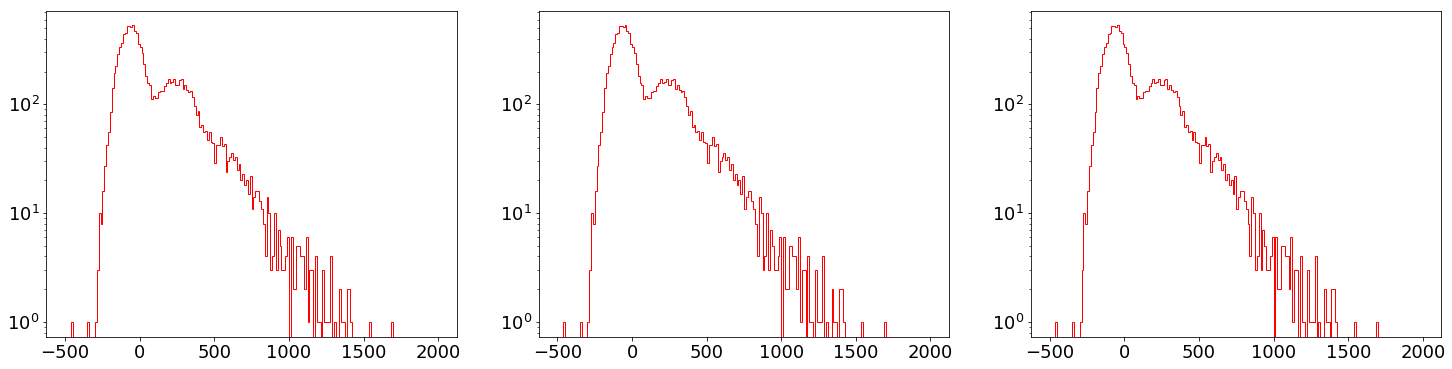

In [39]:
plt.figure(figsize=(25,6))

plt.subplot(131)
plt.hist(Area[Area['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='red', histtype='step')
#plt.hist(Area[Area['channel']==37]['area'], bins=500, range=(-500, 2000), 
#         color='blue', histtype='step')
#plt.hist(Area[Area['channel']==41]['area'], bins=500, range=(-500, 2000), 
#         color='black', histtype='step')
#plt.hist(Area[Area['channel']==42]['area'], bins=500, range=(-500, 2000), 
#         color='gold', histtype='step')
plt.yscale('log')

plt.subplot(132)

plt.hist(Area_2[6], bins=200, range=(-500, 2000), 
         color='red', histtype='step')
#plt.hist(Area_2[37], bins=500, range=(-500, 2000), 
#         color='blue', histtype='step')
#plt.hist(Area_2[41], bins=500, range=(-500, 2000), 
#         color='black', histtype='step')
#plt.hist(Area_2[42], bins=500, range=(-500, 2000), 
#         color='gold', histtype='step')
plt.yscale('log')

plt.subplot(133)

plt.hist(Area_3[Area_3['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='red', histtype='step')
#plt.hist(Area_3[Area_3['channel']==37]['area'], bins=500, range=(-500, 2000), 
#         color='blue', histtype='step')
#plt.hist(Area_3[Area_3['channel']==41]['area'], bins=500, range=(-500, 2000), 
#         color='black', histtype='step')
#plt.hist(Area_3[Area_3['channel']==42]['area'], bins=500, range=(-500, 2000), 
#         color='gold', histtype='step')
plt.yscale('log')

plt.show()

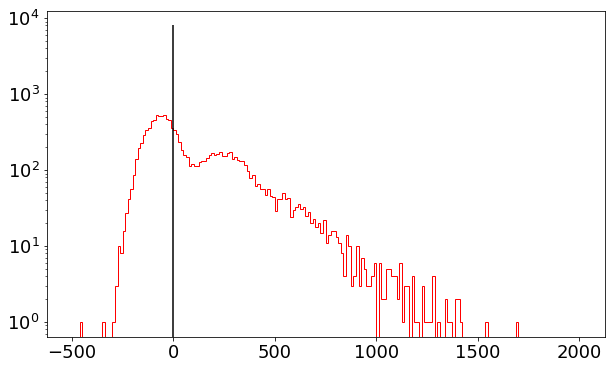

In [41]:
plt.figure(figsize=(10,6))

plt.hist(Area_3[Area_3['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='red', histtype='step')
plt.vlines(x=0, ymin=0, ymax=8000)
plt.yscale('log')

plt.show()

### Amplitude

In [34]:
def get_amplitude(raw_records, LED_window = [125, 250], noise_window = [350, 475]):
    '''
    Needed for the SPE computation.
    Take the maximum in two different regions, where there is the signal and where there is not.
    '''
    on = np.zeros((len(raw_records)), dtype=[('channel','int16'),('amplitudeLED', '<i4')])
    off = np.zeros((len(raw_records)), dtype=[('channel','int16'),('amplitudeNOISE', '<i4')])
    #on  = ((np.max(r['data'][LED_window[0]:LED_window[1]])) for r in raw_records)
    #off = ((np.max(r['data'][noise_window[0]:noise_window[1]])) for r in raw_records)
    i = 0
    for r in raw_records:
        on['amplitudeLED'][i] = np.max(r['data'][LED_window[0]:LED_window[1]])
        on['channel'][i] = r['channel']
        off['amplitudeNOISE'][i] = np.max(r['data'][noise_window[0]:noise_window[1]])
        off['channel'][i] = r['channel']
        i=i+1
    #    on.append(amp_LED)
    #    off.append(amp_NOISE)
    #on = np.array(on, dtype=[('amplitudeLED', '<i4')])
    #off = np.array(off, dtype=[('amplitudeNOISE', '<i4')])
    return on, off

In [35]:
on, off = get_amplitude(data_rr)

In [36]:
on

array([(  7, 3), (  8, 3), ( 10, 2), ..., (251, 5), (252, 4), (253, 3)],
      dtype=[('channel', '<i2'), ('amplitudeLED', '<i4')])

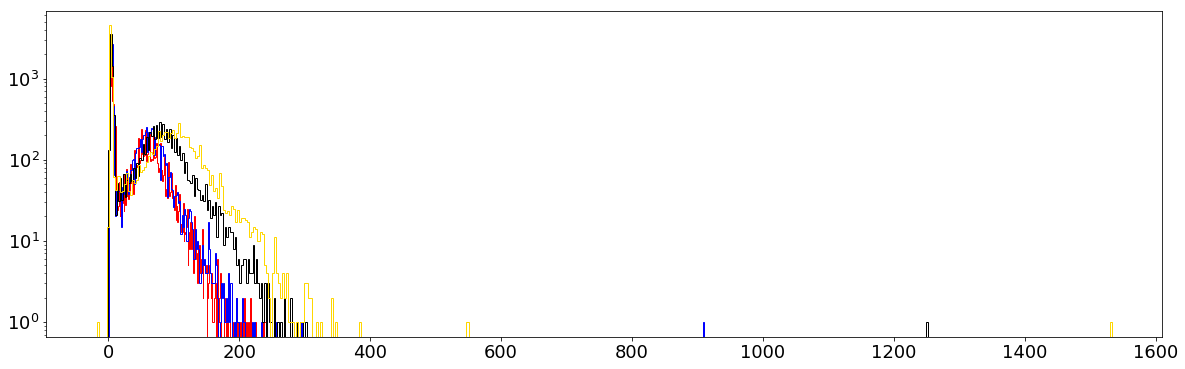

In [37]:
plt.figure(figsize=(20,6))
plt.hist(on[on['channel']==36]['amplitudeLED'], bins=200, #range=(-500, 2000), 
         color='red', histtype='step')
plt.hist(on[on['channel']==37]['amplitudeLED'], bins=500, #range=(-500, 2000), 
         color='blue', histtype='step')
plt.hist(on[on['channel']==41]['amplitudeLED'], bins=500, #range=(-500, 2000), 
         color='black', histtype='step')
plt.hist(on[on['channel']==42]['amplitudeLED'], bins=500, #range=(-500, 2000), 
         color='gold', histtype='step')
plt.yscale('log')